In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight

Processed 100 - OK
Processed 101 - OK
Processed 102 - OK
Processed 103 - OK
Processed 104 - OK
Processed 105 - OK
Processed 106 - OK
Processed 107 - OK
Processed 108 - OK
Processed 109 - OK
Processed 111 - OK
Processed 112 - OK
Processed 113 - OK
Processed 114 - OK
Processed 115 - OK
Processed 116 - OK
Processed 117 - OK
Processed 118 - OK
Processed 119 - OK
Processed 121 - OK
Processed 122 - OK
Processed 123 - OK
Processed 124 - OK
Processed 200 - OK
Processed 201 - OK
Processed 202 - OK
Processed 203 - OK
Processed 205 - OK
Processed 207 - OK
Processed 208 - OK
Processed 209 - OK
Processed 210 - OK
Processed 212 - OK
Processed 213 - OK
Processed 214 - OK
Processed 215 - OK
Processed 217 - OK
Processed 219 - OK
Processed 220 - OK
Processed 221 - OK
Processed 222 - OK
Processed 223 - OK
Processed 228 - OK
Processed 230 - OK
Processed 231 - OK
Processed 232 - OK
Processed 233 - OK
Processed 234 - OK

Total beats by category:
Class 0 (Normal Beats): 97360
Class 1 (Supraventricular Ectopy

C:\Users\cathe\AppData\Local\Temp\ipykernel_12844\3585367643.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


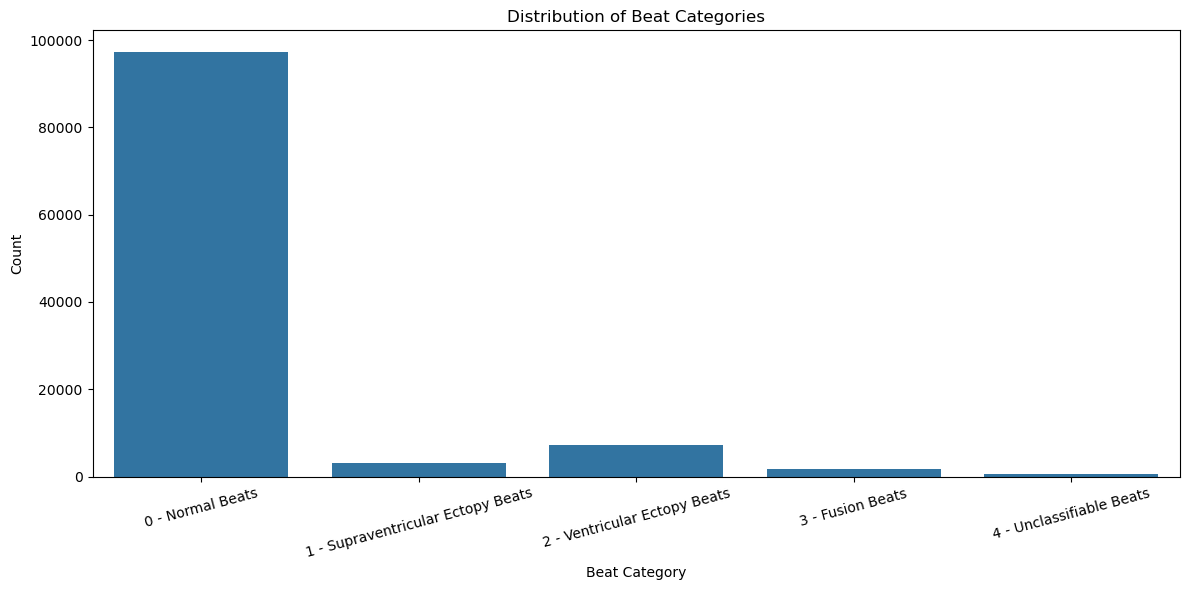

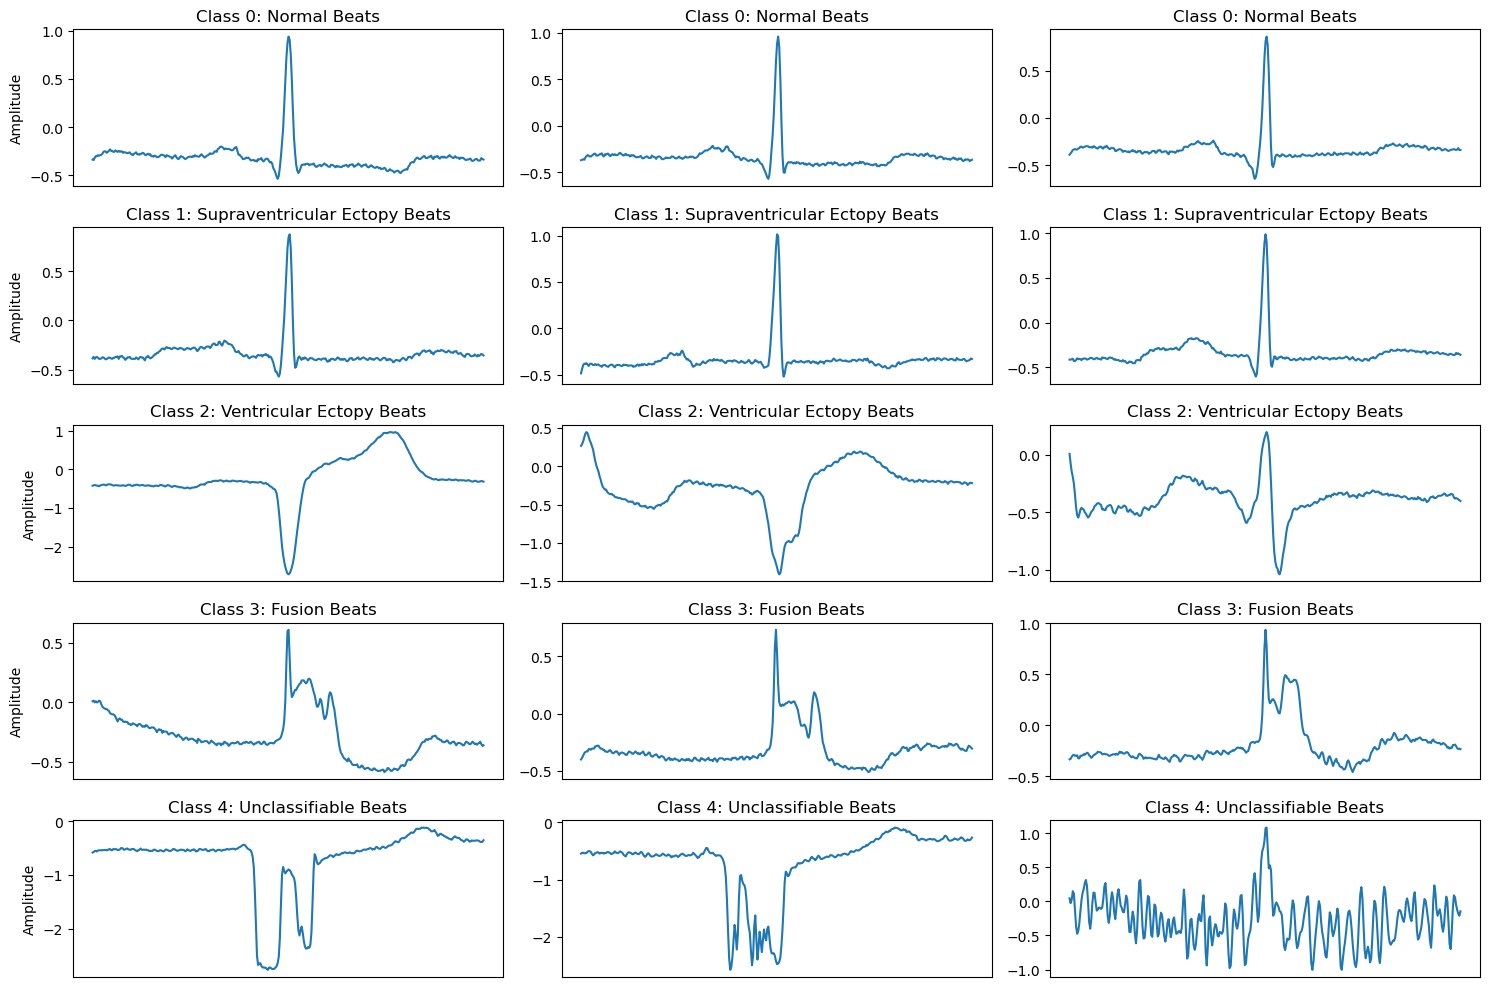

In [6]:
import wfdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set the directory containing the MIT-BIH data
data_directory = 'C:/Users/cathe/OneDrive/Documents/Tugas Akhir/Dataset/mit-bih-arrhythmia-database-1.0.0 (1)/mit-bih-arrhythmia-database-1.0.0'

# List of Patients
patients = [
    '100', '101', '102', '103', '104', '105', '106', '107',
    '108', '109', '111', '112', '113', '114', '115', '116',
    '117', '118', '119', '121', '122', '123', '124', '200',
    '201', '202', '203', '205', '207', '208', '209', '210',
    '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

# Mapping MIT-BIH beat annotations to our simplified categories
beat_mapping = {
    # Normal beats - Class 0
    'N': 0,    # Normal beat
    'L': 0,    # Left bundle branch block beat
    'R': 0,    # Right bundle branch block beat
    '/': 0,    # Paced beat
    'n': 0,    # Normal beat
    
    # Supraventricular ectopic beats - Class 1
    'A': 1,    # Atrial premature beat
    'a': 1,    # Aberrated atrial premature beat
    'J': 1,    # Nodal (junctional) premature beat
    'S': 1,    # Supraventricular premature beat
    'e': 1,    # Atrial escape beat
    'j': 1,    # Nodal (junctional) escape beat
    
    # Ventricular ectopic beats - Class 2
    'V': 2,    # Premature ventricular contraction
    'E': 2,    # Ventricular escape beat
    
    # Fusion beats - Class 3
    'F': 3,    # Fusion of ventricular and normal beat
    'f': 3,    # Fusion of paced and normal beat
    
    # Unclassifiable beats - Class 4
    'Q': 4,    # Unclassifiable beat
    '?': 4,    # Beat not classified
    '!': 4     # Ventricular flutter wave
}

# Define class names for reference
class_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

# Dictionary to store signals by numeric label (0, 1, 2, 3, 4)
signals_by_label = defaultdict(list)

# Dictionary to store patient metadata
patient_metadata = {}

# Window size (in samples) to extract around each annotation
# Adjust based on your needs - this is approximately 1 second of data at 360Hz
WINDOW_SIZE = 360

# Count of beat types by patient and label
beat_counts = defaultdict(lambda: defaultdict(int))

# Process each patient's data
for patient in patients:
    # Generate the base file path for the current patient
    file_base = os.path.join(data_directory, patient)
    
    try:
        # Read both the signal and annotation
        record = wfdb.rdrecord(file_base)
        annotation = wfdb.rdann(file_base, 'atr')
        
        # Store patient metadata
        patient_metadata[patient] = {
            'fs': record.fs,
            'n_sig': record.n_sig,
            'sig_name': record.sig_name,
            'sig_len': record.sig_len,
            'units': record.units,
            'comments': record.comments
        }
        
        # Extract the signal data (typically has 2 leads)
        signal = record.p_signal
        fs = record.fs  # Sampling frequency
        
        # Extract annotation info
        sample_points = annotation.sample
        symbols = annotation.symbol  # Using symbol instead of aux_note for beat annotations
        
        # Process beat annotations
        for i, symbol in enumerate(symbols):
            # Check if this symbol has a mapping to our categories
            if symbol in beat_mapping:
                # Get the numeric category (0, 1, 2, 3, 4)
                category = beat_mapping[symbol]
                
                # Count this beat occurrence
                beat_counts[patient][category] += 1
                
                # Get sample point (time) of this annotation
                sample_point = sample_points[i]
                
                # Calculate window boundaries
                start = max(0, sample_point - WINDOW_SIZE//2)
                end = min(len(signal), sample_point + WINDOW_SIZE//2)
                
                # Extract signal segment for both leads
                segment = signal[start:end]
                
                # Only use segments that are of the expected length
                if len(segment) == WINDOW_SIZE:
                    # Store this segment with its label
                    signals_by_label[category].append({
                        'signal': segment,
                        'patient': patient,
                        'original_symbol': symbol,
                        'sample_point': sample_point
                    })
        
        print(f"Processed {patient} - OK")
    
    except FileNotFoundError:
        print(f"File for patient {patient} not found.")
    except Exception as e:
        print(f"Error processing {patient}: {e}")

# Print summary of beats by category
total_beats = {category: len(signals) for category, signals in signals_by_label.items()}
print("\nTotal beats by category:")
for category, count in total_beats.items():
    print(f"Class {category} ({class_names[category]}): {count}")

# Create a DataFrame for easier analysis
beats_data = []
for category, segments in signals_by_label.items():
    for segment_info in segments:
        beats_data.append({
            'label': category,
            'patient': segment_info['patient'],
            'original_symbol': segment_info['original_symbol'],
            'sample_point': segment_info['sample_point'],
            'signal': segment_info['signal']
        })

beats_df = pd.DataFrame(beats_data)

# Save the DataFrame (excluding the actual signal data for display purposes)
beats_summary = beats_df[['label', 'patient', 'original_symbol', 'sample_point']].copy()
print("\nSample of beats data:")
print(beats_summary.head())

# Visualize beat distribution
plt.figure(figsize=(12, 6))
class_order = [0, 1, 2, 3, 4]
ax = sns.countplot(x='label', data=beats_df, order=class_order)
plt.title('Distribution of Beat Categories')
plt.xlabel('Beat Category')
plt.ylabel('Count')

# Add labels to the x-axis ticks
x_labels = [f"{i} - {class_names[i]}" for i in class_order]
ax.set_xticklabels(x_labels)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Optional: Visualize some example beats from each category
def plot_example_beats(signals_by_label, num_examples=3):
    plt.figure(figsize=(15, 10))
    categories = [0, 1, 2, 3, 4]
    
    for i, category in enumerate(categories):
        if category in signals_by_label and len(signals_by_label[category]) > 0:
            # Select up to num_examples from this category
            examples = signals_by_label[category][:num_examples]
            
            for j, example in enumerate(examples):
                plt.subplot(5, num_examples, i*num_examples + j + 1)
                plt.plot(example['signal'][:, 0])  # Plot first lead
                plt.title(f"Class {category}: {class_names[category]}")
                plt.xticks([])
                
                if j == 0:
                    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

# Plot example beats
plot_example_beats(signals_by_label)
# Export data to CSV (optional)
beats_summary.to_csv('mit_bih_beats_summary.csv', index=False)

# EXPLORATORY DATA ANALYSIS (EDA)

In [8]:
beats_df

label patient original_symbol  sample_point  \
0           0     100               N           370   
1           0     100               N           662   
2           0     100               N           946   
3           0     100               N          1231   
4           0     100               N          1515   
...       ...     ...             ...           ...   
109905      3     233               F        162653   
109906      3     233               F        229415   
109907      3     233               F        309628   
109908      3     233               F        341070   
109909      3     233               F        596390   

                                                   signal  
0       [[-0.335, -0.25], [-0.34, -0.235], [-0.315, -0...  
1       [[-0.37, -0.27], [-0.365, -0.26], [-0.36, -0.2...  
2       [[-0.39, -0.31], [-0.375, -0.295], [-0.36, -0....  
3       [[-0.32, -0.25], [-0.315, -0.245], [-0.32, -0....  
4       [[-0.425, -0.37], [-0.42, -0.36], [-0.405, -0....  
...                                                   ...  
109905  [[-0.35, 0.08], [-0.35, 0.08], [-0.35, 0.095],...  
109906  [[-0.35, 0.07], [-0.35, 0.08], [-0.36, 0.085],...  
109907  [[-0.395, 0.25], [-0.395, 0.25], [-0.415, 0.25...  
109908  [[-0.805, 0.095], [-0.8, 0.11], [-0.82, 0.12],...  
109909  [[-0.38, 0.15], [-0.385, 0.15], [-0.385, 0.145...  

[109910 rows x 5 columns]

Number of episodes per arrhythmia type:
Class 0 - Normal Beats: 97360
Class 1 - Supraventricular Ectopy Beats: 3026
Class 2 - Ventricular Ectopy Beats: 7235
Class 3 - Fusion Beats: 1784
Class 4 - Unclassifiable Beats: 505


C:\Users\cathe\AppData\Local\Temp\ipykernel_12844\2747314972.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_table = arrhythmia_df.pivot_table(values='count', index='patient', columns='arrhythmia', fill_value=0)


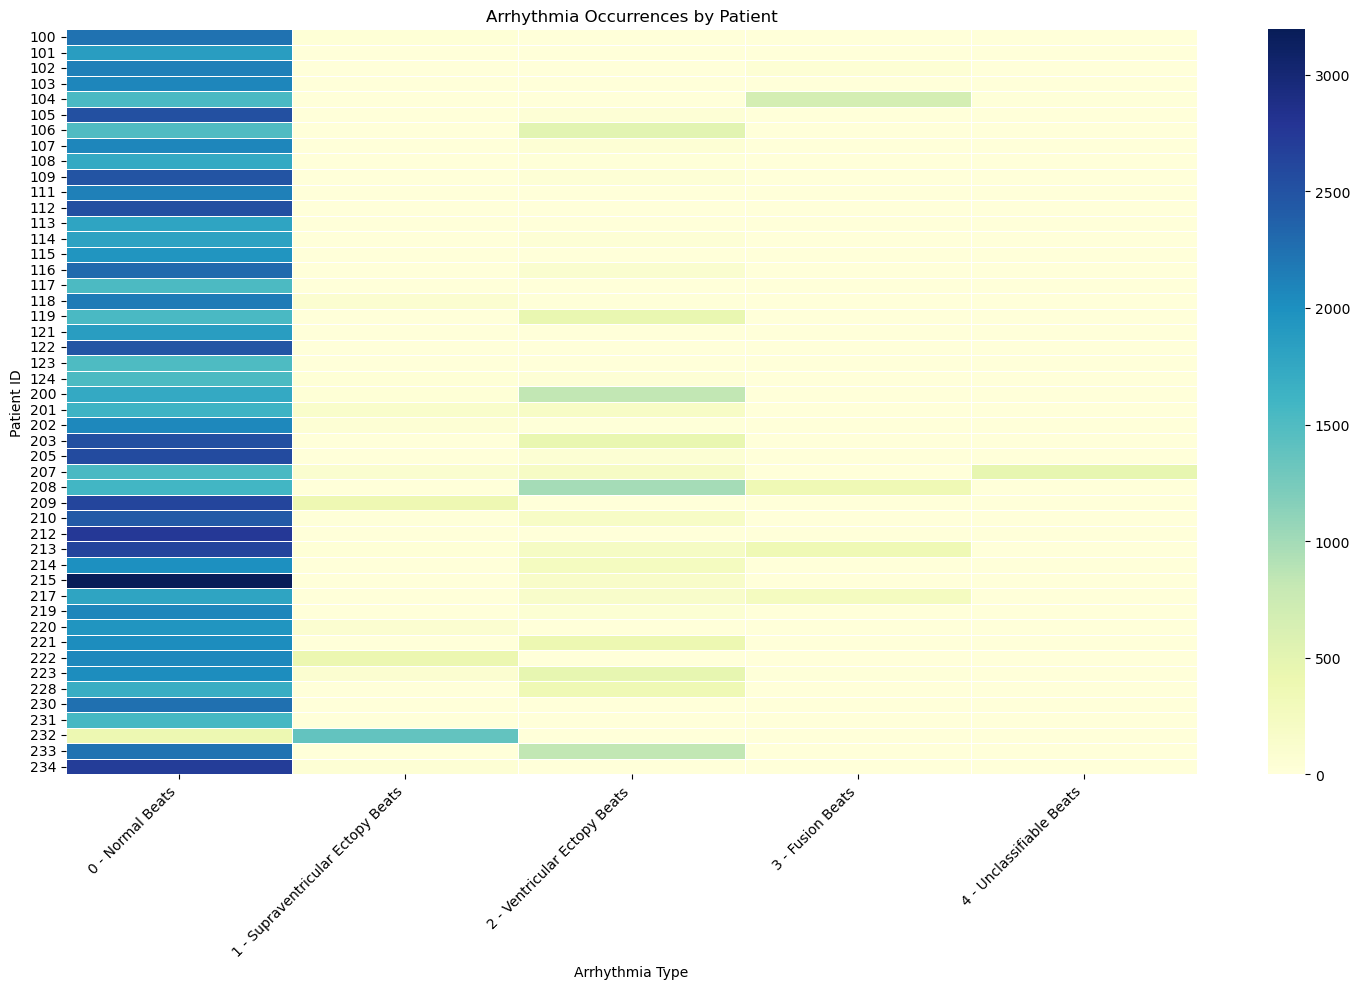

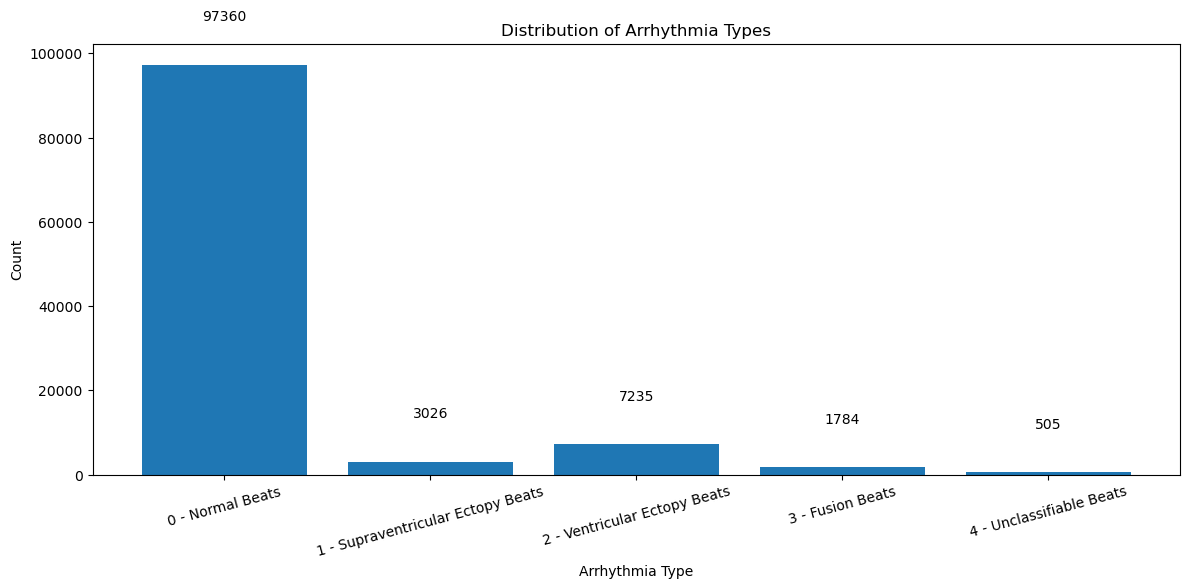

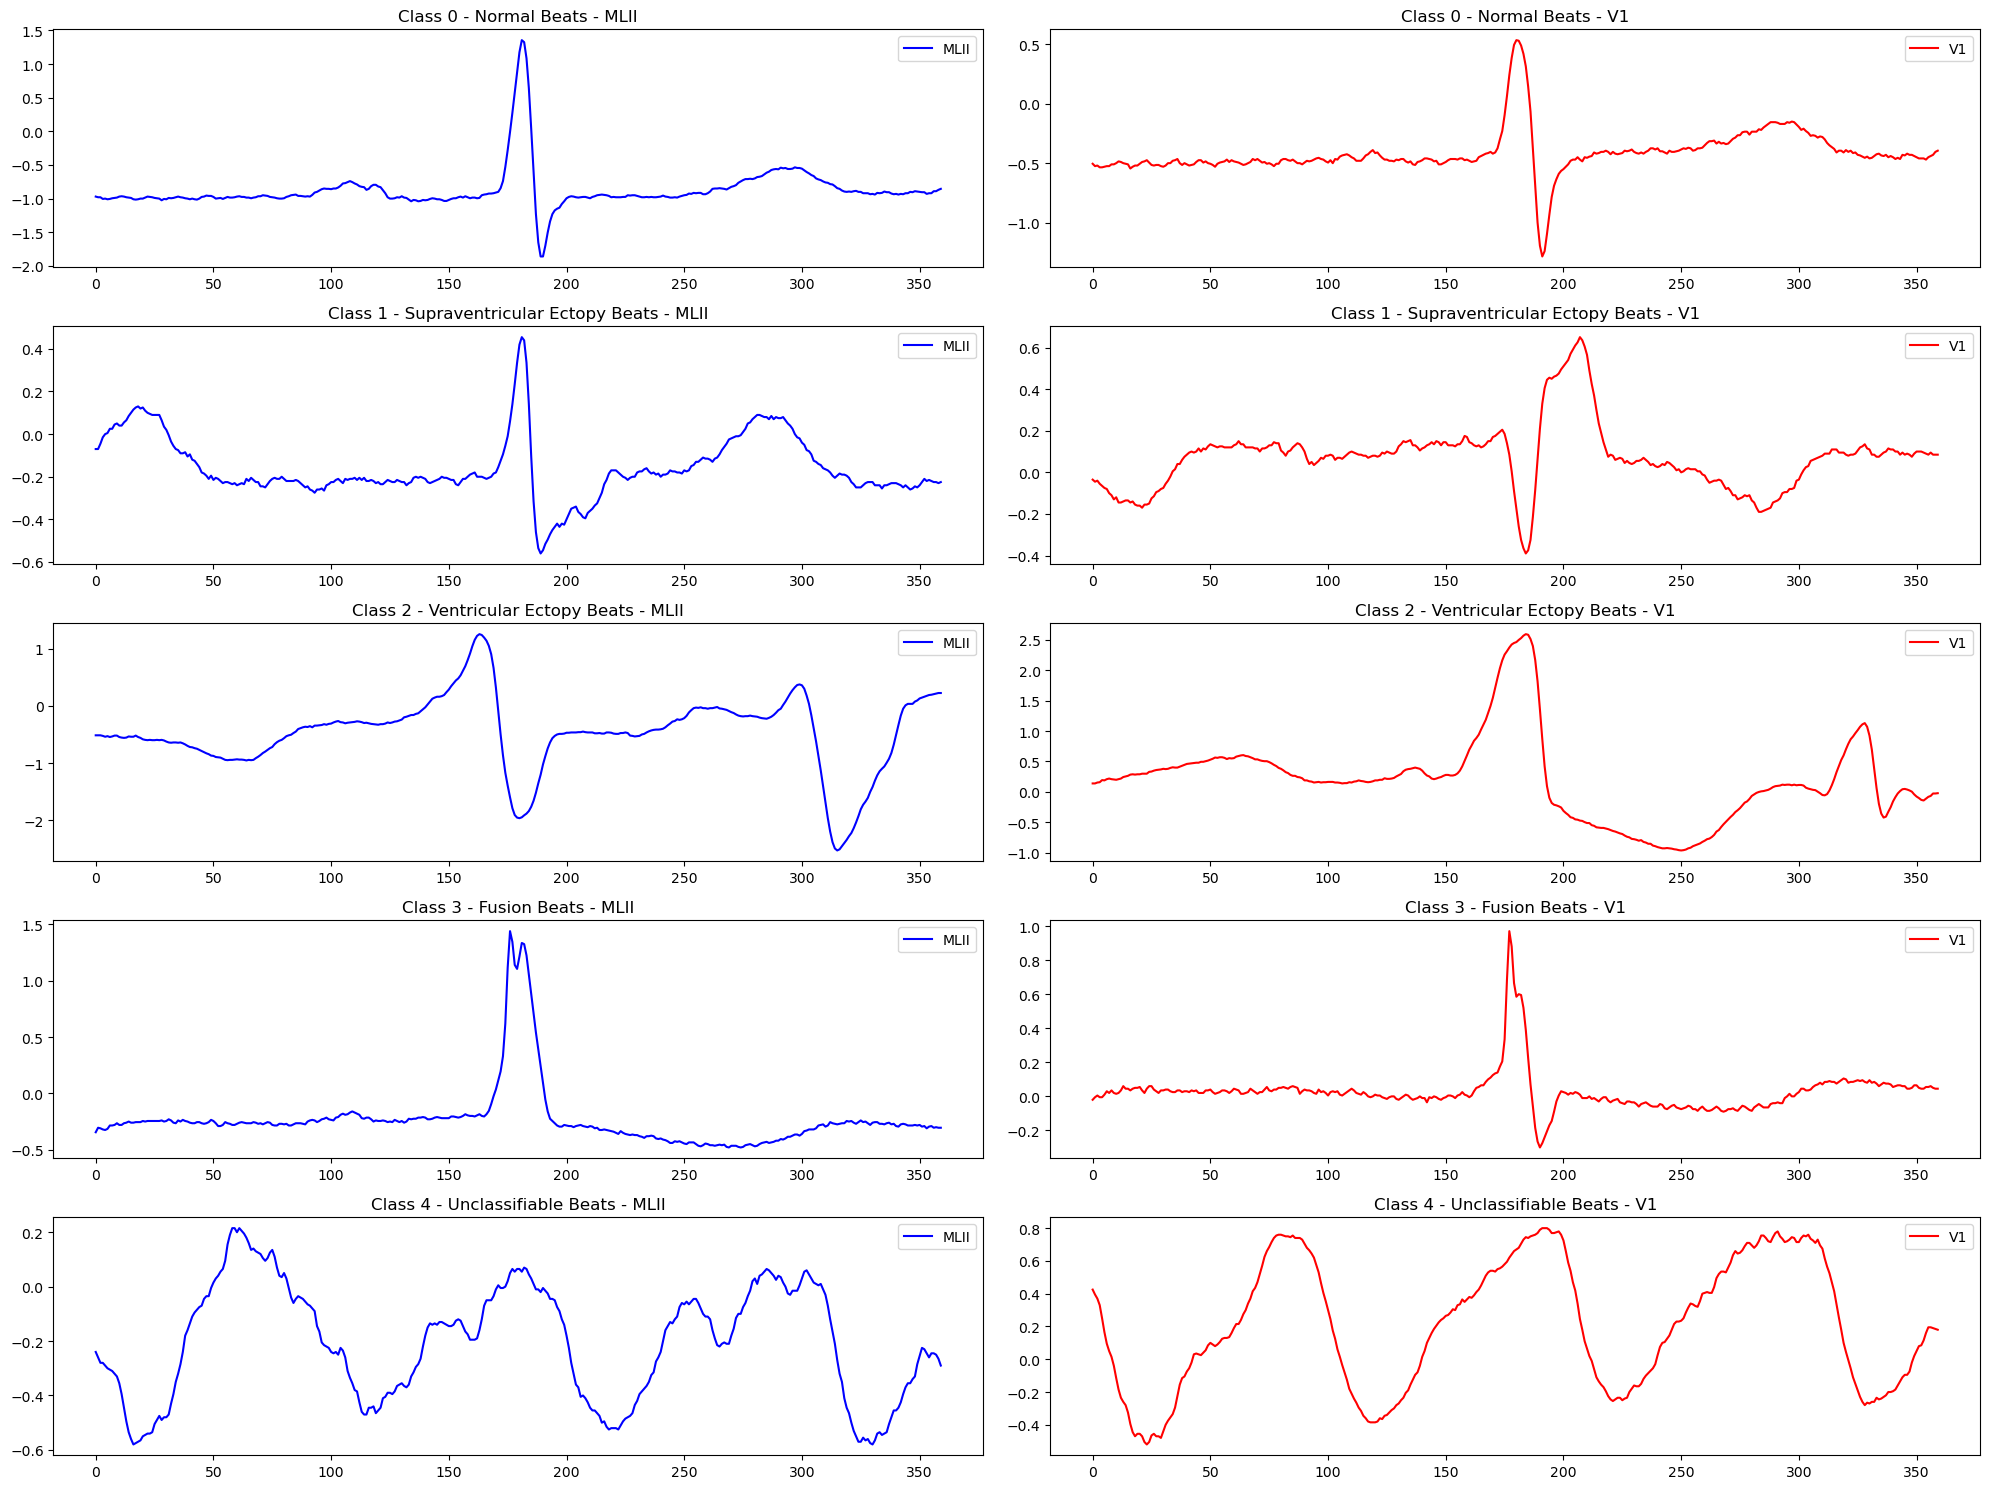

C:\Users\cathe\AppData\Local\Temp\ipykernel_12844\2747314972.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats, pd.DataFrame({


Summary statistics for each arrhythmia type:
  arrhythmia                     class_name  mean_MLII  std_MLII   mean_V1  \
0          0                   Normal Beats  -0.336625  0.444494 -0.105351   
1          1  Supraventricular Ectopy Beats  -0.203485  0.321840 -0.025262   
2          2       Ventricular Ectopy Beats  -0.252961  0.638708 -0.026081   
3          4           Unclassifiable Beats  -0.147386  0.395442  0.075616   
4          3                   Fusion Beats  -0.196645  0.456669  0.027841   

     std_V1  max_MLII  min_MLII  max_V1  min_V1  
0  0.433778     5.115    -5.120   5.115  -5.120  
1  0.283274     2.835    -2.755   5.115  -3.700  
2  0.509697     3.640    -3.605   4.400  -5.120  
3  0.568504     2.795    -3.485   2.560  -1.995  
4  0.424502     3.400    -2.800   2.640  -3.555  


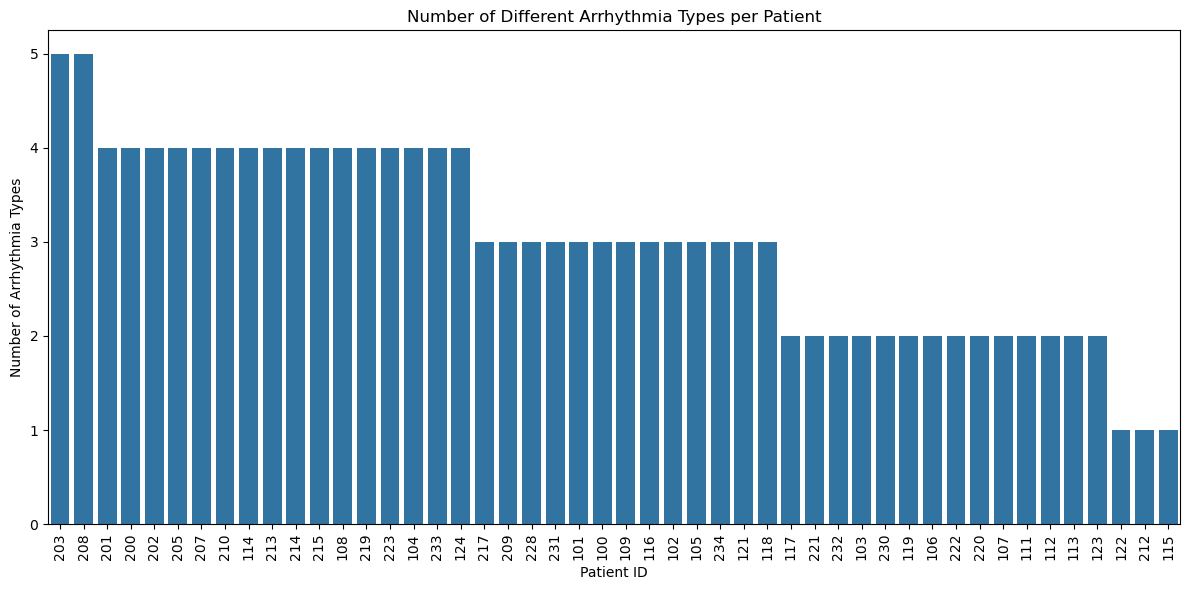

In [10]:
# 1. Total number of instances per arrhythmia type
label_counts = {label: len(segments) for label, segments in signals_by_label.items()}
print("Number of episodes per arrhythmia type:")
for label, count in sorted(label_counts.items(), key=lambda x: x[0]):
    print(f"Class {label} - {class_names[label]}: {count}")

# 2. Convert beat_counts to a DataFrame for easier analysis
arrhythmia_df = pd.DataFrame(columns=['patient', 'arrhythmia', 'count'])
for patient, labels in beat_counts.items():
    for label, count in labels.items():
        arrhythmia_df = pd.concat([arrhythmia_df, pd.DataFrame({
            'patient': [patient],
            'arrhythmia': [label],
            'count': [count]
        })], ignore_index=True)

# Add class name column to the DataFrame
arrhythmia_df['class_name'] = arrhythmia_df['arrhythmia'].map(class_names)

# 3. Create a heatmap of arrhythmia occurrences across patients
plt.figure(figsize=(15, 10))
pivot_table = arrhythmia_df.pivot_table(values='count', index='patient', columns='arrhythmia', fill_value=0)
# Reorder columns if necessary
if not all(i in pivot_table.columns for i in range(5)):
    for i in range(5):
        if i not in pivot_table.columns:
            pivot_table[i] = 0
    pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns))

# Create heatmap
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Arrhythmia Occurrences by Patient')
plt.ylabel('Patient ID')
plt.xlabel('Arrhythmia Type')
plt.xticks(ticks=np.arange(len(pivot_table.columns)) + 0.5, 
           labels=[f"{col} - {class_names[col]}" for col in pivot_table.columns], 
           rotation=45, 
           ha='right')
plt.tight_layout()
plt.savefig('arrhythmia_heatmap.png')
plt.show()

# 4. Visualize distribution of arrhythmia types
plt.figure(figsize=(12, 6))
sorted_labels = sorted(label_counts.keys())
counts = [label_counts[label] for label in sorted_labels]
x_positions = np.arange(len(sorted_labels))

bars = plt.bar(x_positions, counts)
plt.title('Distribution of Arrhythmia Types')
plt.xlabel('Arrhythmia Type')
plt.ylabel('Count')
plt.xticks(x_positions, [f"{i} - {class_names[i]}" for i in sorted_labels], rotation=15)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1*max(counts),
             f'{int(height)}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('arrhythmia_distribution.png')
plt.show()

# 5. Visualize example signals for each arrhythmia type
plt.figure(figsize=(20, 15))
for i, category in enumerate(sorted(signals_by_label.keys())):
    segments = signals_by_label[category]
    if segments:  # Check if there are any segments for this label
        # Pick a random example
        example = segments[np.random.randint(0, len(segments))]
        signal_data = example['signal']

        # Plot both leads with corrected naming
        plt.subplot(len(signals_by_label), 2, 2*i+1)
        plt.plot(signal_data[:, 0], 'b-', label='MLII')
        plt.title(f"Class {category} - {class_names[category]} - MLII")
        plt.legend(loc='upper right')
        
        plt.subplot(len(signals_by_label), 2, 2*i+2)
        plt.plot(signal_data[:, 1], 'r-', label='V1')
        plt.title(f"Class {category} - {class_names[category]} - V1")
        plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('example_signals.png')
plt.show()

# 6. Create a summary statistics DataFrame for each arrhythmia type
summary_stats = pd.DataFrame(columns=['arrhythmia', 'class_name', 'mean_MLII', 'std_MLII', 'mean_V1', 'std_V1', 'max_MLII', 'min_MLII', 'max_V1', 'min_V1'])

for label, segments in signals_by_label.items():
    if segments:
        # Extract signal data for this label
        signals_MLII = np.array([s['signal'][:, 0] for s in segments])
        signals_V1 = np.array([s['signal'][:, 1] for s in segments])

        # Calculate statistics
        summary_stats = pd.concat([summary_stats, pd.DataFrame({
            'arrhythmia': [label],
            'class_name': [class_names[label]],
            'mean_MLII': [np.mean(signals_MLII)],
            'std_MLII': [np.std(signals_MLII)],
            'mean_V1': [np.mean(signals_V1)],
            'std_V1': [np.std(signals_V1)],
            'max_MLII': [np.max(signals_MLII)],
            'min_MLII': [np.min(signals_MLII)],
            'max_V1': [np.max(signals_V1)],
            'min_V1': [np.min(signals_V1)]
        })], ignore_index=True)

print("Summary statistics for each arrhythmia type:")
print(summary_stats)

# 7. Analyze patients with multiple arrhythmia types
patient_beat_counts = arrhythmia_df.groupby('patient')['arrhythmia'].nunique().reset_index()
patient_beat_counts.columns = ['patient', 'num_arrhythmia_types']

plt.figure(figsize=(12, 6))
sns.barplot(x='patient', y='num_arrhythmia_types', data=patient_beat_counts.sort_values('num_arrhythmia_types', ascending=False))
plt.title('Number of Different Arrhythmia Types per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Number of Arrhythmia Types')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('arrhythmia_types_per_patient.png')
plt.show()

# 8. Save the processed data for later use
np.save('signals_by_label.npy', signals_by_label)
arrhythmia_df.to_csv('beat_counts.csv', index=False)
summary_stats.to_csv('beat_summary_stats.csv', index=False)

In [12]:
beats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109910 entries, 0 to 109909
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   label            109910 non-null  int64 
 1   patient          109910 non-null  object
 2   original_symbol  109910 non-null  object
 3   sample_point     109910 non-null  int64 
 4   signal           109910 non-null  object
dtypes: int64(2), object(3)
memory usage: 4.2+ MB


# Pre-processing

UNDERSAMPLING

Loading dataset...
Preprocessing dataset to ensure signal index 0 is used...
Processed 109910 signals
Processing original dataset...

Original Class Distribution:
Class 0 (Normal Beats): 97360
Class 1 (Supraventricular Ectopy Beats): 3026
Class 2 (Ventricular Ectopy Beats): 7235
Class 3 (Fusion Beats): 1784
Class 4 (Unclassifiable Beats): 505


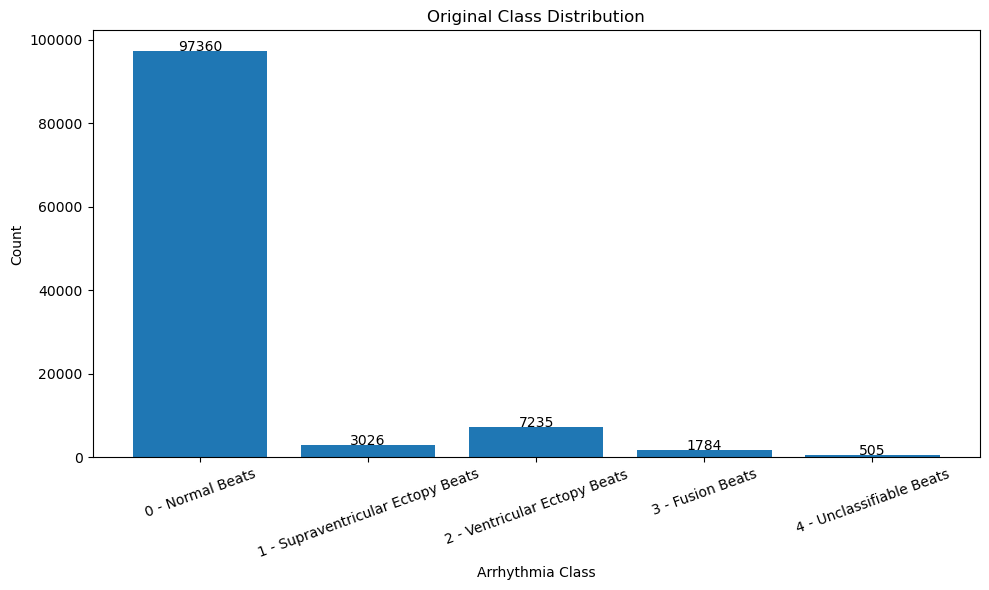

Original data shape: (109910, 5)

Original Class Distribution:
Class 0 (Normal Beats): 97360
Class 1 (Supraventricular Ectopy Beats): 3026
Class 2 (Ventricular Ectopy Beats): 7235
Class 3 (Fusion Beats): 1784
Class 4 (Unclassifiable Beats): 505


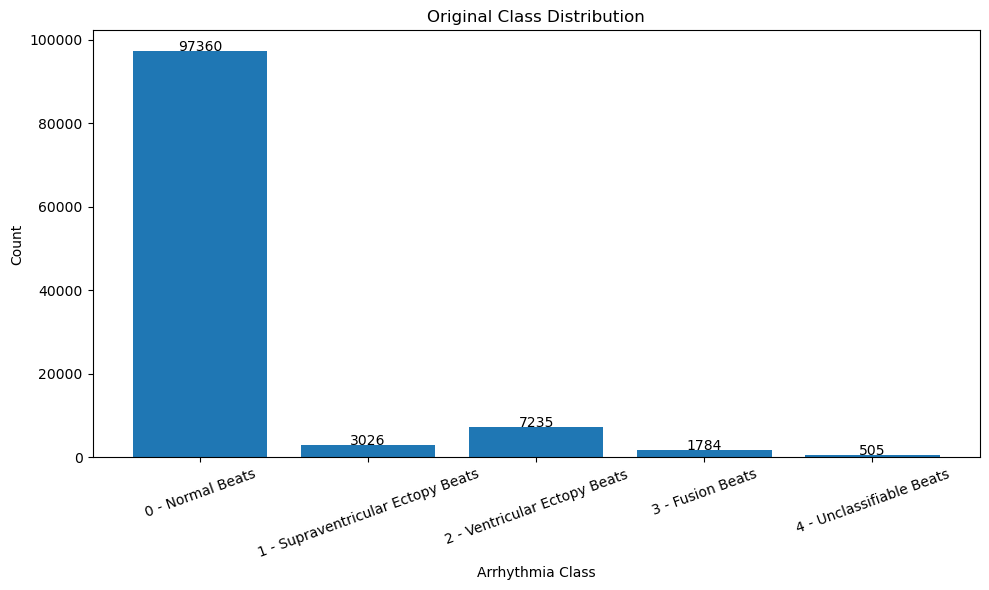


Original Patient Distribution by Class:
Class 0 (Normal Beats): 48 unique patients
Class 1 (Supraventricular Ectopy Beats): 32 unique patients
Class 2 (Ventricular Ectopy Beats): 37 unique patients
Class 3 (Fusion Beats): 20 unique patients
Class 4 (Unclassifiable Beats): 7 unique patients


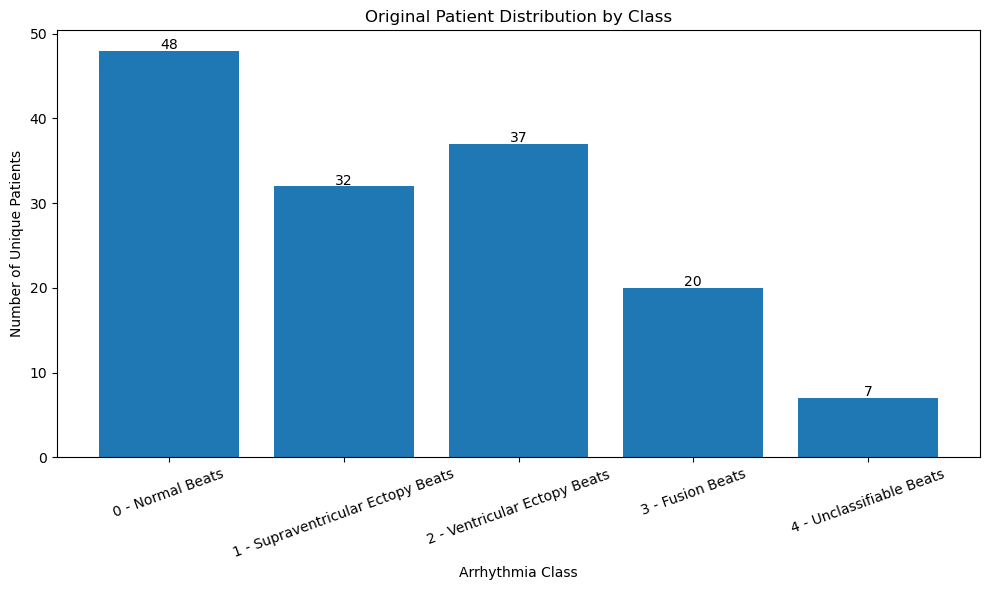


Processing Class 0 (Normal Beats)...
Class 0 has 97360 samples from 48 patients
Selected 500 samples from class 0

Processing Class 1 (Supraventricular Ectopy Beats)...
Class 1 has 3026 samples from 32 patients
Selected 500 samples from class 1

Processing Class 2 (Ventricular Ectopy Beats)...
Class 2 has 7235 samples from 37 patients
Selected 500 samples from class 2

Processing Class 3 (Fusion Beats)...
Class 3 has 1784 samples from 20 patients
Selected 500 samples from class 3

Processing Class 4 (Unclassifiable Beats)...
Class 4 has 505 samples from 7 patients
Selected 500 samples from class 4

Final Class Distribution:
Class 0 (Normal Beats): 500
Class 1 (Supraventricular Ectopy Beats): 500
Class 2 (Ventricular Ectopy Beats): 500
Class 3 (Fusion Beats): 500
Class 4 (Unclassifiable Beats): 500


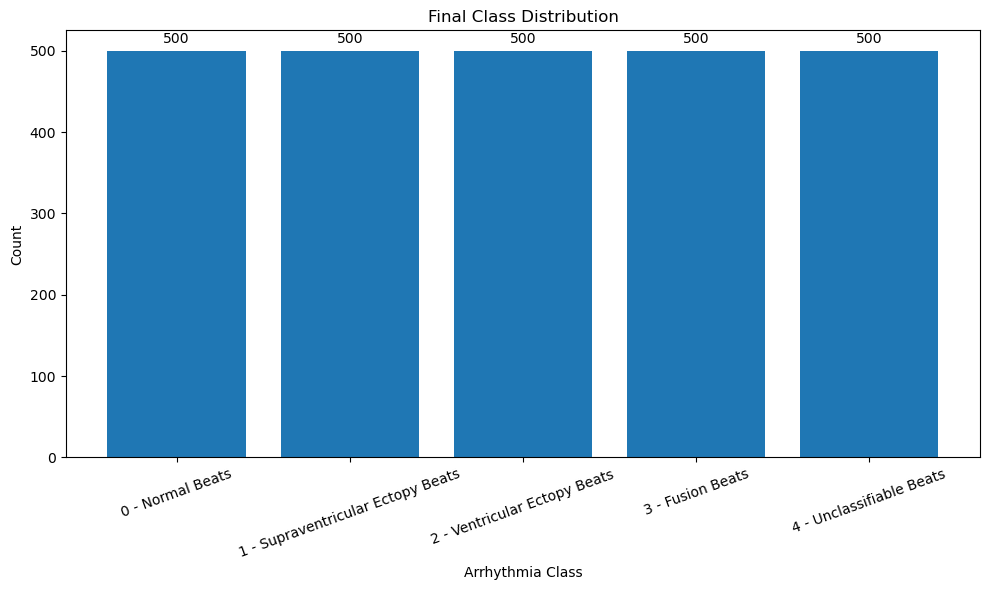


Final Patient Distribution by Class:
Class 0 (Normal Beats): 48 unique patients
Class 1 (Supraventricular Ectopy Beats): 32 unique patients
Class 2 (Ventricular Ectopy Beats): 37 unique patients
Class 3 (Fusion Beats): 20 unique patients
Class 4 (Unclassifiable Beats): 7 unique patients


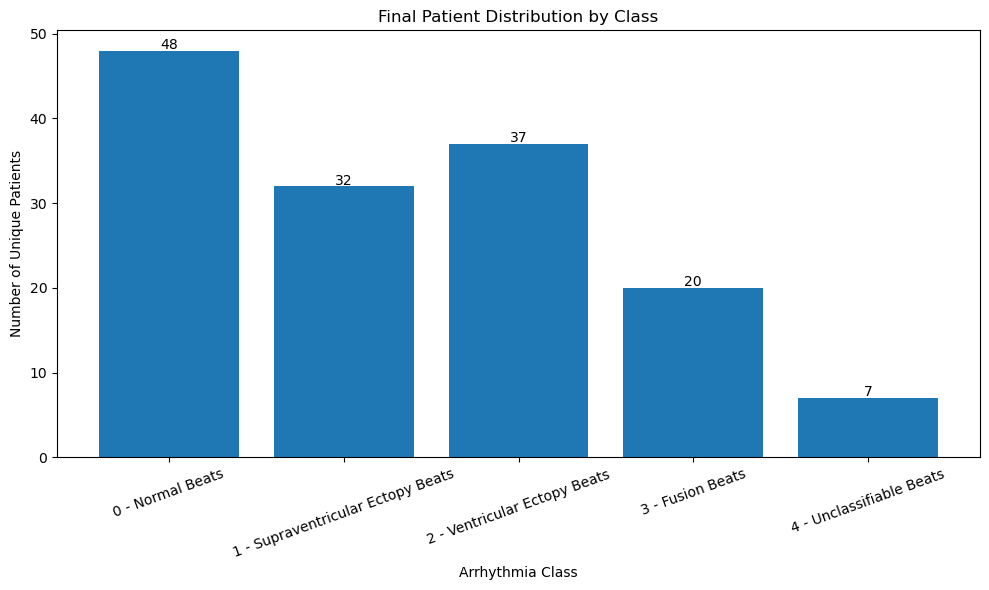

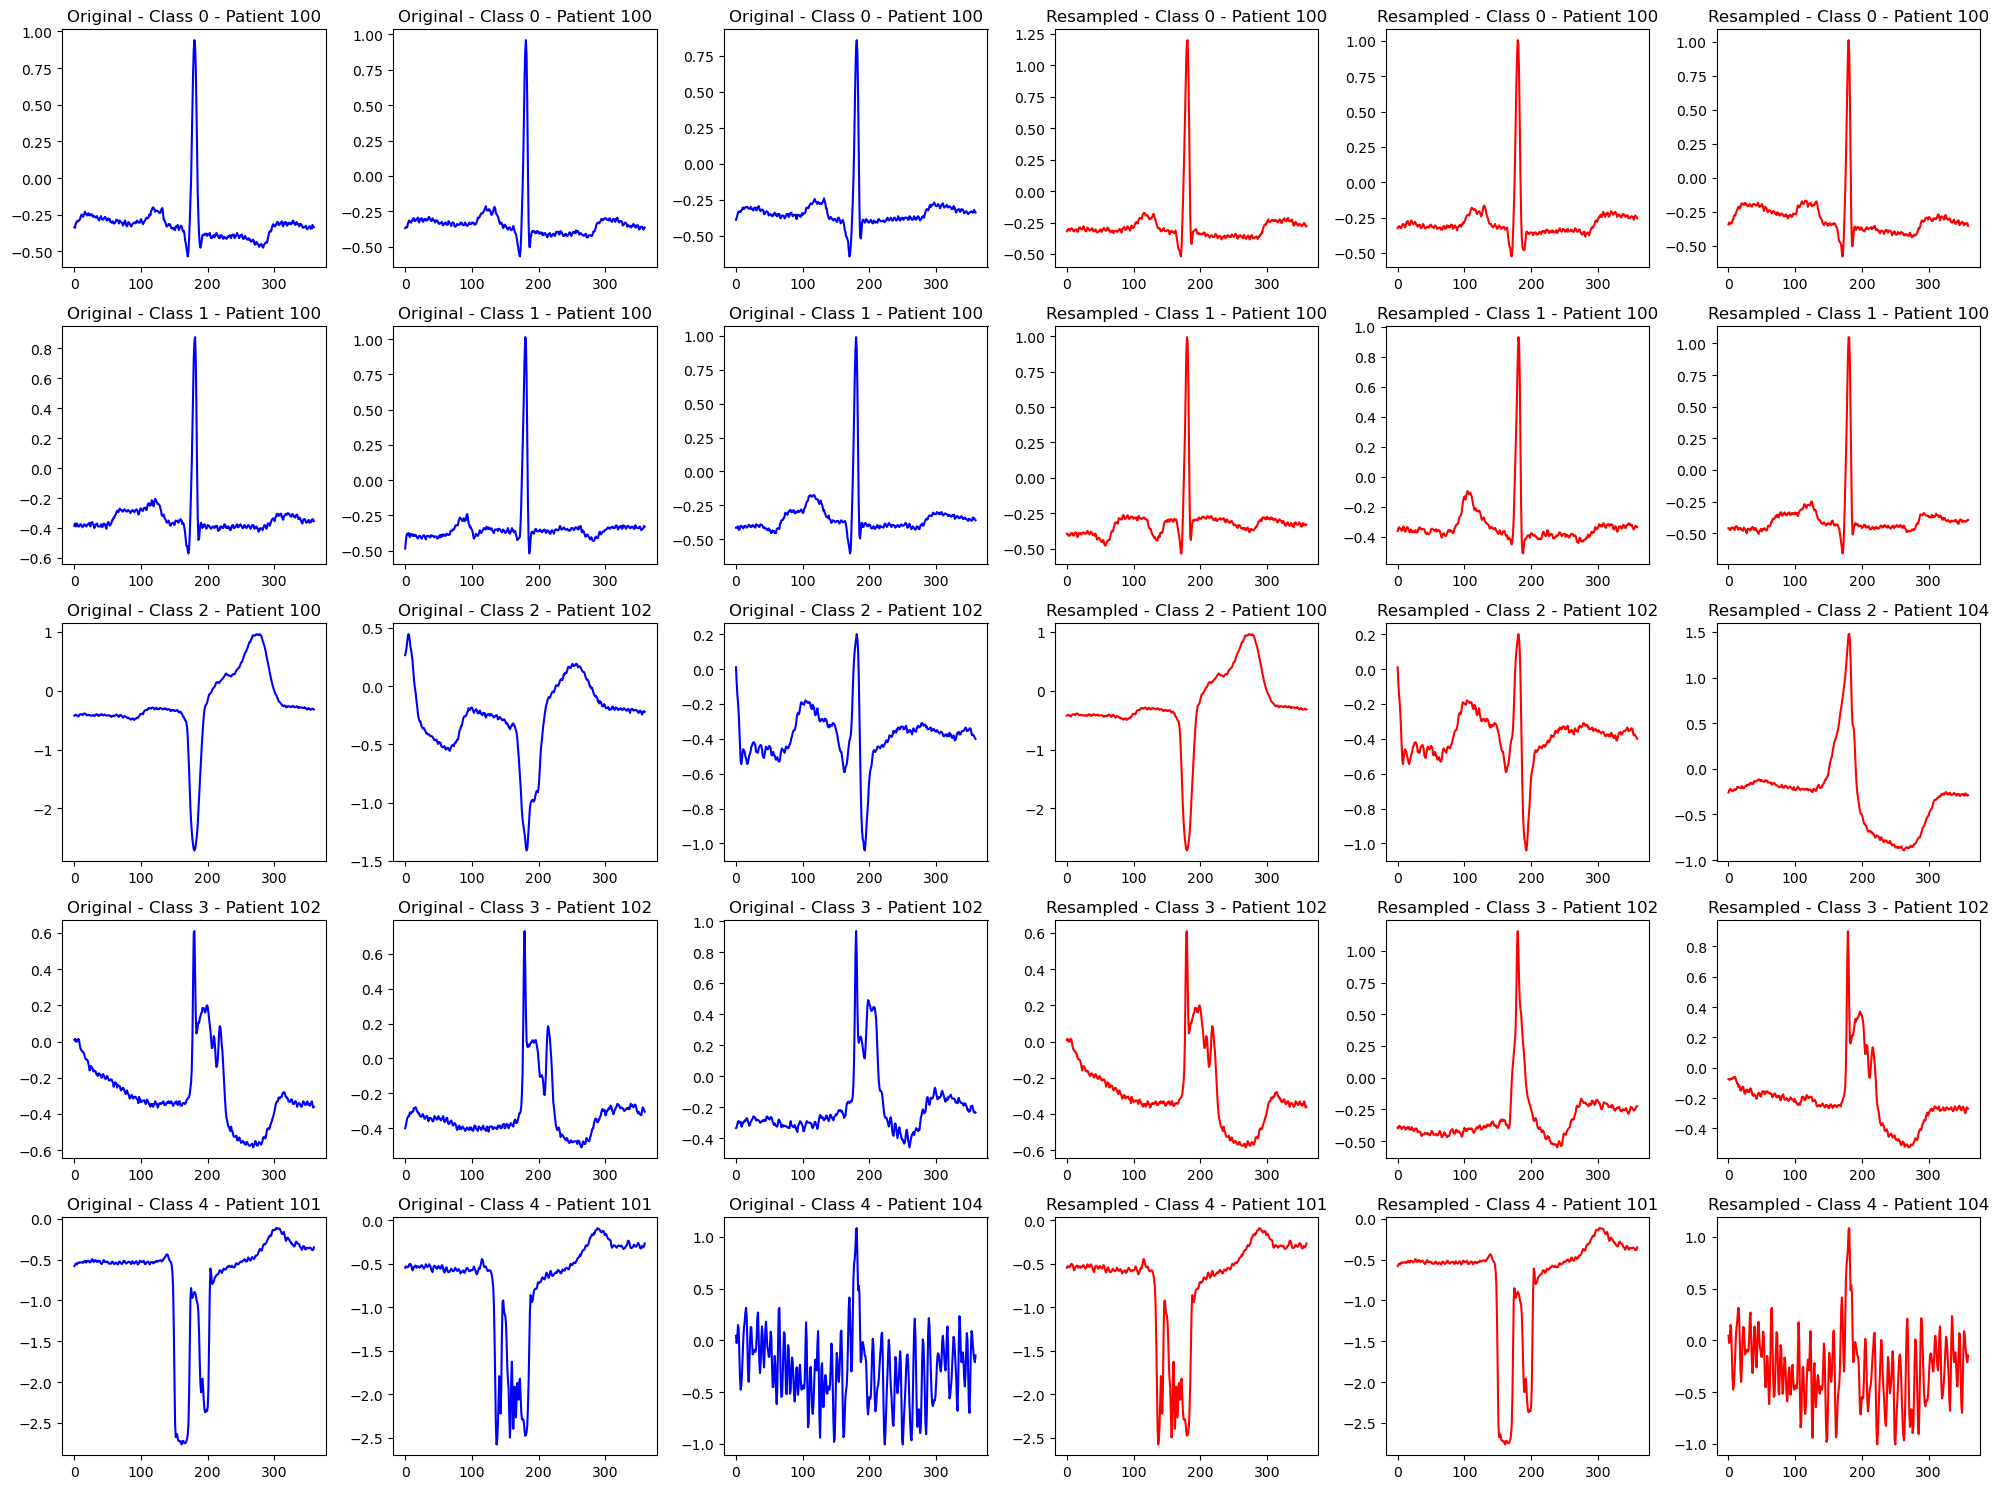

Saving resampled data...
Undersampling complete. Resampled data saved.
Class 0 (Normal Beats): 500 samples
Class 1 (Supraventricular Ectopy Beats): 500 samples
Class 2 (Ventricular Ectopy Beats): 500 samples
Class 3 (Fusion Beats): 500 samples
Class 4 (Unclassifiable Beats): 500 samples

Patient distribution in final dataset:
Class 0 (Normal Beats): 48 unique patients
  Patients: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
Class 1 (Supraventricular Ectopy Beats): 32 unique patients
  Patients: ['100', '101', '103', '108', '112', '113', '114', '116', '117', '118', '121', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '213', '215', '219', '220', '222', '223', '228', '231', '232

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

# Class names for better readability
class_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

def preprocess_signal(signal):
    """Ensure we're always using signal at index 0 for multi-lead signals"""
    if isinstance(signal, np.ndarray) and len(signal.shape) > 1:
        # Extract only the first lead (MLII, index 0)
        return signal[:, 0]
    else:
        return signal

def display_class_distribution(df, title="Class Distribution"):
    """Display the distribution of classes in the dataframe"""
    distribution = df['label'].value_counts().sort_index().to_dict()
    
    # Ensure all classes are represented
    for class_id in range(5):
        if class_id not in distribution:
            distribution[class_id] = 0
    
    # Sort by class id
    sorted_distribution = {k: distribution[k] for k in sorted(distribution.keys())}
    
    # Print counts
    print(f"\n{title}:")
    for class_id, count in sorted_distribution.items():
        print(f"Class {class_id} ({class_names[class_id]}): {count}")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(
        [f"{k} - {class_names[k]}" for k in sorted_distribution.keys()], 
        sorted_distribution.values()
    )
    plt.title(title)
    plt.xlabel("Arrhythmia Class")
    plt.ylabel("Count")
    plt.xticks(rotation=20)
    for i, count in enumerate(sorted_distribution.values()):
        plt.text(i, count + 10, str(count), ha='center')
    plt.tight_layout()
    plt.show()
    
    return sorted_distribution

def display_patient_distribution(df, title="Patient Distribution by Class"):
    """Display the number of unique patients per class"""
    patient_counts = {}
    
    for class_id in df['label'].unique():
        class_df = df[df['label'] == class_id]
        unique_patients = class_df['patient'].nunique()
        patient_counts[class_id] = unique_patients
    
    # Ensure all classes are represented
    for class_id in range(5):
        if class_id not in patient_counts:
            patient_counts[class_id] = 0
    
    # Sort by class id
    sorted_patient_counts = {k: patient_counts[k] for k in sorted(patient_counts.keys())}
    
    # Print counts
    print(f"\n{title}:")
    for class_id, count in sorted_patient_counts.items():
        print(f"Class {class_id} ({class_names[class_id]}): {count} unique patients")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(
        [f"{k} - {class_names[k]}" for k in sorted_patient_counts.keys()], 
        sorted_patient_counts.values()
    )
    plt.title(title)
    plt.xlabel("Arrhythmia Class")
    plt.ylabel("Number of Unique Patients")
    plt.xticks(rotation=20)
    for i, count in enumerate(sorted_patient_counts.values()):
        plt.text(i, count + 0.2, str(count), ha='center')
    plt.tight_layout()
    plt.show()
    
    return sorted_patient_counts

def balanced_undersampling_with_patient_distribution(beats_df, samples_per_class=500):
    """
    Perform undersampling to get exactly samples_per_class samples for each class
    while ensuring data is taken from all available patients
    """
    print("Original data shape:", beats_df.shape)
    
    # Display original class distribution
    display_class_distribution(beats_df, "Original Class Distribution")
    
    # Display original patient distribution
    display_patient_distribution(beats_df, "Original Patient Distribution by Class")
    
    # Create a new dataframe to store the resampled data
    resampled_df = pd.DataFrame()
    
    # Process each class independently to ensure balanced representation across patients
    for class_id in sorted(beats_df['label'].unique()):
        print(f"\nProcessing Class {class_id} ({class_names[class_id]})...")
        
        # Get all samples for this class
        class_df = beats_df[beats_df['label'] == class_id].copy()
        
        # Get unique patients for this class
        unique_patients = class_df['patient'].unique()
        print(f"Class {class_id} has {len(class_df)} samples from {len(unique_patients)} patients")
        
        if len(class_df) <= samples_per_class:
            # If we have fewer samples than needed, keep all of them
            print(f"Class {class_id} has fewer than {samples_per_class} samples. Keeping all.")
            selected_df = class_df
        else:
            # If we have more than enough samples, we need to balance across patients
            # Create a complex stratification feature by combining label and patient
            class_df['stratify'] = class_df['patient'].astype(str)
            
            # Prepare data for RandomUnderSampler
            X = class_df.drop('signal', axis=1)  # Features (except signal which is complex)
            y = class_df['stratify']  # Stratification target
            
            # Convert signals to a separate numpy array and ensure we're using index 0
            signals = np.array([preprocess_signal(signal) for signal in class_df['signal']])
            
            # Encode stratification labels numerically for RandomUnderSampler
            label_encoder = LabelEncoder()
            y_encoded = label_encoder.fit_transform(y)
            
            # Calculate sampling strategy based on patient distribution
            # We want to take samples from each patient proportionally
            patient_counts = class_df['patient'].value_counts()
            total_samples = len(class_df)
            
            sampling_strategy = {}
            for patient, count in patient_counts.items():
                # Calculate proportional number of samples for this patient
                patient_samples = int(np.ceil((count / total_samples) * samples_per_class))
                
                # Convert patient label to encoded value
                patient_encoded = label_encoder.transform([str(patient)])[0]
                sampling_strategy[patient_encoded] = patient_samples
            
            # Adjust sampling strategy to exactly hit our target
            current_total = sum(sampling_strategy.values())
            if current_total > samples_per_class:
                # Reduce samples from patients with the most samples
                patients_sorted = sorted(sampling_strategy.items(), key=lambda x: x[1], reverse=True)
                excess = current_total - samples_per_class
                
                for i in range(excess):
                    patient_idx = i % len(patients_sorted)
                    patient_key = patients_sorted[patient_idx][0]
                    if sampling_strategy[patient_key] > 1:  # Ensure we keep at least 1 sample
                        sampling_strategy[patient_key] -= 1
            
            # Apply RandomUnderSampler with the patient-aware strategy
            try:
                rus = RandomUnderSampler(
                    sampling_strategy=sampling_strategy,
                    random_state=42
                )
                
                # Fit and resample the indices
                X_resampled, y_resampled = rus.fit_resample(
                    np.arange(len(X)).reshape(-1, 1), y_encoded
                )
                
                # Get the selected indices
                selected_indices = X_resampled.flatten()
                
                # Create a new dataframe with the selected samples
                selected_df = class_df.iloc[selected_indices].copy()
                
                # Verify the number of samples
                print(f"Selected {len(selected_df)} samples from class {class_id}")
            
            except ValueError as e:
                print(f"Error in RandomUnderSampler: {e}")
                print("Falling back to manual stratified sampling...")
                
                # Manual stratified sampling
                selected_df = pd.DataFrame()
                
                for patient in unique_patients:
                    patient_df = class_df[class_df['patient'] == patient]
                    
                    # Calculate proportional samples
                    patient_ratio = len(patient_df) / len(class_df)
                    patient_samples = max(1, int(patient_ratio * samples_per_class))
                    
                    # Take a random sample
                    if len(patient_df) <= patient_samples:
                        sampled_patient_df = patient_df
                    else:
                        sampled_patient_df = patient_df.sample(n=patient_samples, random_state=42)
                    
                    selected_df = pd.concat([selected_df, sampled_patient_df])
                
                # If we selected too many samples, randomly remove some
                if len(selected_df) > samples_per_class:
                    selected_df = selected_df.sample(n=samples_per_class, random_state=42)
                
                print(f"Manually selected {len(selected_df)} samples from class {class_id}")
        
        # Ensure we have at most samples_per_class samples
        if len(selected_df) > samples_per_class:
            selected_df = selected_df.sample(n=samples_per_class, random_state=42)
        
        # Add to the resampled dataframe
        resampled_df = pd.concat([resampled_df, selected_df])
    
    # Reset the index
    resampled_df = resampled_df.reset_index(drop=True)
    
    # Display final class distribution
    display_class_distribution(resampled_df, "Final Class Distribution")
    
    # Display final patient distribution
    display_patient_distribution(resampled_df, "Final Patient Distribution by Class")
    
    return resampled_df

def visualize_examples(original_df, resampled_df, num_examples=3):
    """Visualize example signals from each class before and after resampling"""
    plt.figure(figsize=(20, 15))
    
    # Get unique classes
    classes = sorted(original_df['label'].unique())
    
    # Plot examples from original data
    for i, class_id in enumerate(classes):
        class_samples = original_df[original_df['label'] == class_id]
        
        if len(class_samples) >= num_examples:
            for j in range(num_examples):
                plt.subplot(len(classes), 2*num_examples, i*2*num_examples + j + 1)
                
                # Get a random sample
                sample = class_samples.iloc[j]
                signal = preprocess_signal(sample['signal'])  # Ensure using index 0
                
                # Plot the signal
                plt.plot(signal, 'b-')
                plt.title(f"Original - Class {class_id} - Patient {sample['patient']}")
    
    # Plot examples from resampled data
    for i, class_id in enumerate(classes):
        class_samples = resampled_df[resampled_df['label'] == class_id]
        
        if len(class_samples) >= num_examples:
            for j in range(num_examples):
                plt.subplot(len(classes), 2*num_examples, i*2*num_examples + j + num_examples + 1)
                
                # Get a random sample
                sample = class_samples.iloc[j]
                signal = preprocess_signal(sample['signal'])  # Ensure using index 0
                
                # Plot the signal
                plt.plot(signal, 'r-')
                plt.title(f"Resampled - Class {class_id} - Patient {sample['patient']}")
    
    plt.tight_layout()
    plt.show()

def reconstruct_signals_by_label(df):
    """Reconstruct the signals_by_label format from a dataframe"""
    signals_by_label = defaultdict(list)
    
    for _, row in df.iterrows():
        # Process the signal to ensure we use index 0 for multi-lead signals
        processed_signal = preprocess_signal(row['signal'])
        
        signals_by_label[int(row['label'])].append({
            'patient': row['patient'],
            'original_symbol': row['original_symbol'],
            'sample_point': row['sample_point'],
            'signal': processed_signal  # Store the processed signal
        })
    
    return signals_by_label

def preprocess_dataset(df):
    """Preprocess the entire dataset to ensure signal index 0 is used"""
    print("Preprocessing dataset to ensure signal index 0 is used...")
    # Create a copy to avoid modifying the original
    processed_df = df.copy()
    
    # Process all signals to ensure we're using index 0
    processed_df['signal'] = processed_df['signal'].apply(preprocess_signal)
    
    print(f"Processed {len(processed_df)} signals")
    return processed_df

# Main execution
if __name__ == "__main__":
    # Load and preprocess the dataset
    print("Loading dataset...")
    # Create a preprocess step to ensure all signals use index 0
    beats_df = preprocess_dataset(beats_df)
    
    # Step 1: Display original data distribution
    print("Processing original dataset...")
    display_class_distribution(beats_df, "Original Class Distribution")
    
    # Step 2: Apply balanced undersampling with patient distribution
    resampled_df = balanced_undersampling_with_patient_distribution(beats_df, samples_per_class=500)
    
    # Step 3: Visualize example signals before and after resampling
    visualize_examples(beats_df, resampled_df)
    
    # Step 4: Reconstruct signals_by_label format for consistency with existing code
    resampled_signals_by_label = reconstruct_signals_by_label(resampled_df)
    
    # Step 5: Save the resampled data
    print("Saving resampled data...")
    np.save('resampled_signals_by_label.npy', resampled_signals_by_label)
    resampled_df.to_pickle('resampled_beats_df.pkl')
    
    # Create metadata for compatibility with existing code
    resampled_metadata = resampled_df[['label', 'patient', 'original_symbol', 'sample_point']].copy()
    resampled_metadata.to_csv('resampled_metadata.csv', index=False)
    
    print("Undersampling complete. Resampled data saved.")
    
    # Print summary of final dataset
    for class_id, segments in resampled_signals_by_label.items():
        print(f"Class {class_id} ({class_names[class_id]}): {len(segments)} samples")
        
    # Print patient distribution in final dataset
    print("\nPatient distribution in final dataset:")
    for class_id in sorted(resampled_df['label'].unique()):
        class_df = resampled_df[resampled_df['label'] == class_id]
        unique_patients = class_df['patient'].unique()
        print(f"Class {class_id} ({class_names[class_id]}): {len(unique_patients)} unique patients")
        print(f"  Patients: {sorted(unique_patients)}")

# Wavelet denoising


Processing 2500 ECG signals...
Processing signal 0/2500...
Processing signal 100/2500...
Processing signal 200/2500...
Processing signal 300/2500...
Processing signal 400/2500...
Processing signal 500/2500...
Processing signal 600/2500...
Processing signal 700/2500...
Processing signal 800/2500...
Processing signal 900/2500...
Processing signal 1000/2500...
Processing signal 1100/2500...
Processing signal 1200/2500...
Processing signal 1300/2500...
Processing signal 1400/2500...
Processing signal 1500/2500...
Processing signal 1600/2500...
Processing signal 1700/2500...
Processing signal 1800/2500...
Processing signal 1900/2500...
Processing signal 2000/2500...
Processing signal 2100/2500...
Processing signal 2200/2500...
Processing signal 2300/2500...
Processing signal 2400/2500...
Completed processing all 2500 signals.


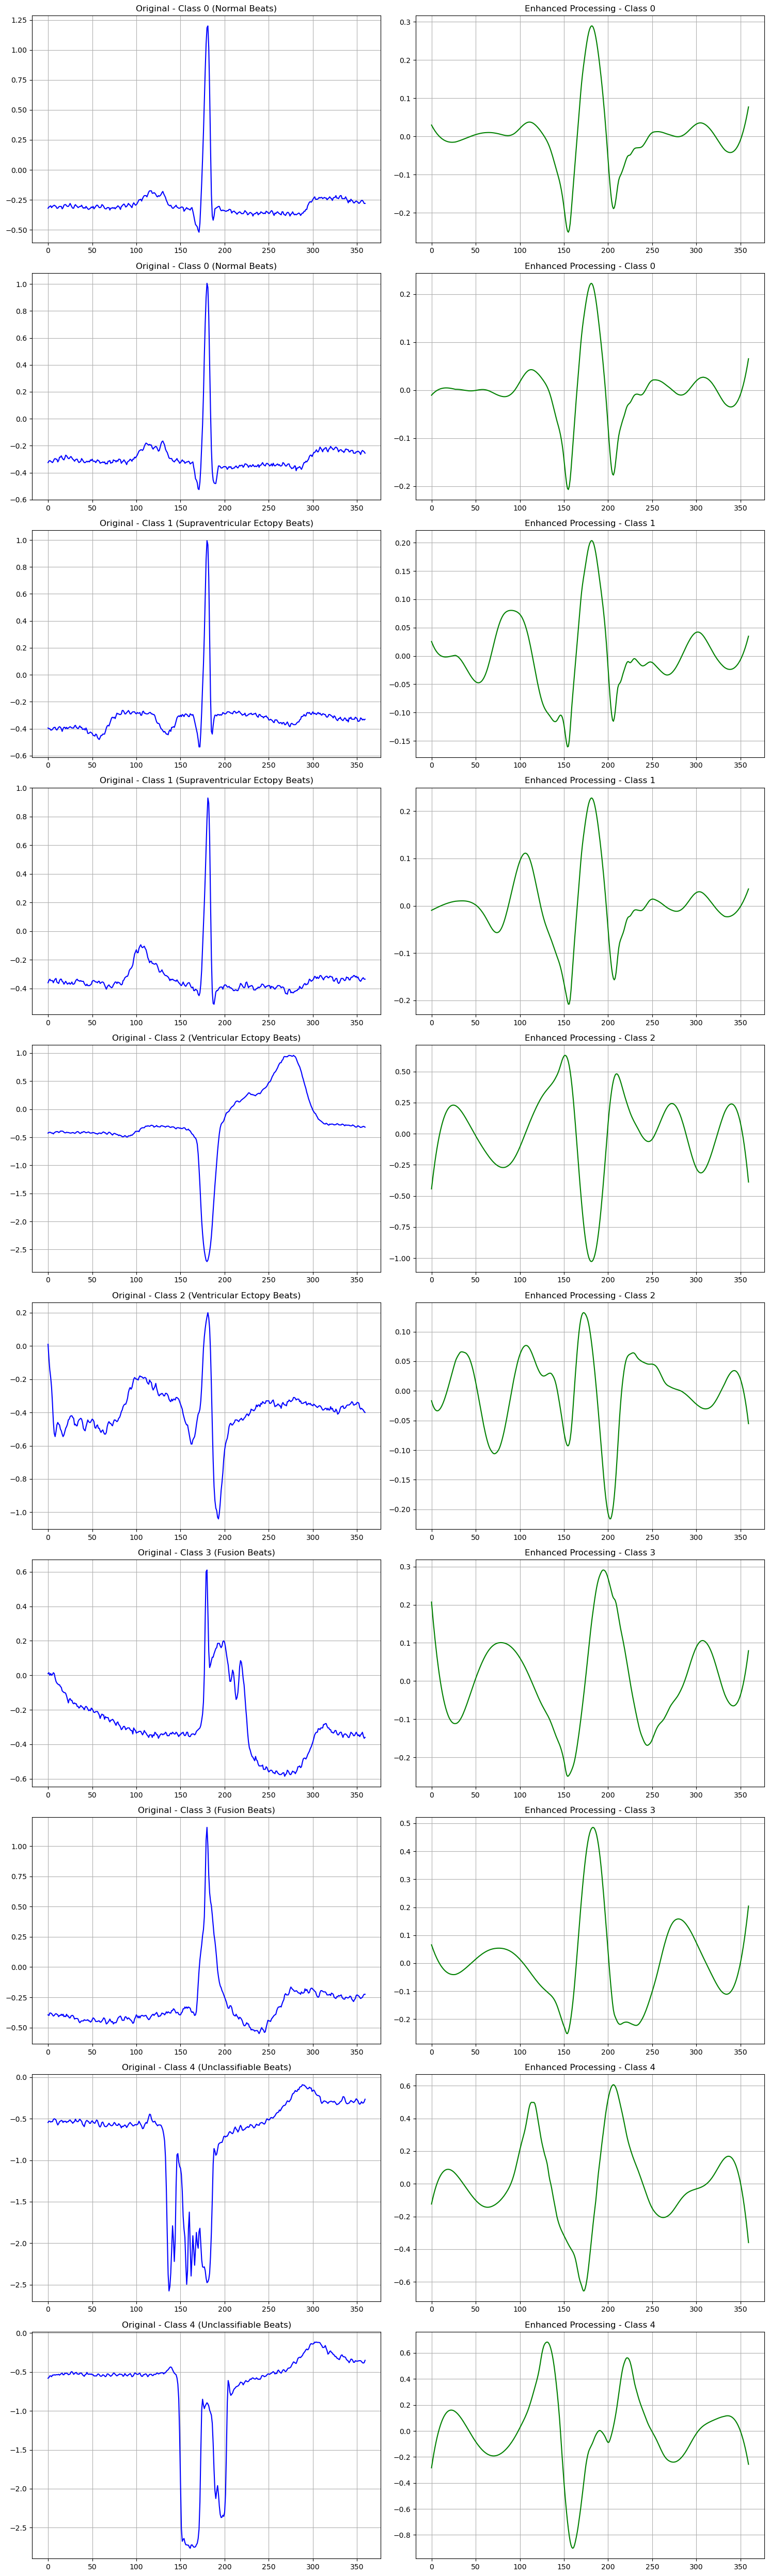

In [18]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy.polynomial import polynomial as P

# Load data
resampled_signals_by_label = np.load('resampled_signals_by_label.npy', allow_pickle=True).item()

class_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

def polynomial_detrend(signal, degree=6):
    """
    Apply polynomial detrending to the signal
    
    Parameters:
    signal: numpy array containing an ECG signal
    degree: Degree of the polynomial used for detrending
    
    Returns:
    Detrended signal
    """
    x = np.arange(len(signal))
    coeffs = P.polyfit(x, signal, degree)
    polynomial_trend = P.polyval(x, coeffs)
    return signal - polynomial_trend

def wavelet_denoise(signal, wavelet='db6', level=4):
    """
    Apply DWT denoising to the signal using db6 wavelet with 35% threshold
    
    Parameters:
    signal: numpy array containing an ECG signal
    wavelet: Wavelet family to use
    level: Decomposition level
    
    Returns:
    Denoised signal
    """
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Apply 35% threshold to detail coefficients
    for i in range(1, len(coeffs)):
        # Calculate threshold as 35% of maximum coefficient value
        threshold = 0.35 * np.max(np.abs(coeffs[i]))
        
        # Apply soft thresholding
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    
    # Reconstruct signal
    denoised = pywt.waverec(coeffs, wavelet)
    
    # Adjust length if needed
    if len(denoised) > len(signal):
        denoised = denoised[:len(signal)]
    
    return denoised
    
def simplified_processing(signal, sampling_rate=360):
    """
    Apply enhanced processing to ECG signal:
    1. Wavelet denoising with db6 wavelet
    2. Polynomial detrending
    3. Savitzky-Golay filtering
    
    Parameters:
    signal: numpy array containing an ECG signal
    sampling_rate: Sampling rate in Hz
    
    Returns:
    Processed signal
    """
    # Extract one lead if we have a 2D array
    if isinstance(signal, np.ndarray) and len(signal.shape) > 1:
        # Process lead 1 (index 0) - MLII in MIT-BIH
        signal_1d = signal[:, 0]
    else:
        signal_1d = signal
    
    # 1. Apply wavelet denoising with db6 wavelet, level 4
    denoised = wavelet_denoise(signal_1d, wavelet='db6', level=4)
    
    # 2. Apply polynomial detrending with degree 6
    detrended = polynomial_detrend(denoised, degree=6)
    
    # 3. Apply Savitzky-Golay filter for additional smoothing
    # Window length should be odd and approximately 0.1-0.2 seconds of signal
    window_length = int(0.15 * sampling_rate)
    # Make window length odd if it's even
    if window_length % 2 == 0:
        window_length += 1
    # Polynomial order (usually 2-4 works well for ECG)
    polyorder = 3
    filtered = savgol_filter(detrended, window_length, polyorder)
    
    # If the original signal was 2D, rebuild the processed signal with both leads
    if isinstance(signal, np.ndarray) and len(signal.shape) > 1:
        # Create copy of original signal
        processed_signal = signal.copy()
        # Replace lead 1 with processed version
        processed_signal[:, 0] = filtered
        return processed_signal
    else:
        return filtered

# Function to prepare data for processing
def prepare_data_for_processing(resampled_signals_by_label):
    X = []
    y = []
    
    # Process each class
    for label, segments in resampled_signals_by_label.items():
        for segment_info in segments:
            # Extract the signal
            signal = segment_info['signal']
            X.append(signal)
            y.append(label)
    
    # Convert to numpy arrays
    X = np.array(X, dtype=object)  # Use object dtype because signals might have different lengths
    y = np.array(y)
    
    return X, y

# Function to safely extract signal data - handles both 1D and 2D signals
def safe_extract_signal(signal):
    """
    Safely extract the signal data for plotting, handling both 1D and 2D arrays
    
    Parameters:
    signal: numpy array containing an ECG signal (either 1D or 2D)
    
    Returns:
    1D array of signal data
    """
    if isinstance(signal, np.ndarray) and len(signal.shape) > 1:
        return signal[:, 0]  # Return first lead
    else:
        return signal  # Already 1D

# Updated processing function
def process_all_signals(X, y):
    processed_X = []
    total_signals = len(X)
    
    print(f"\nProcessing {total_signals} ECG signals...")
    
    for idx, signal in enumerate(X):
        if idx % 100 == 0:
            print(f"Processing signal {idx}/{total_signals}...")
        
        # Process the signal with enhanced method
        processed = simplified_processing(signal, sampling_rate=360)
        processed_X.append(processed)
    
    print(f"Completed processing all {total_signals} signals.")
    
    return processed_X

# Updated plotting function to safely handle both 1D and 2D signals
def plot_comparison(X, processed_X, y, num_examples=2, classes_to_plot=None):
    if y is None:
        raise ValueError("Labels (y) must be provided for comparison")
    
    if classes_to_plot is None:
        classes_to_plot = sorted(np.unique(y))
    
    # Plot comparison
    plt.figure(figsize=(15, 5 * len(classes_to_plot) * num_examples))
    
    row = 0
    for class_id in classes_to_plot:
        # Find indices of this class
        class_indices = np.where(y == class_id)[0]
        
        if len(class_indices) > 0:
            # Select first few examples
            examples = class_indices[:num_examples]
            
            for i, idx in enumerate(examples):
                row += 1
                
                # Original signal - safely extract 1D signal for plotting
                plt.subplot(len(classes_to_plot) * num_examples, 2, 2*row-1)
                original_signal = safe_extract_signal(X[idx])
                plt.plot(original_signal, 'b-')
                plt.title(f"Original - Class {class_id} ({class_names[class_id]})")
                plt.grid(True)
                
                # Enhanced processed signal - safely extract 1D signal for plotting
                plt.subplot(len(classes_to_plot) * num_examples, 2, 2*row)
                processed_signal = safe_extract_signal(processed_X[idx])
                plt.plot(processed_signal, 'g-')
                plt.title(f"Enhanced Processing - Class {class_id}")
                plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('ecg_signal_enhanced_processing.png')
    plt.show()

if __name__ == "__main__":
    # Step 1: Prepare data for processing
    X, y = prepare_data_for_processing(resampled_signals_by_label)
    
    # Step 2: Process all signals with enhanced method
    processed_X = process_all_signals(X, y)
    
    # Step 3: Plot comparison of original vs enhanced processed signals
    plot_comparison(X, processed_X, y, num_examples=2)

In [20]:
from scipy.signal import medfilt, find_peaks
sampling_rate = 360
# Method 1: Direct peak detection with SciPy find_peaks
def detect_r_peaks_scipy(signal, sampling_rate=360):
    """
    Detect R-peaks using SciPy's find_peaks function.
    Parameters:
    signal: numpy array containing the ECG signal
    sampling_rate: Sampling rate in Hz
    Returns:
    R-peak locations as a numpy array
    """
    # Calculate minimum distance between peaks (typically 200ms between heartbeats)
    min_distance = int(0.2 * sampling_rate)
    # Dynamically determine height threshold (adjust percentile as needed)
    # Using 75th percentile works well for most ECG signals
    height_threshold = np.percentile(signal, 75)
    # Find peaks
    peaks, _ = find_peaks(signal, height=height_threshold, distance=min_distance)
    return peaks

# Method 2: Windowed maximum search - improved precision for R-peaks
def improve_r_peaks(signal, detected_peaks, window_size=10):
    """
    Improve R-peak locations by finding local maximum around detected peaks.
    Parameters:
    signal: numpy array containing the ECG signal
    detected_peaks: Initial peak locations
    window_size: Search window size in samples (each direction)
    Returns:
    Improved R-peak locations
    """
    improved_peaks = []
    for peak in detected_peaks:
        # Define search window boundaries
        left_bound = max(0, peak - window_size)
        right_bound = min(len(signal) - 1, peak + window_size)
        # Find local maximum within window
        window = signal[left_bound:right_bound + 1]
        max_idx = np.argmax(window)
        # Convert back to original signal index
        improved_peak = left_bound + max_idx
        improved_peaks.append(improved_peak)
    return np.array(improved_peaks)

# Method 3: Combined approach with adaptive thresholding
def detect_r_peaks_adaptive(signal, sampling_rate=360):
    """
    Advanced R-peak detection with adaptive thresholding.
    Parameters:
    signal: numpy array containing the ECG signal
    sampling_rate: Sampling rate in Hz
    Returns:
    R-peak locations as a numpy array
    """
    # Calculate signal metrics for adaptive threshold
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    # Set dynamic parameters
    min_distance = int(0.2 * sampling_rate)  # Minimum 200ms between peaks
    # Adaptive height threshold based on signal statistics
    height_threshold = signal_mean + 1.5 * signal_std
    # Prominence helps identify significant peaks (adjust as needed)
    prominence = 0.3 * (np.max(signal) - np.min(signal))
    # Find peaks with better parameters
    peaks, _ = find_peaks(signal,
                         height=height_threshold,
                         distance=min_distance,
                         prominence=prominence)
    return peaks

if __name__ == "__main__":
    total_signals = len(processed_X)
    print(f"\nDetecting R-peaks with improved methods on {total_signals} signals...")
    
    # Lists to store R-peaks
    signal_r_peaks = []
    
    # Process each signal to detect R-peaks
    for idx, signal in enumerate(processed_X):
        if idx % 100 == 0:
            print(f"Processing signal {idx}/{total_signals}...")
            
        # For 2D signals, use the first lead (column 0)
        if len(signal.shape) > 1:
            signal_1d = signal[:, 0]
        else:
            signal_1d = signal
            
        # METODE 1: Deteksi puncak langsung dengan SciPy
        initial_peaks = detect_r_peaks_scipy(signal_1d, sampling_rate)
        
        # METODE 2: Perbaiki posisi puncak dengan pencarian lokal
        r_peaks = improve_r_peaks(signal_1d, initial_peaks, window_size=5)
        
        # Alternatif: gunakan metode adaptif jika hasilnya lebih baik
        r_peaks = detect_r_peaks_adaptive(signal_1d, sampling_rate)
        
        # Store the peaks for this signal
        signal_r_peaks.append(r_peaks)
    
    print(f"Completed R-peak detection for all {total_signals} signals.")


Detecting R-peaks with improved methods on 2500 signals...
Processing signal 0/2500...
Processing signal 100/2500...
Processing signal 200/2500...
Processing signal 300/2500...
Processing signal 400/2500...
Processing signal 500/2500...
Processing signal 600/2500...
Processing signal 700/2500...
Processing signal 800/2500...
Processing signal 900/2500...
Processing signal 1000/2500...
Processing signal 1100/2500...
Processing signal 1200/2500...
Processing signal 1300/2500...
Processing signal 1400/2500...
Processing signal 1500/2500...
Processing signal 1600/2500...
Processing signal 1700/2500...
Processing signal 1800/2500...
Processing signal 1900/2500...
Processing signal 2000/2500...
Processing signal 2100/2500...
Processing signal 2200/2500...
Processing signal 2300/2500...
Processing signal 2400/2500...
Completed R-peak detection for all 2500 signals.


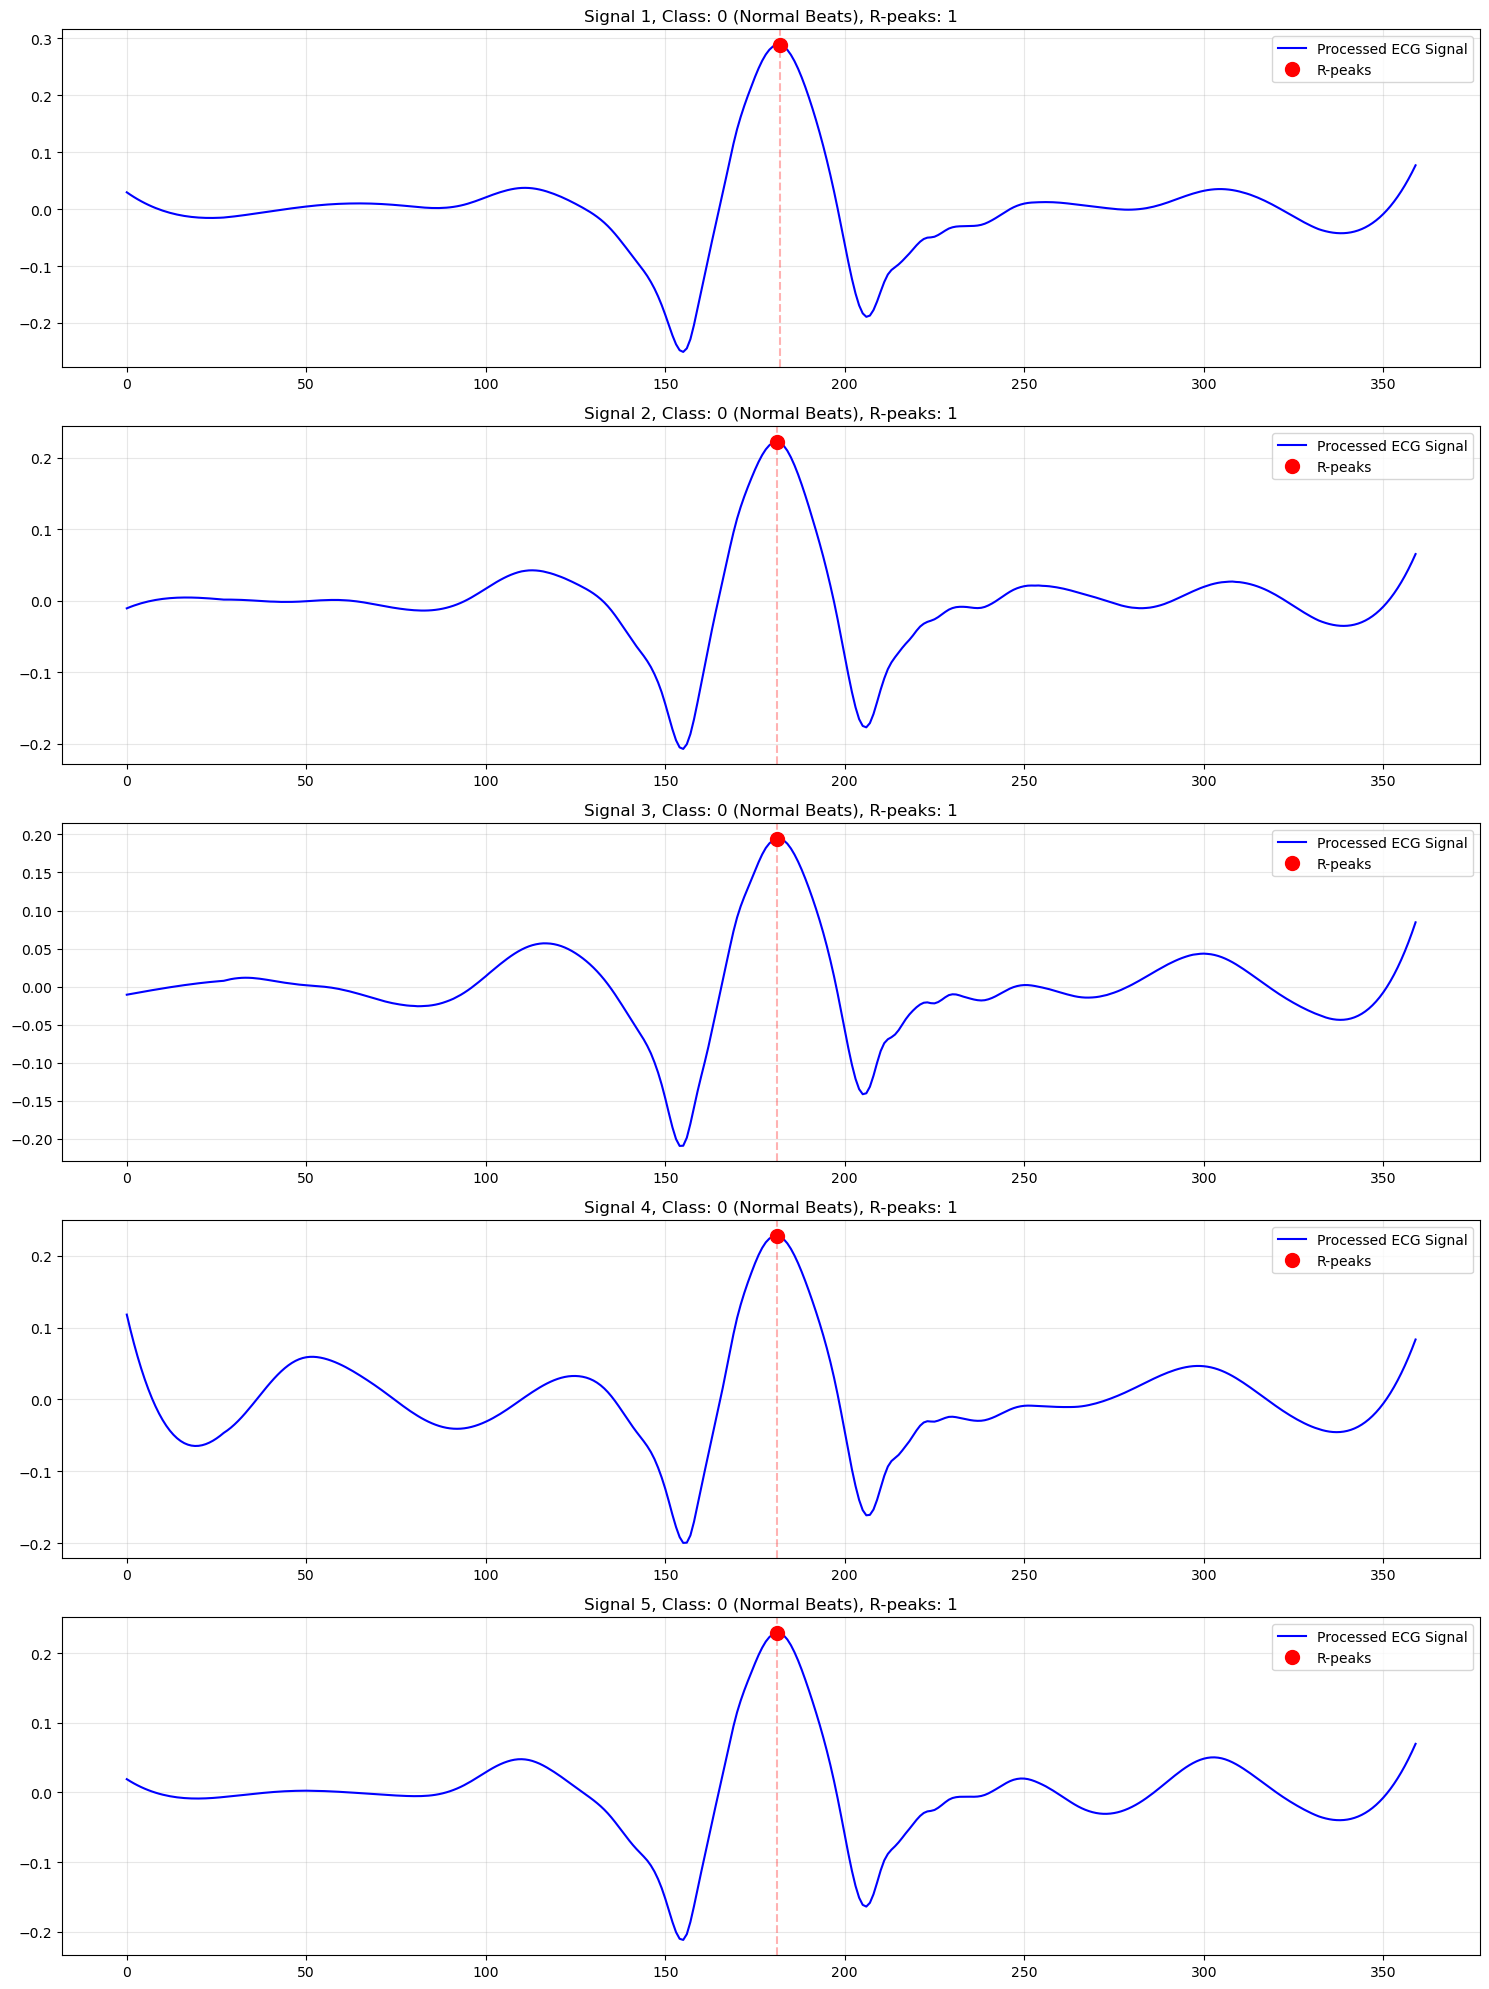

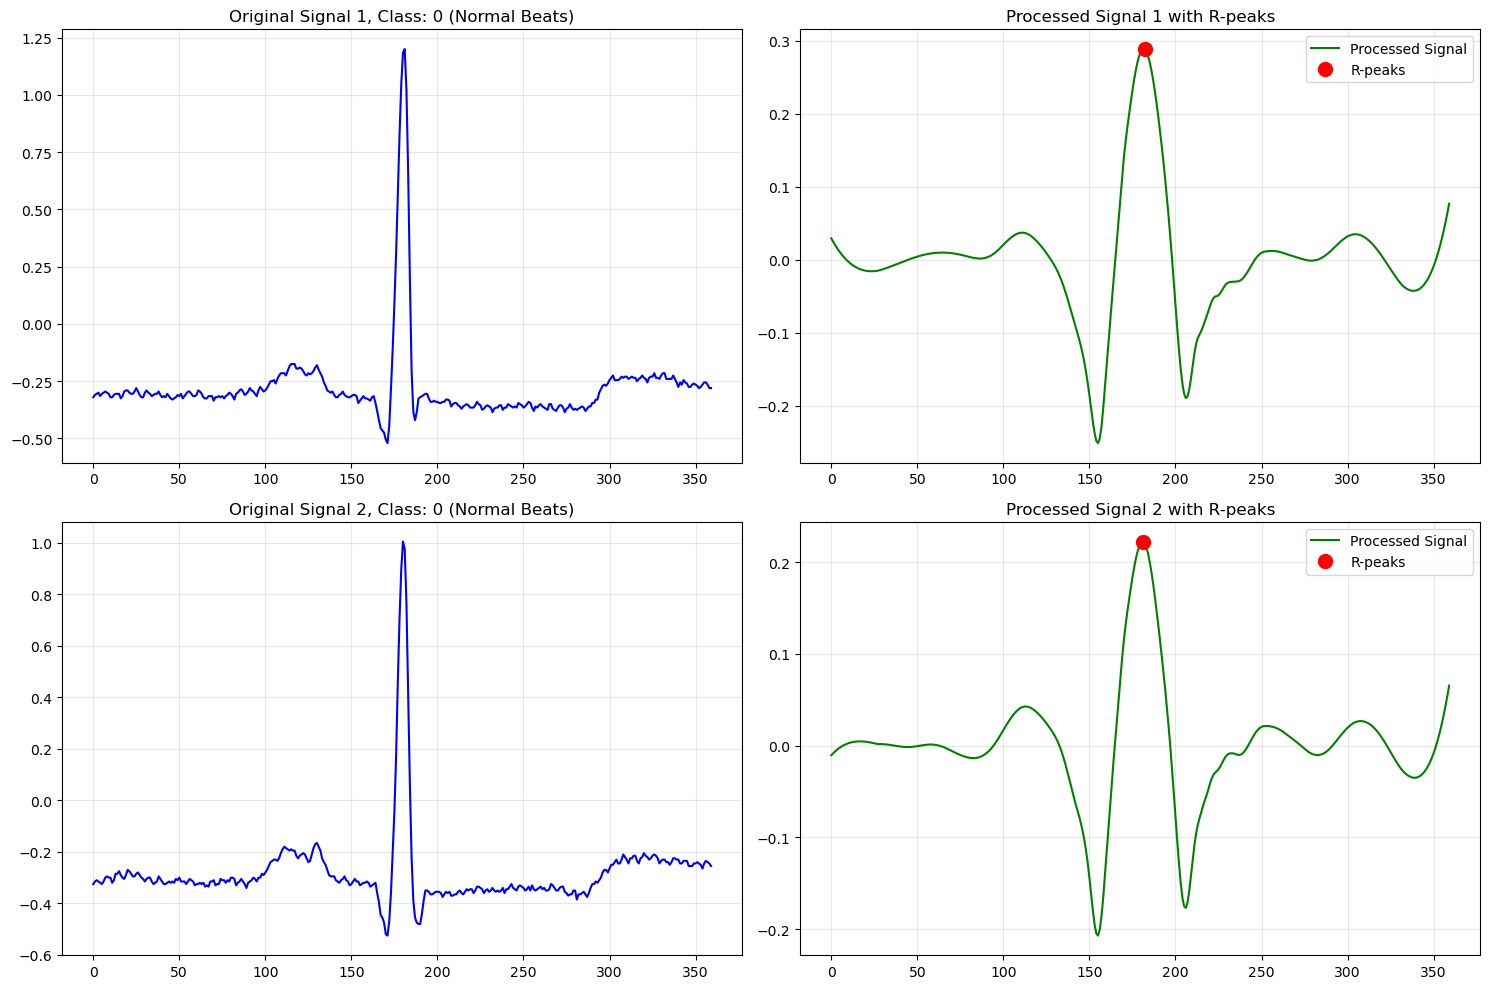

In [22]:
# Step 5: Plot signals with improved R-peaks detection
num_signals_to_plot = 5
plt.figure(figsize=(15, 4 * num_signals_to_plot))

for i in range(min(num_signals_to_plot, len(processed_X))):
    plt.subplot(num_signals_to_plot, 1, i + 1)

    # Get the processed signal
    signal = processed_X[i]

    # For 2D signals, use the first lead (column 0)
    if len(signal.shape) > 1:
        signal_1d = signal[:, 0]
    else:
        signal_1d = signal

    r_peaks = signal_r_peaks[i]

    # Plot the processed signal
    plt.plot(signal_1d, 'b-', label='Processed ECG Signal')

    # Plot the R-peaks with larger markers
    plt.plot(r_peaks, signal_1d[r_peaks], 'ro', markersize=10, label='R-peaks')

    # Highlight R-peak positions with vertical lines
    for rp in r_peaks:
        plt.axvline(x=rp, color='r', linestyle='--', alpha=0.3)

    plt.title(f"Signal {i+1}, Class: {y[i]} ({class_names[y[i]]}), R-peaks: {len(r_peaks)}")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ecg_signals_with_improved_rpeaks.png', dpi=300)
plt.show()


# Step 6: Plot original vs processed with R-peaks
plt.figure(figsize=(15, 10))

for i in range(min(2, len(processed_X))):
    # Original signal
    plt.subplot(2, 2, 2 * i + 1)

    # Get the original signal
    original_signal = X[i]

    # For 2D signals, use the first lead (column 0)
    if len(original_signal.shape) > 1:
        original_signal_1d = original_signal[:, 0]
    else:
        original_signal_1d = original_signal

    plt.plot(original_signal_1d, 'b-', label='Original Signal')
    plt.title(f"Original Signal {i+1}, Class: {y[i]} ({class_names[y[i]]})")
    plt.grid(True, alpha=0.3)

    # Processed signal with R-peaks
    plt.subplot(2, 2, 2 * i + 2)

    # Get the processed signal
    processed_signal = processed_X[i]

    # For 2D signals, use the first lead (column 0)
    if len(processed_signal.shape) > 1:
        processed_signal_1d = processed_signal[:, 0]
    else:
        processed_signal_1d = processed_signal

    r_peaks = signal_r_peaks[i]

    plt.plot(processed_signal_1d, 'g-', label='Processed Signal')
    plt.plot(r_peaks, processed_signal_1d[r_peaks], 'ro', markersize=10, label='R-peaks')
    plt.title(f"Processed Signal {i+1} with R-peaks")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('original_vs_processed_with_rpeaks.png', dpi=300)
plt.show()

Starting ECG processing and PQRST segmentation...
Number of signals: 2500
Number of r_peaks lists: 2500
Processing signal 0, number of r_peaks: 1
R peak with highest amplitude: index 182, value 0.28880826236172574
Using default RR interval: 72.0
QRS complex detected - Q: 155, R: 182, S: 206
P-wave search window: [11, 150] (width: 144ms)
Class 0: Selected P peak at 111, score 0.497
P wave peak detected at index: 111
T wave peak detected at index: 305
Modified segment boundaries: P start=110, T end=322
Found zero crossing after T at position 243, flatlining signal
Segment length: 213, after resampling: 250
Processing signal 1, number of r_peaks: 1
R peak with highest amplitude: index 181, value 0.2224874507806034
Using default RR interval: 72.0
QRS complex detected - Q: 155, R: 181, S: 206
P-wave search window: [11, 150] (width: 144ms)
Class 0: Selected P peak at 113, score 0.476
P wave peak detected at index: 113
T wave peak detected at index: 308
Modified segment boundaries: P start=11

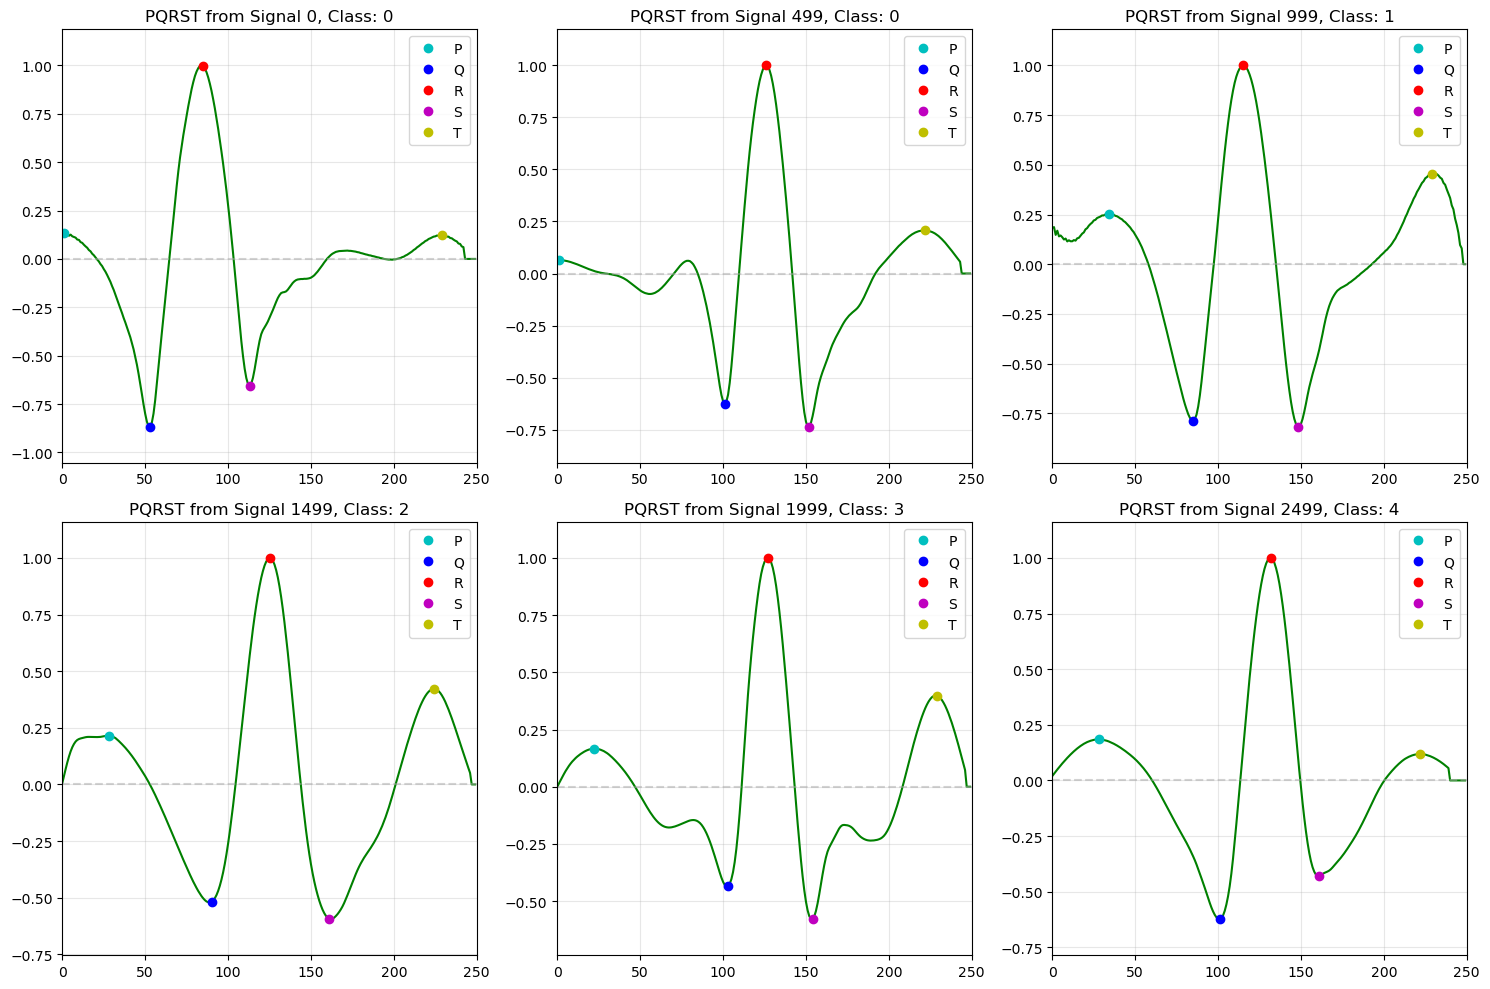


Total PQRST segments extracted: 2469
Total signals skipped: 31
Shape of segments array: (2469, 250)
Distribution of classes: (array([0, 1, 2, 3, 4]), array([500, 497, 496, 500, 476], dtype=int64))

PQRST segments saved to 'pqrst_segments.npy'
Corresponding labels saved to 'segment_labels.npy'
PQRST points saved to 'pqrst_points.npz'
Completed PQRST segmentation. Extracted 2469 segments.


In [23]:
import numpy as np
from scipy import signal as sig
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def safe_plot(plt_obj, x, y_array, *args, len_check=None, **kwargs):
    """Safely plot a point, checking if index is within bounds."""
    if len_check is None:
        len_check = len(y_array)
    
    x_int = int(np.round(x))
    if 0 <= x_int < len_check:
        y_val = y_array[x_int]
        plt_obj.plot(x_int, y_val, *args, **kwargs)

def segment_and_plot_pqrst(processed_signals, sampling_rate, signal_r_peaks=None, class_labels=None, max_plots=12):
    """
    Extract PQRST segments from processed ECG signals and plot examples.
    Modified to extract segments starting exactly at the P wave for Class 0 (normal ECG),
    and to terminate the signal at baseline (0) immediately after T wave.
    
    Parameters:
    processed_signals: List or numpy array of processed ECG signals
    sampling_rate: Sampling rate in Hz
    signal_r_peaks: List of R-peak indices for each signal (if None, will be detected)
    class_labels: List of class labels for each signal (if None, defaults to 0)
    max_plots: Maximum number of example plots to show
    
    Returns:
    segments: Numpy array of standardized PQRST segments
    segment_labels: Numpy array of corresponding class labels
    """
    from scipy.signal import find_peaks
    
    print(f"Number of signals: {len(processed_signals)}")
    
    # If R-peaks are not provided, detect them
    if signal_r_peaks is None:
        signal_r_peaks = []
        
        for signal in processed_signals:
            # For 2D signals, use the second lead (column 1)
            if len(signal.shape) > 1:
                signal_1d = signal[:, 1]
            else:
                signal_1d = signal
                
            # Simple R-peak detection
            height_threshold = np.percentile(signal_1d, 75)
            min_distance = int(0.2 * sampling_rate)
            peaks, _ = find_peaks(signal_1d, height=height_threshold, distance=min_distance)
            signal_r_peaks.append(peaks)
    
    print(f"Number of r_peaks lists: {len(signal_r_peaks)}")

    # If class labels are not provided, set default to 0
    if class_labels is None:
        class_labels = [0.0] * len(processed_signals)

    # Limit number of signals to plot
    n_signals_to_plot = min(max_plots, len(processed_signals))
    selected_indices = np.linspace(0, len(processed_signals) - 1, n_signals_to_plot, dtype=int)

    # Create plot grid
    n_cols = 3
    n_rows = (n_signals_to_plot + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 5 * n_rows))

    segments = []  # List to store all segments
    segment_labels = []  # List to store class labels for segments
    standardized_length = 250  # Standard length for all segments

    # Store detected points for all segments
    all_p_points = []
    all_q_points = []
    all_r_points = []
    all_s_points = []
    all_t_points = []

    # Plot counter
    plot_counter = 1

    # Track signals that would have been skipped
    skipped_signals = 0

    # Process each signal
    for i, processed_signal in enumerate(processed_signals):
        # For 2D signals, use the second lead (column 1)
        if len(processed_signal.shape) > 1:
            processed_signal = processed_signal[:, 0]
            
        # Get R-peaks for this signal
        r_peaks = signal_r_peaks[i]
        
        print(f"Processing signal {i}, number of r_peaks: {len(r_peaks)}")

        # Get class label
        label = class_labels[i]
        
        # If no R-peaks found, skip this signal
        if len(r_peaks) == 0:
            print(f"No R peaks found for signal {i} - skipping")
            skipped_signals += 1
            continue
            
        # Find R-peak with highest amplitude
        max_amplitude = -float('inf')
        max_r_peak = None

        for peak in r_peaks:
            if 0 <= peak < len(processed_signal):
                amp = processed_signal[peak]
                if amp > max_amplitude:
                    max_amplitude = amp
                    max_r_peak = peak

        # If no valid R-peak, skip this signal
        if max_r_peak is None:
            print(f"No valid R peak for signal {i} - skipping")
            skipped_signals += 1
            continue
        
        print(f"R peak with highest amplitude: index {max_r_peak}, value {max_amplitude}")

        # Calculate RR intervals for window size determination
        if len(r_peaks) > 1:
            rr_intervals = np.ceil(np.median(np.diff(r_peaks)))
            print(f"RR interval: {rr_intervals}")
        else:
            rr_intervals = np.ceil(0.2 * sampling_rate)  # Default if can't calculate
            print(f"Using default RR interval: {rr_intervals}")

        # ---- QRS DETECTION AROUND R-PEAK ----
        # Define initial window around R-peak for detecting QRS complex
        q_search_window = int(0.1 * sampling_rate)  # ~100ms for Q-wave search
        s_search_window = int(0.1 * sampling_rate)  # ~100ms for S-wave search

        # Ensure search windows are within signal bounds
        q_start = max(0, max_r_peak - q_search_window)
        s_end = min(len(processed_signal) - 1, max_r_peak + s_search_window)

        # Extract signal segments for Q and S detection
        q_segment = processed_signal[q_start:max_r_peak]
        s_segment = processed_signal[max_r_peak:s_end+1]

        # Find Q point (minimum in the window before R-peak)
        if len(q_segment) > 0:
            q_point_idx = q_start + np.argmin(q_segment)
        else:
            q_point_idx = max_r_peak

        # Find S point (minimum in the window after R-peak)
        if len(s_segment) > 0:
            s_point_idx = max_r_peak + np.argmin(s_segment)
        else:
            s_point_idx = max_r_peak

        print(f"QRS complex detected - Q: {q_point_idx}, R: {max_r_peak}, S: {s_point_idx}")

        # ---- ENHANCED P WAVE DETECTION WITH WIDER SEARCH WINDOW FOR CLASS 0 ----
        # Increase P wave search window for Class 0 (normal ECG)
        if label == 0:  # Normal ECG
            # Much wider search window for Class 0
            p_search_window = int(0.4 * sampling_rate)  # Extend to 400ms for normal ECG
        else:
            p_search_window = int(0.25 * sampling_rate)  # Standard 250ms for other classes
        
        p_search_start = max(0, q_point_idx - p_search_window)
        p_search_end = max(p_search_start + 5, q_point_idx - int(0.015 * sampling_rate))
        
        print(f"P-wave search window: [{p_search_start}, {p_search_end}] (width: {p_search_window}ms)")
        
        # Extract signal segment for P wave detection
        p_segment = processed_signal[p_search_start:p_search_end] if p_search_end > p_search_start else np.array([])
        
        # Default p_peak_idx in case detection fails
        p_peak_idx = max(0, q_point_idx - int(0.16 * sampling_rate))  # Default: 160ms before Q
        
        # --- P Wave Detection ---
        if len(p_segment) > 3:
            # Class-specific processing for P wave
            if label == 0:  # For normal ECG (class 0), more aggressive P wave detection
                # Apply smoother filtering for normal ECG
                smooth_win = min(11, len(p_segment) if len(p_segment) % 2 == 1 else len(p_segment) - 1)
                if smooth_win >= 3:  # Need at least 3 points for filtering
                    try:
                        smoothed_p = sig.savgol_filter(p_segment, smooth_win, 2)
                    except Exception:
                        smoothed_p = p_segment  # Use original if filtering fails
                else:
                    smoothed_p = p_segment
                
                # For normal ECG, look for prominent peak further from Q
                try:
                    # Find peaks with lower prominence threshold for normal ECG
                    peaks, props = find_peaks(smoothed_p, prominence=0.01, width=2, distance=int(0.05*sampling_rate))
                    
                    if len(peaks) > 0:
                        # For normal ECG, prioritize peaks further from Q point
                        # Calculate ideal P wave position (around 160-200ms before Q)
                        ideal_p_distance = int(0.18 * sampling_rate)  # ~180ms before Q
                        
                        best_peak_idx = -1
                        best_score = -float('inf')
                        
                        for idx, (peak, prom) in enumerate(zip(peaks, props['prominences'])):
                            # Calculate position score (prefer peaks at ideal distance from Q)
                            pos = p_search_start + peak
                            distance_from_q = q_point_idx - pos
                            pos_score = 1.0 - abs(distance_from_q - ideal_p_distance) / ideal_p_distance
                            
                            # Combined score favoring prominence and good position
                            # Weight position more heavily for Class 0
                            score = (0.3 * prom) + (0.7 * pos_score)
                            
                            if score > best_score:
                                best_score = score
                                best_peak_idx = idx
                        
                        if best_peak_idx >= 0:
                            p_peak_idx = p_search_start + peaks[best_peak_idx]
                            print(f"Class 0: Selected P peak at {p_peak_idx}, score {best_score:.3f}")
                        else:
                            # Fallback if no suitable peaks
                            p_peak_idx = max(0, q_point_idx - ideal_p_distance)
                            print(f"Class 0: Using ideal position at {p_peak_idx} (no suitable peaks)")
                    else:
                        # If no peaks found, look for local maximum at ideal position
                        ideal_p_pos = min(len(smoothed_p)-1, int(0.18 * sampling_rate))
                        p_peak_idx = p_search_start + ideal_p_pos
                        print(f"Class 0: Using ideal position at {p_peak_idx} (no peaks found)")
                        
                except Exception as e:
                    print(f"Error in Class 0 P wave detection: {e}")
                    # For exceptional cases, place P wave at physiological position
                    p_peak_idx = max(0, q_point_idx - int(0.18 * sampling_rate))
            else:
                # For non-normal ECGs, use more conservative detection
                try:
                    smooth_win = min(7, len(p_segment) if len(p_segment) % 2 == 1 else len(p_segment) - 1)
                    if smooth_win >= 3:
                        smoothed_p = sig.savgol_filter(p_segment, smooth_win, 2)
                    else:
                        smoothed_p = p_segment
                    
                    # Find peaks with higher prominence threshold for abnormal ECG
                    peaks, props = find_peaks(smoothed_p, prominence=0.05, width=2)
                    
                    if len(peaks) > 0:
                        # For abnormal ECG, select the most prominent peak
                        max_prom_idx = np.argmax(props['prominences'])
                        p_peak_idx = p_search_start + peaks[max_prom_idx]
                    else:
                        # If no prominent peaks, use the maximum value point
                        p_peak_idx = p_search_start + np.argmax(smoothed_p)
                except Exception:
                    # Fallback: place P wave at standard position
                    p_peak_idx = max(0, q_point_idx - int(0.16 * sampling_rate))
        else:
            # For very short segments, use standard position
            p_peak_idx = max(0, q_point_idx - int(0.16 * sampling_rate))
            
        print(f"P wave peak detected at index: {p_peak_idx}")

        # ---- T WAVE DETECTION ----
        # T wave typically occurs within 160-300ms after R-peak
        t_search_start = s_point_idx
        t_search_end = min(len(processed_signal) - 1, s_point_idx + int(0.3 * sampling_rate))

        # Extract signal segment for T detection
        t_segment = processed_signal[t_search_start:t_search_end+1]

        # Find T wave peak
        if len(t_segment) > 0:
            # Look for local maxima in the T-wave search window
            t_peaks, _ = find_peaks(t_segment, distance=int(0.05 * sampling_rate))

            if len(t_peaks) > 0:
                # Select the peak with highest amplitude
                t_peak_idx = t_search_start + t_peaks[np.argmax(t_segment[t_peaks])]
            else:
                # If no peaks found, use the maximum value in the window
                t_peak_idx = t_search_start + np.argmax(t_segment)
        else:
            t_peak_idx = t_search_start

        print(f"T wave peak detected at index: {t_peak_idx}")

        # ---- Set P start as precise segment start boundary ----
        # Calculate baseline
        baseline = np.mean(processed_signal)
        
        # Find P start point (beginning of the P wave)
        # For Class 0, use a much earlier starting point to ensure P is clearly visible
        if label == 0:
            # For normal ECG, look further back from P peak
            p_start_search = max(0, p_peak_idx - int(0.1 * sampling_rate))  # 100ms before P peak
        else:
            p_start_search = max(0, p_peak_idx - int(0.08 * sampling_rate))  # 80ms before P peak
        
        # Initialize p_start to search start by default
        p_start_idx = p_start_search
        
        # Look backward from P peak for rising edge or crossing baseline
        for j in range(p_peak_idx-1, p_start_search-1, -1):
            if j < 1:  # Ensure we don't go below index 0
                p_start_idx = 0
                break
                
            # For Class 0, be more precise about finding the exact P onset
            if label == 0:
                # First-order derivative for finding slope changes
                if j > 0 and abs(processed_signal[j] - processed_signal[j-1]) < 0.01:
                    p_start_idx = j
                    break
                    
                # Or if we find a point where signal crosses baseline
                if (processed_signal[j] - baseline) * (processed_signal[j+1] - baseline) <= 0:
                    p_start_idx = j
                    break
            else:
                # For other classes, simpler baseline crossing detection
                if (processed_signal[j] - baseline) * (processed_signal[j+1] - baseline) <= 0:
                    p_start_idx = j
                    break
        
        # ---- Find T end ----
        # Search for the first time signal crosses baseline after T peak
        t_end_search = min(len(processed_signal)-1, t_peak_idx + int(0.2 * sampling_rate))
        
        t_end_idx = None
        # Look for where signal crosses baseline after T peak
        for j in range(t_peak_idx+1, t_end_search+1):
            # If we find a point where signal crosses baseline
            if (processed_signal[j-1] - baseline) * (processed_signal[j] - baseline) <= 0:
                t_end_idx = j
                break
        
        # If no zero crossing found, use the end of search window
        if t_end_idx is None:
            t_end_idx = t_end_search
        
        print(f"Modified segment boundaries: P start={p_start_idx}, T end={t_end_idx}")

        # Set segment boundaries to include exactly from P start to T end
        borderlow = p_start_idx
        borderhigh = t_end_idx
        
        # Ensure segment boundaries make sense
        if borderhigh <= borderlow:
            print(f"Warning: End point ({borderhigh}) is before or at start point ({borderlow}) for signal {i}")
            # Use points with reasonable extension instead of skipping
            borderlow = max(0, p_peak_idx - int(0.15 * sampling_rate))
            borderhigh = min(len(processed_signal)-1, t_peak_idx + int(0.15 * sampling_rate))
            print(f"Adjusting to reasonable boundaries: {borderlow} to {borderhigh}")
            
            # If boundaries still don't make sense, skip this signal
            if borderhigh <= borderlow:
                print(f"Still invalid boundaries - skipping signal {i}")
                skipped_signals += 1
                continue

        # Extract segment
        segment = processed_signal[borderlow:borderhigh+1]
        
        # Check if segment is too short, if so, skip it
        if len(segment) < 20:  # Arbitrary minimum length
            print(f"Segment too short ({len(segment)} samples) - skipping signal {i}")
            skipped_signals += 1
            continue
        
        # Store detected points for this segment (relative to segment start)
        p_relative = p_peak_idx - borderlow
        q_relative = q_point_idx - borderlow
        r_relative = max_r_peak - borderlow
        s_relative = s_point_idx - borderlow
        t_relative = t_peak_idx - borderlow

        # Ensure all points are within segment boundaries
        p_relative = max(0, min(p_relative, len(segment)-1))
        q_relative = max(0, min(q_relative, len(segment)-1))
        r_relative = max(0, min(r_relative, len(segment)-1))
        s_relative = max(0, min(s_relative, len(segment)-1))
        t_relative = max(0, min(t_relative, len(segment)-1))

        # Resample to get uniform length
        resampled_segment = sig.resample(segment, standardized_length)

        # Normalize
        normalized_segment = resampled_segment/np.max(np.abs(resampled_segment)) if np.max(np.abs(resampled_segment)) > 0 else resampled_segment

        # ---- Add a zero flatline at the end after T point ----
        # Calculate position of T point in normalized segment
        t_norm = t_relative / len(segment) * standardized_length
        t_norm_int = int(np.round(t_norm))
        
        # Find first zero crossing or minimum after T point
        zero_after_t = None
        for j in range(t_norm_int + 1, standardized_length):
            # Check for zero crossing
            if j > 0 and (normalized_segment[j-1] * normalized_segment[j] <= 0):
                zero_after_t = j
                break
            # Alternatively, check if we're very close to zero
            if abs(normalized_segment[j]) < 0.05:  # Using threshold of 0.05
                zero_after_t = j
                break
        
        # If we found a zero crossing after T, set rest of signal to zero
        if zero_after_t is not None:
            # Set everything after zero crossing to 0
            normalized_segment[zero_after_t:] = 0.0
            print(f"Found zero crossing after T at position {zero_after_t}, flatlining signal")
        else:
            # If no zero crossing found, set everything after T+20 points to zero
            cutoff_point = min(standardized_length-1, t_norm_int + 20)
            normalized_segment[cutoff_point:] = 0.0
            print(f"No zero crossing found, flatlining signal after T+20 at position {cutoff_point}")
        
        # Save segment and label
        segments.append(normalized_segment)
        segment_labels.append(label)

        # Store normalized points (scaled to resampled segment)
        p_norm = p_relative / len(segment) * standardized_length if len(segment) > 0 else 0.2 * standardized_length
        q_norm = q_relative / len(segment) * standardized_length if len(segment) > 0 else 0.35 * standardized_length
        r_norm = r_relative / len(segment) * standardized_length if len(segment) > 0 else 0.4 * standardized_length
        s_norm = s_relative / len(segment) * standardized_length if len(segment) > 0 else 0.45 * standardized_length

        all_p_points.append(p_norm)
        all_q_points.append(q_norm)
        all_r_points.append(r_norm)
        all_s_points.append(s_norm)
        all_t_points.append(t_norm)

        print(f"Segment length: {len(segment)}, after resampling: {len(normalized_segment)}")

        # Plot segment if this signal was selected for plotting
        if i in selected_indices:
            plt.subplot(n_rows, n_cols, plot_counter)
            plt.plot(normalized_segment, color='green', linewidth=1.5)
            
            # Plot baseline
            plt.axhline(y=0, color='darkgray', linestyle='--', alpha=0.5)

            # Plot markers for PQRST with safe plotting function
            safe_plot(plt, p_norm, normalized_segment, 'co', markersize=6, label='P', len_check=standardized_length)
            safe_plot(plt, q_norm, normalized_segment, 'bo', markersize=6, label='Q', len_check=standardized_length)
            safe_plot(plt, r_norm, normalized_segment, 'ro', markersize=6, label='R', len_check=standardized_length)
            safe_plot(plt, s_norm, normalized_segment, 'mo', markersize=6, label='S', len_check=standardized_length)
            safe_plot(plt, t_norm, normalized_segment, 'yo', markersize=6, label='T', len_check=standardized_length)

            plt.title(f"PQRST from Signal {i}, Class: {label}")
            plt.grid(True, alpha=0.3)
            plt.legend(loc='best')

            # Adjust y-axis range
            y_min, y_max = min(normalized_segment), max(normalized_segment)
            y_range = y_max - y_min
            plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

            # Set x-axis
            plt.xlim(0, len(normalized_segment))
            x_ticks = np.linspace(0, len(normalized_segment), 6)
            plt.xticks(x_ticks, [int(x) for x in x_ticks])

            plot_counter += 1

    plt.tight_layout()

    # Display plots
    print("Displaying plots...")
    plt.show(block=True)

    # Convert to numpy arrays
    segments = np.array(segments)
    segment_labels = np.array(segment_labels)

    # Also convert points arrays
    all_p_points = np.array(all_p_points)
    all_q_points = np.array(all_q_points)
    all_r_points = np.array(all_r_points)
    all_s_points = np.array(all_s_points)
    all_t_points = np.array(all_t_points)

    print(f"\nTotal PQRST segments extracted: {len(segments)}")
    print(f"Total signals skipped: {skipped_signals}")
    print(f"Shape of segments array: {segments.shape}")
    print(f"Distribution of classes: {np.unique(segment_labels, return_counts=True)}")

    # Save the segments for further analysis
    np.save('pqrst_segments.npy', segments)
    np.save('segment_labels.npy', segment_labels)

    # Save points information
    np.savez('pqrst_points.npz',
             p_points=all_p_points,
             q_points=all_q_points,
             r_points=all_r_points,
             s_points=all_s_points,
             t_points=all_t_points)

    print("\nPQRST segments saved to 'pqrst_segments.npy'")
    print("Corresponding labels saved to 'segment_labels.npy'")
    print("PQRST points saved to 'pqrst_points.npz'")

    return segments, segment_labels

# Example usage:
if __name__ == "__main__":
    print("Starting ECG processing and PQRST segmentation...")

    # Segment and plot PQRST complexes
    segments, labels = segment_and_plot_pqrst(processed_X, sampling_rate, signal_r_peaks, class_labels=y, max_plots=6)
    
    print(f"Completed PQRST segmentation. Extracted {len(segments)} segments.")

EKSTRAKSI FITUR


Extracting features using TSFEL...
Extracting TSFEL features for signal 0/2469...
Extracting TSFEL features for signal 100/2469...
Extracting TSFEL features for signal 200/2469...
Extracting TSFEL features for signal 300/2469...
Extracting TSFEL features for signal 400/2469...
Extracting TSFEL features for signal 500/2469...
Extracting TSFEL features for signal 600/2469...
Extracting TSFEL features for signal 700/2469...
Extracting TSFEL features for signal 800/2469...
Extracting TSFEL features for signal 900/2469...
Extracting TSFEL features for signal 1000/2469...
Extracting TSFEL features for signal 1100/2469...
Extracting TSFEL features for signal 1200/2469...
Extracting TSFEL features for signal 1300/2469...
Extracting TSFEL features for signal 1400/2469...
Extracting TSFEL features for signal 1500/2469...
Extracting TSFEL features for signal 1600/2469...
Extracting TSFEL features for signal 1700/2469...
Extracting TSFEL features for signal 1800/2469...
Extracting TSFEL features 

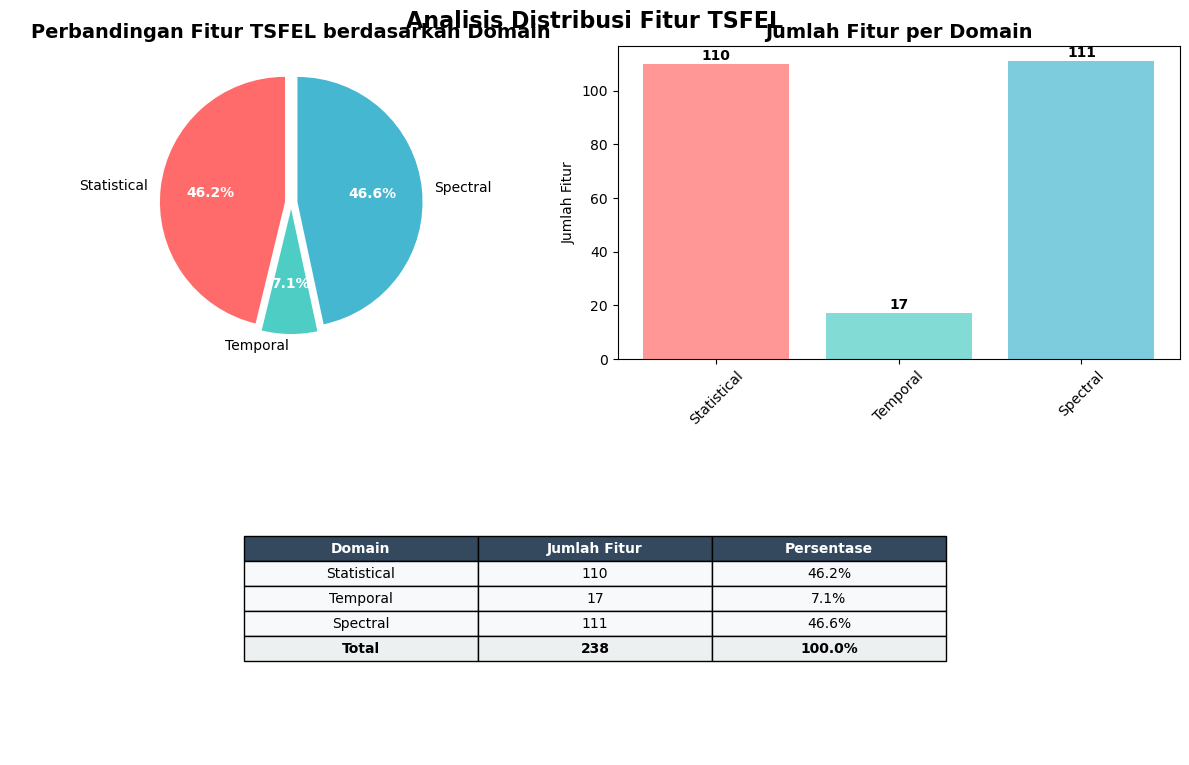


RINGKASAN DISTRIBUSI FITUR TSFEL
Total fitur yang diekstraksi: 238
------------------------------
Statistical : 110 fitur ( 46.2%)
Temporal    :  17 fitur (  7.1%)
Spectral    : 111 fitur ( 46.6%)
------------------------------
Total       : 238 fitur (100.0%)

Saving TSFEL features to CSV...
Feature extraction and visualization completed!
Files saved:
- tsfel_features.csv: Complete feature dataset
- tsfel_feature_distribution.csv: Feature distribution summary


In [25]:
import pandas as pd
import tsfel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\nExtracting features using TSFEL...")
# Get TSFEL configuration for all domains
cfg = tsfel.get_features_by_domain()

# Function to extract features using TSFEL
def extract_tsfel_features(signal):
    """Extract features from a signal using TSFEL"""
    try:
        # Extract all features using TSFEL
        features = tsfel.time_series_features_extractor(cfg, signal.reshape(-1, 1), fs=360, verbose=0)
        return features
    except Exception as e:
        print(f"Error in TSFEL extraction: {str(e)}")
        return None

# Function to categorize features by domain
def categorize_features_by_domain():
    """Categorize TSFEL features by domain (statistical, temporal, spectral)"""
    statistical_features = []
    temporal_features = []
    spectral_features = []
    
    # Get all features from TSFEL configuration
    for domain, features in cfg.items():
        if domain == 'statistical':
            statistical_features.extend(list(features.keys()))
        elif domain == 'temporal':
            temporal_features.extend(list(features.keys()))
        elif domain == 'spectral':
            spectral_features.extend(list(features.keys()))
    
    return {
        'Statistical': statistical_features,
        'Temporal': temporal_features,
        'Spectral': spectral_features
    }

# Get feature categorization
feature_categories = categorize_features_by_domain()

# Initialize the lists to store features and labels
all_features = []
all_labels = []

# Define total samples for progress tracking
total_samples = len(segments)

# Extract features for each processed signal pqrst
for i, signal in enumerate(segments):
    if i % 100 == 0:
        print(f"Extracting TSFEL features for signal {i}/{total_samples}...")
    try:
        # Skip None or empty signals
        if signal is None or len(signal) == 0:
            print(f"Skipping None/empty signal at index {i}")
            continue
        
        # Extract features
        features = extract_tsfel_features(signal)
        if features is not None:
            # Store features and label
            all_features.append(features)
            all_labels.append(labels[i])
    except Exception as e:
        print(f"Error extracting features for signal {i}: {str(e)}")
        continue

print(f"Completed feature extraction for {len(all_features)}/{total_samples} signals.")

# Check if we have any features
if len(all_features) == 0:
    print("No features were successfully extracted. Please check your signals.")
else:
    # Concatenate all feature dataframes
    tsfel_features_df = pd.concat(all_features, axis=0, ignore_index=True)
    
    # Handle potential NaN values
    tsfel_features_df = tsfel_features_df.fillna(0)  # Replace NaN with 0 or other appropriate value
    
    # Add labels
    tsfel_features_df['label'] = all_labels
    
    # Display information about extracted features
    print("\nTSFEL Features extracted:")
    print(f"Shape: {tsfel_features_df.shape}")
    print("Feature statistics:")
    print(tsfel_features_df.describe().transpose().head())
    
    # Check for infinite values
    if np.isinf(tsfel_features_df.values).any():
        print("Warning: Infinite values detected in features. Replacing with large values...")
        tsfel_features_df = tsfel_features_df.replace([np.inf, -np.inf], np.finfo(np.float64).max)
    
    # Count features by domain
    feature_counts = {}
    feature_names = [col for col in tsfel_features_df.columns if col != 'label']
    
    for domain, features in feature_categories.items():
        count = 0
        for feature in features:
            # Count features that contain the feature name (handles variations)
            count += sum(1 for fname in feature_names if feature.lower() in fname.lower())
        feature_counts[domain] = count
    
    # Remove domains with zero features
    feature_counts = {k: v for k, v in feature_counts.items() if v > 0}
    
    # Create pie chart
    plt.figure(figsize=(12, 8))
    
    # Create subplot for pie chart
    plt.subplot(2, 2, 1)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    wedges, texts, autotexts = plt.pie(feature_counts.values(), 
                                      labels=feature_counts.keys(),
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      colors=colors[:len(feature_counts)],
                                      explode=[0.05] * len(feature_counts))
    
    plt.title('Perbandingan Fitur TSFEL berdasarkan Domain', fontsize=14, fontweight='bold')
    
    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    # Create bar chart for better comparison
    plt.subplot(2, 2, 2)
    bars = plt.bar(feature_counts.keys(), feature_counts.values(), 
                   color=colors[:len(feature_counts)], alpha=0.7)
    plt.title('Jumlah Fitur per Domain', fontsize=14, fontweight='bold')
    plt.ylabel('Jumlah Fitur')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # Create feature distribution table
    plt.subplot(2, 1, 2)
    plt.axis('off')
    
    # Create summary table
    table_data = []
    total_features = sum(feature_counts.values())
    
    for domain, count in feature_counts.items():
        percentage = (count / total_features) * 100
        table_data.append([domain, count, f"{percentage:.1f}%"])
    
    table_data.append(['Total', total_features, '100.0%'])
    
    table = plt.table(cellText=table_data,
                     colLabels=['Domain', 'Jumlah Fitur', 'Persentase'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0.2, 0.3, 0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(3):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#34495e')
                cell.set_text_props(weight='bold', color='white')
            elif i == len(table_data):  # Total row
                cell.set_facecolor('#ecf0f1')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor('#f8f9fa')
    
    plt.suptitle('Analisis Distribusi Fitur TSFEL', fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Print detailed feature information
    print("\n" + "="*50)
    print("RINGKASAN DISTRIBUSI FITUR TSFEL")
    print("="*50)
    print(f"Total fitur yang diekstraksi: {total_features}")
    print("-"*30)
    
    for domain, count in feature_counts.items():
        percentage = (count / total_features) * 100
        print(f"{domain:12}: {count:3d} fitur ({percentage:5.1f}%)")
    
    print("-"*30)
    print(f"{'Total':12}: {total_features:3d} fitur (100.0%)")
    
    # Save TSFEL features to CSV
    print("\nSaving TSFEL features to CSV...")
    tsfel_features_df.to_csv('tsfel_features.csv', index=False)
    
    # Save feature distribution summary
    feature_summary = pd.DataFrame([
        ['Domain', 'Jumlah_Fitur', 'Persentase']
    ] + [[domain, count, f"{(count/total_features)*100:.1f}%"] 
         for domain, count in feature_counts.items()])
    
    feature_summary.to_csv('tsfel_feature_distribution.csv', index=False, header=False)
    
    print("Feature extraction and visualization completed!")
    print("Files saved:")
    print("- tsfel_features.csv: Complete feature dataset")
    print("- tsfel_feature_distribution.csv: Feature distribution summary")


Distribusi kelas setelah ekstraksi fitur:
label
0    500
1    497
2    496
3    500
4    476
Name: count, dtype: int64


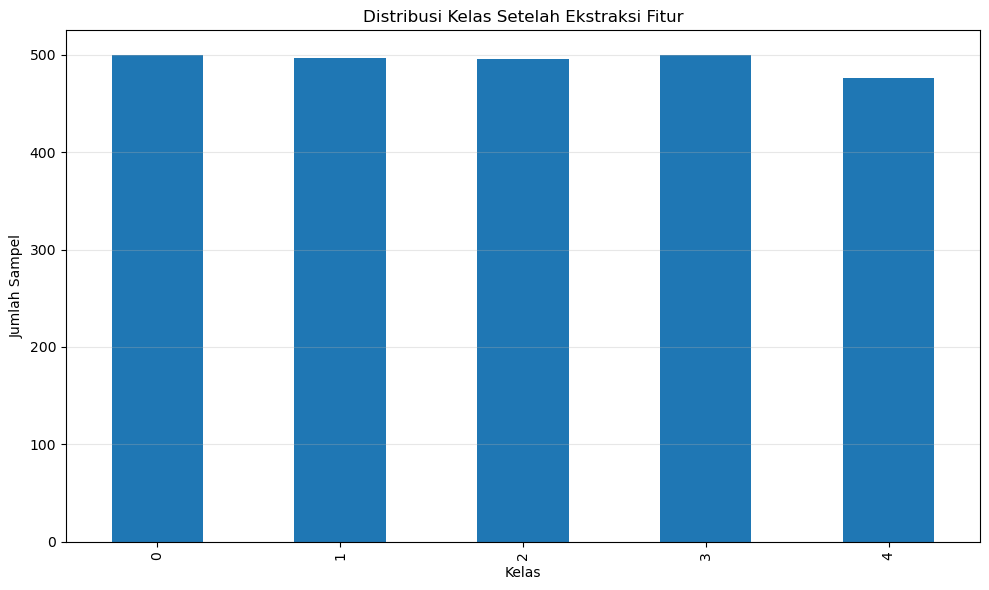

In [29]:
# Cek distribusi kelas setelah ekstraksi
print("\nDistribusi kelas setelah ekstraksi fitur:")
class_distribution = tsfel_features_df['label'].value_counts().sort_index()
print(class_distribution)

# Visualisasi distribusi kelas (opsional)
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Distribusi Kelas Setelah Ekstraksi Fitur')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('class_distribution_after_extraction.png')
plt.show()

NORMALISASI

In [30]:
# Ubah nilai NaN menjadi menghapus kolom, bukan mengisi dengan 0
print("Menghapus kolom yang memiliki nilai NaN...")
# Identifikasi kolom yang memiliki nilai NaN
columns_with_nan = tsfel_features_df.columns[tsfel_features_df.isna().any()].tolist()
print(f"Jumlah kolom yang memiliki nilai NaN: {len(columns_with_nan)}")
print(f"Kolom yang akan dihapus: {columns_with_nan}")

# Hapus kolom yang memiliki nilai NaN
features_clean = tsfel_features_df.drop(columns=columns_with_nan)

# Periksa apakah masih ada nilai NaN di dataset
nan_count = features_clean.isna().sum().sum()
print(f"Jumlah nilai NaN yang tersisa: {nan_count}")

# Memisahkan fitur dan label
X = features_clean.drop('label', axis=1) if 'label' in features_clean.columns else features_clean
y = features_clean['label'] if 'label' in features_clean.columns else None

# Periksa distribusi kelas sebelum SMOTE
if y is not None:
    print("\nDistribusi kelas sebelum SMOTE:")
    print(y.value_counts())
    # Terapkan SMOTE untuk menyeimbangkan kelas dengan target 500 data per kelas
    from imblearn.over_sampling import SMOTE
    
    # Tentukan strategi sampling - setiap kelas akan memiliki 500 sampel
    smote = SMOTE(sampling_strategy={label: 500 for label in y.unique()}, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print("\nDistribusi kelas setelah SMOTE:")
    import pandas as pd
    print(pd.Series(y_resampled).value_counts())
    
    # Gabungkan kembali fitur dan label
    features_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                 pd.Series(y_resampled, name='label')], axis=1)
    
    print(f"\nFinal dataset shape setelah SMOTE: {features_balanced.shape}")
    
    # Simpan dataset yang sudah diproses
    features_balanced.to_csv('ekg_normalized_balanced_features.csv', index=False)
    print("Dataset yang telah dinormalisasi dan diseimbangkan disimpan ke 'ekg_normalized_balanced_features.csv'")
else:
    print("Label tidak ditemukan dalam dataset. SMOTE tidak dapat diterapkan.")
    # Simpan dataset yang sudah diproses tanpa SMOTE
    X.to_csv('ekg_normalized_features.csv', index=False)
    print("Dataset yang telah dinormalisasi disimpan ke 'ekg_normalized_features.csv'")

Menghapus kolom yang memiliki nilai NaN...
Jumlah kolom yang memiliki nilai NaN: 0
Kolom yang akan dihapus: []
Jumlah nilai NaN yang tersisa: 0

Distribusi kelas sebelum SMOTE:
label
0    500
3    500
1    497
2    496
4    476
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
label
0    500
1    500
2    500
3    500
4    500
Name: count, dtype: int64

Final dataset shape setelah SMOTE: (2500, 157)
Dataset yang telah dinormalisasi dan diseimbangkan disimpan ke 'ekg_normalized_balanced_features.csv'


In [32]:
features_balanced.head()

0_Absolute energy  0_Area under the curve  0_Autocorrelation  \
0          34.936934                0.169781               15.0   
1          36.884112                0.175499               14.0   
2          35.653603                0.180544               14.0   
3          38.276506                0.189564               15.0   
4          36.862449                0.184431               14.0   

   0_Average power  0_Centroid  0_ECDF Percentile Count_0  \
0        50.511231    0.223370                       50.0   
1        53.326427    0.218431                       50.0   
2        51.547378    0.209118                       50.0   
3        55.339527    0.208696                       50.0   
4        53.295106    0.230665                       50.0   

   0_ECDF Percentile Count_1  0_ECDF Percentile_0  0_ECDF Percentile_1  \
0                      200.0            -0.243295             0.116667   
1                      200.0            -0.221748             0.121025   
2                      200.0            -0.203277             0.203240   
3                      200.0            -0.232185             0.186285   
4                      200.0            -0.242604             0.194625   

   0_ECDF_0  ...  0_Wavelet variance_11.25Hz  0_Wavelet variance_12.86Hz  \
0     0.004  ...                    0.780958                    0.490482   
1     0.004  ...                    0.924184                    0.586030   
2     0.004  ...                    0.824838                    0.521617   
3     0.004  ...                    0.771516                    0.482863   
4     0.004  ...                    0.857157                    0.541786   

   0_Wavelet variance_15.0Hz  0_Wavelet variance_18.0Hz  \
0                   0.276808                   0.137486   
1                   0.335166                   0.169753   
2                   0.298244                   0.151351   
3                   0.272783                   0.136370   
4                   0.309135                   0.156413   

   0_Wavelet variance_22.5Hz  0_Wavelet variance_30.0Hz  \
0                   0.056468                   0.017351   
1                   0.071654                   0.022701   
2                   0.064439                   0.021063   
3                   0.056714                   0.017734   
4                   0.066236                   0.021302   

   0_Wavelet variance_45.0Hz  0_Wavelet variance_90.0Hz  0_Zero crossing rate  \
0                   0.003059                   0.000149                   7.0   
1                   0.004109                   0.000216                   7.0   
2                   0.004151                   0.000279                   7.0   
3                   0.003186                   0.000161                   5.0   
4                   0.004003                   0.000225                   7.0   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 157 columns]

SPLIT DATA

In [34]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi fitur dan label
X = features_balanced.drop('label', axis=1)  # Fitur
y = features_balanced['label']  # Label

# Membagi dataset menjadi 80% training dan 20% validasi
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nData telah dibagi menjadi 80% training dan 20% validasi:")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_valid.shape}")

# Menampilkan distribusi kelas pada data training dan validasi
print("\nDistribusi kelas pada data training:")
print(y_train.value_counts(normalize=True))

print("\nDistribusi kelas pada data validasi:")
print(y_valid.value_counts(normalize=True))


Data telah dibagi menjadi 80% training dan 20% validasi:
Training data shape: (2000, 156)
Validation data shape: (500, 156)

Distribusi kelas pada data training:
label
3    0.2
1    0.2
2    0.2
4    0.2
0    0.2
Name: proportion, dtype: float64

Distribusi kelas pada data validasi:
label
4    0.2
2    0.2
3    0.2
1    0.2
0    0.2
Name: proportion, dtype: float64


In [36]:
# Check for NaN values in X_train
nan_check = X_train.isnull().any().any()

if nan_check:
    print("X_train contains NaN values.")

    # To see which columns have NaNs:
    nan_columns = X_train.columns[X_train.isnull().any()].tolist()
    print("Columns with NaN values:", nan_columns)

    # To count the number of NaNs in each column:
    nan_counts = X_train.isnull().sum()
    print("NaN counts per column:\n", nan_counts)
else:
    print("X_train does not contain NaN values.")

X_train does not contain NaN values.


# CLASSIFIERS

DECISION TREE

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

max_depth = 1
random_state = 42

# Decision Tree
start_time = time.time()
dt_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
dt_clf.fit(X_train, y_train)
dt_training_time = time.time() - start_time

# Prediction time measurement
start_pred_time = time.time()
y_pred_dt = dt_clf.predict(X_valid)
dt_prediction_time = time.time() - start_pred_time

dt_accuracy = accuracy_score(y_valid, y_pred_dt)

print("--- Decision Tree ---")
print("Validation Accuracy:", dt_accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_dt))
print("Classification Report:\n", classification_report(y_valid, y_pred_dt))
print("Training Time: {:.4f} seconds".format(dt_training_time))
print("Prediction Time: {:.4f} seconds".format(dt_prediction_time))

--- Decision Tree ---
Validation Accuracy: 0.36
Confusion Matrix:
 [[ 0  0  0 91  9]
 [ 0  0  0 93  7]
 [ 0  0  0 93  7]
 [ 0  0  0 98  2]
 [ 0  0  0 18 82]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.25      0.98      0.40       100
           4       0.77      0.82      0.79       100

    accuracy                           0.36       500
   macro avg       0.20      0.36      0.24       500
weighted avg       0.20      0.36      0.24       500

Training Time: 0.0394 seconds
Prediction Time: 0.0040 seconds


C:\Users\cathe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cathe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cathe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

ENSEMBLE MACHINE LEARNING

In [42]:
import time
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Model configurations
n_estimators = 50
max_depth = 1
random_state = 42
learning_rate = 1.0
num_test_runs = 5  # Number of test runs for calculating average prediction time

# Function to calculate ROC AUC OvO scores
def calculate_roc_auc_ovo(model, X, y_true):
    """
    Calculate ROC AUC score using One-vs-One method
    """
    try:
        # For models that support predict_proba natively
        y_scores = model.predict_proba(X)
        return roc_auc_score(y_true, y_scores, multi_class='ovo')
    except:
        # For models that might not support predict_proba in the same way
        try:
            # Some models like CatBoost use different methods
            y_scores = model.predict_proba(X)
            return roc_auc_score(y_true, y_scores, multi_class='ovo')
        except:
            print("Failed to calculate ROC AUC score for this model.")
            return None

# Function to measure average prediction time over multiple runs
def measure_avg_prediction_time(model, X, num_runs=5):
    """
    Calculate average prediction time over multiple runs
    """
    prediction_times = []
    
    for _ in range(num_runs):
        start_pred_time = time.time()
        _ = model.predict(X)
        end_pred_time = time.time()
        prediction_times.append(end_pred_time - start_pred_time)
    
    return prediction_times, np.mean(prediction_times)

# Dictionary to store model results for comparison
model_results = {}

# Decision Tree (base model for comparison)
start_time = time.time()
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=random_state)
dt_clf.fit(X_train, y_train)
dt_training_time = time.time() - start_time

y_pred_dt = dt_clf.predict(X_valid)
dt_pred_times, dt_avg_pred_time = measure_avg_prediction_time(dt_clf, X_valid, num_test_runs)

dt_accuracy = accuracy_score(y_valid, y_pred_dt)
dt_roc_auc = calculate_roc_auc_ovo(dt_clf, X_valid, y_valid)

model_results['Decision Tree'] = {
    'accuracy': dt_accuracy,
    'roc_auc_ovo': dt_roc_auc,
    'training_time': dt_training_time,
    'prediction_times': dt_pred_times,
    'avg_prediction_time': dt_avg_pred_time
}

print("--- Decision Tree ---")
print("Validation Accuracy:", dt_accuracy)
print("ROC AUC (OvO):", dt_roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_dt))
print("Classification Report:\n", classification_report(y_valid, y_pred_dt))
print("Training Time: {:.4f} seconds".format(dt_training_time))
print("Average Prediction Time (over {} runs): {:.4f} seconds".format(num_test_runs, dt_avg_pred_time))
print("Individual Prediction Times:", [round(t, 4) for t in dt_pred_times])

# AdaBoost
start_time = time.time()
adaboost_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=max_depth, random_state=random_state),
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    random_state=random_state
)
adaboost_clf.fit(X_train, y_train)
adaboost_training_time = time.time() - start_time

y_pred_adaboost = adaboost_clf.predict(X_valid)
adaboost_pred_times, adaboost_avg_pred_time = measure_avg_prediction_time(adaboost_clf, X_valid, num_test_runs)

adaboost_accuracy = accuracy_score(y_valid, y_pred_adaboost)
adaboost_roc_auc = calculate_roc_auc_ovo(adaboost_clf, X_valid, y_valid)

model_results['AdaBoost'] = {
    'accuracy': adaboost_accuracy,
    'roc_auc_ovo': adaboost_roc_auc,
    'training_time': adaboost_training_time,
    'prediction_times': adaboost_pred_times,
    'avg_prediction_time': adaboost_avg_pred_time
}

print("\n--- AdaBoost ---")
print("Validation Accuracy:", adaboost_accuracy)
print("ROC AUC (OvO):", adaboost_roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_adaboost))
print("Classification Report:\n", classification_report(y_valid, y_pred_adaboost))
print("Training Time: {:.4f} seconds".format(adaboost_training_time))
print("Average Prediction Time (over {} runs): {:.4f} seconds".format(num_test_runs, adaboost_avg_pred_time))
print("Individual Prediction Times:", [round(t, 4) for t in adaboost_pred_times])

# Gradient Boosting
start_time = time.time()
gb_clf = GradientBoostingClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    random_state=random_state
)
gb_clf.fit(X_train, y_train)
gb_training_time = time.time() - start_time

y_pred_gb = gb_clf.predict(X_valid)
gb_pred_times, gb_avg_pred_time = measure_avg_prediction_time(gb_clf, X_valid, num_test_runs)

gb_accuracy = accuracy_score(y_valid, y_pred_gb)
gb_roc_auc = calculate_roc_auc_ovo(gb_clf, X_valid, y_valid)

model_results['Gradient Boosting'] = {
    'accuracy': gb_accuracy,
    'roc_auc_ovo': gb_roc_auc,
    'training_time': gb_training_time,
    'prediction_times': gb_pred_times,
    'avg_prediction_time': gb_avg_pred_time
}

print("\n--- Gradient Boosting ---")
print("Validation Accuracy:", gb_accuracy)
print("ROC AUC (OvO):", gb_roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_gb))
print("Classification Report:\n", classification_report(y_valid, y_pred_gb))
print("Training Time: {:.4f} seconds".format(gb_training_time))
print("Average Prediction Time (over {} runs): {:.4f} seconds".format(num_test_runs, gb_avg_pred_time))
print("Individual Prediction Times:", [round(t, 4) for t in gb_pred_times])

# XGBoost
start_time = time.time()
xgb_clf = XGBClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    random_state=random_state,
    use_label_encoder=False,  # For compatibility with sklearn
    eval_metric='logloss'     # Required for classification
)
xgb_clf.fit(X_train, y_train)
xgb_training_time = time.time() - start_time

y_pred_xgb = xgb_clf.predict(X_valid)
xgb_pred_times, xgb_avg_pred_time = measure_avg_prediction_time(xgb_clf, X_valid, num_test_runs)

xgb_accuracy = accuracy_score(y_valid, y_pred_xgb)
xgb_roc_auc = calculate_roc_auc_ovo(xgb_clf, X_valid, y_valid)

model_results['XGBoost'] = {
    'accuracy': xgb_accuracy,
    'roc_auc_ovo': xgb_roc_auc,
    'training_time': xgb_training_time,
    'prediction_times': xgb_pred_times,
    'avg_prediction_time': xgb_avg_pred_time
}

print("\n--- XGBoost ---")
print("Validation Accuracy:", xgb_accuracy)
print("ROC AUC (OvO):", xgb_roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_xgb))
print("Classification Report:\n", classification_report(y_valid, y_pred_xgb))
print("Training Time: {:.4f} seconds".format(xgb_training_time))
print("Average Prediction Time (over {} runs): {:.4f} seconds".format(num_test_runs, xgb_avg_pred_time))
print("Individual Prediction Times:", [round(t, 4) for t in xgb_pred_times])

# CatBoost
start_time = time.time()
catboost_clf = CatBoostClassifier(
    iterations=n_estimators,
    depth=max_depth,
    learning_rate=learning_rate,
    random_seed=random_state,
    verbose=False
)
catboost_clf.fit(X_train, y_train)
catboost_training_time = time.time() - start_time

y_pred_catboost = catboost_clf.predict(X_valid)
catboost_pred_times, catboost_avg_pred_time = measure_avg_prediction_time(catboost_clf, X_valid, num_test_runs)

catboost_accuracy = accuracy_score(y_valid, y_pred_catboost)
catboost_roc_auc = calculate_roc_auc_ovo(catboost_clf, X_valid, y_valid)

model_results['CatBoost'] = {
    'accuracy': catboost_accuracy,
    'roc_auc_ovo': catboost_roc_auc,
    'training_time': catboost_training_time,
    'prediction_times': catboost_pred_times,
    'avg_prediction_time': catboost_avg_pred_time
}

print("\n--- CatBoost ---")
print("Validation Accuracy:", catboost_accuracy)
print("ROC AUC (OvO):", catboost_roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_catboost))
print("Classification Report:\n", classification_report(y_valid, y_pred_catboost))
print("Training Time: {:.4f} seconds".format(catboost_training_time))
print("Average Prediction Time (over {} runs): {:.4f} seconds".format(num_test_runs, catboost_avg_pred_time))
print("Individual Prediction Times:", [round(t, 4) for t in catboost_pred_times])

# LightGBM
start_time = time.time()
lightgbm_clf = LGBMClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    random_state=random_state
)
lightgbm_clf.fit(X_train, y_train)
lightgbm_training_time = time.time() - start_time

y_pred_lightgbm = lightgbm_clf.predict(X_valid)
lightgbm_pred_times, lightgbm_avg_pred_time = measure_avg_prediction_time(lightgbm_clf, X_valid, num_test_runs)

lightgbm_accuracy = accuracy_score(y_valid, y_pred_lightgbm)
lightgbm_roc_auc = calculate_roc_auc_ovo(lightgbm_clf, X_valid, y_valid)

model_results['LightGBM'] = {
    'accuracy': lightgbm_accuracy,
    'roc_auc_ovo': lightgbm_roc_auc,
    'training_time': lightgbm_training_time,
    'prediction_times': lightgbm_pred_times,
    'avg_prediction_time': lightgbm_avg_pred_time
}

print("\n--- LightGBM ---")
print("Validation Accuracy:", lightgbm_accuracy)
print("ROC AUC (OvO):", lightgbm_roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_lightgbm))
print("Classification Report:\n", classification_report(y_valid, y_pred_lightgbm))
print("Training Time: {:.4f} seconds".format(lightgbm_training_time))
print("Average Prediction Time (over {} runs): {:.4f} seconds".format(num_test_runs, lightgbm_avg_pred_time))
print("Individual Prediction Times:", [round(t, 4) for t in lightgbm_pred_times])

# Print model comparison table
print("\n--- Model Comparison ---")
print("{:<20} {:<10} {:<15} {:<15} {:<15}".format('Model', 'Accuracy', 'ROC AUC (OvO)', 'Training Time', 'Avg Pred Time'))
print("-" * 75)
for model_name, results in model_results.items():
    print("{:<20} {:<10.4f} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        model_name,
        results['accuracy'],
        results['roc_auc_ovo'] if results['roc_auc_ovo'] is not None else 0.0,
        results['training_time'],
        results['avg_prediction_time']
    ))

--- Decision Tree ---
Validation Accuracy: 0.76
ROC AUC (OvO): 0.91766
Confusion Matrix:
 [[83  2 12  2  1]
 [ 2 66 11 19  2]
 [ 6  5 81  5  3]
 [ 3  3 25 69  0]
 [ 2  3  5  9 81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       100
           1       0.84      0.66      0.74       100
           2       0.60      0.81      0.69       100
           3       0.66      0.69      0.68       100
           4       0.93      0.81      0.87       100

    accuracy                           0.76       500
   macro avg       0.78      0.76      0.76       500
weighted avg       0.78      0.76      0.76       500

Training Time: 0.3285 seconds
Average Prediction Time (over 5 runs): 0.0026 seconds
Individual Prediction Times: [0.003, 0.002, 0.003, 0.002, 0.003]


C:\Users\cathe\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



--- AdaBoost ---
Validation Accuracy: 0.72
ROC AUC (OvO): 0.84454
Confusion Matrix:
 [[78  8  8  4  2]
 [ 8 66 13 12  1]
 [ 4  5 68 13 10]
 [ 0 20 12 65  3]
 [ 2  2 11  2 83]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81       100
           1       0.65      0.66      0.66       100
           2       0.61      0.68      0.64       100
           3       0.68      0.65      0.66       100
           4       0.84      0.83      0.83       100

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.72      0.72       500

Training Time: 2.1017 seconds
Average Prediction Time (over 5 runs): 0.0162 seconds
Individual Prediction Times: [0.0152, 0.0141, 0.0155, 0.0169, 0.0194]

--- Gradient Boosting ---
Validation Accuracy: 0.854
ROC AUC (OvO): 0.96714
Confusion Matrix:
 [[92  1  2  3  2]
 [ 4 86  3  6  1]
 [ 2  3 84  5  6]
 [ 1  

C:\Users\cathe\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:21:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Validation Accuracy: 0.876
ROC AUC (OvO): 0.9760300000000001
Confusion Matrix:
 [[94  1  2  0  3]
 [ 2 86  4  7  1]
 [ 2  5 86  3  4]
 [ 2  9  7 80  2]
 [ 0  2  2  4 92]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       100
           1       0.83      0.86      0.85       100
           2       0.85      0.86      0.86       100
           3       0.85      0.80      0.82       100
           4       0.90      0.92      0.91       100

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500

Training Time: 0.3822 seconds
Average Prediction Time (over 5 runs): 0.0065 seconds
Individual Prediction Times: [0.0073, 0.0059, 0.0054, 0.0069, 0.007]

--- CatBoost ---
Validation Accuracy: 0.828
ROC AUC (OvO): 0.962725
Confusion Matrix:
 [[87  3  5  2  3]
 [ 2 79  4 12  3]
 [ 4  4 83  4  5]
 [ 3

OPTIMASI

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
import time
import warnings
warnings.filterwarnings('ignore')

def optuna_optimization(X_train, y_train, X_valid, y_valid, model_type, n_trials=10, seed=42):
    """
    Run Optuna optimization for the specified model type.
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    X_valid : array-like
        Validation features
    y_valid : array-like
        Validation target
    model_type : str
        Type of model to optimize ('adaboost', 'gradientboost', 'xgboost', 'catboost', 'lightgbm')
    n_trials : int
        Number of Optuna trials
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict
        Optimization results including best parameters, model, etc.
    """
    # Convert inputs to numpy arrays if needed
    if hasattr(X_train, 'values'):
        X_train_array = X_train.values
    else:
        X_train_array = np.array(X_train)
        
    if hasattr(y_train, 'values'):
        y_train_array = y_train.values
    else:
        y_train_array = np.array(y_train)
    
    # Count number of classes for multiclass setting
    n_classes = len(np.unique(y_train_array))
    
    # Create optimization validation data
    X_opt_train, X_opt_val, y_opt_train, y_opt_val = train_test_split(
        X_train_array,
        y_train_array,
        test_size=0.2,
        random_state=seed,
        stratify=y_train_array
    )
    
    # Define class weights
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_train_array)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_array)
    class_weight_dict = dict(zip(classes, class_weights))
    
    # Define the objective function for Optuna
    def objective(trial):
        # Define search space parameters for each model
        if model_type == 'adaboost':
            # Import DecisionTreeClassifier
            from sklearn.tree import DecisionTreeClassifier
            
            # Create a stronger base estimator
            estimator = DecisionTreeClassifier(
                max_depth=trial.suggest_int('estimator_max_depth', 1, 10),  # Reduced from 15 to prevent overfitting
                min_samples_split=trial.suggest_int('estimator_min_samples_split', 2, 20),
                min_samples_leaf=trial.suggest_int('estimator_min_samples_leaf', 2, 10),  # Increased min from 1 to 2
                class_weight=trial.suggest_categorical('estimator_class_weight', ['balanced', None])
            )

            # Create class weights explicitly for multi-class
            sample_weights = None
            use_sample_weight = trial.suggest_categorical('use_sample_weight', [True, False])
            if use_sample_weight:
                # Generate balanced sample weights
                from sklearn.utils.class_weight import compute_sample_weight
                sample_weights = compute_sample_weight('balanced', y_train_array)

            params = {
                'estimator': estimator,
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Reduced from 1000 to avoid overfitting
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),  # Reduced upper bound
                'algorithm': 'SAMME',  # Explicitly use SAMME for multiclass
                'random_state': seed
            }

        elif model_type == 'gradientboost':
            params = {
                'loss': 'log_loss',  # Good for multiclass classification
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),  # Reduced upper bound
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Reduced from 1000
                'subsample': trial.suggest_float('subsample', 0.6, 0.9),  # Narrower range to prevent overfitting
                'max_depth': trial.suggest_int('max_depth', 3, 8),  # Reduced from 12
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),  # Increased min from 1 to 2
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  # Removed None option
                'warm_start': trial.suggest_categorical('warm_start', [True, False]),
                'random_state': seed
            }
            
            # Add a flag for using sample weights since we can't use class_weight parameter
            use_sample_weight_gb = trial.suggest_categorical('use_sample_weight_gb', [True, False])

        elif model_type == 'xgboost':
            max_depth = trial.suggest_int('max_depth', 3, 8)  # Reduced from 12
            
            # Calculate sample weights for XGBoost
            sample_weight = None
            use_sample_weight_xgb = trial.suggest_categorical('use_sample_weight_xgb', [True, False])
            if use_sample_weight_xgb:
                from sklearn.utils.class_weight import compute_sample_weight
                sample_weight = compute_sample_weight('balanced', y_train_array)
            
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Reduced from 1000
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),  # Reduced upper bound
                'max_depth': max_depth,
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),  # Reduced from 10
                'gamma': trial.suggest_float('gamma', 0.01, 1.0),  # Increased min from 0.0 to 0.01
                'subsample': trial.suggest_float('subsample', 0.6, 0.9),  # Narrower range
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),  # Narrower range
                'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.9),  # Narrower range
                # Refined regularization parameters range for better generalization
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 0.5, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 0.5, log=True),
                'objective': 'multi:softmax',
                'num_class': n_classes,
                'tree_method': 'exact',
                'random_state': seed
            }

        elif model_type == 'catboost':
            params = {
                'iterations': trial.suggest_int('iterations', 50, 300),  # Reduced from 1000
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),  # Reduced upper bound
                'depth': trial.suggest_int('depth', 4, 8),  # Reduced from 12
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),  # Increased min for better reg
                'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),  # Increased min from 0.0
                'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                # Always include these parameters, CatBoost will use only those relevant to the bootstrap_type
                'bagging_temperature': trial.suggest_float("bagging_temperature", 0, 10),  # Used with Bayesian
                'subsample': trial.suggest_float("subsample", 0.6, 0.9),  # Narrower range, used with Bernoulli
                'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),  # Removed Lossguide
                'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
                'loss_function': 'MultiClass',
                'classes_count': n_classes,
                'random_state': seed,
                'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', None])
            }
        elif model_type == 'lightgbm':
            max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjusted range
            # More careful num_leaves calculation to avoid overfitting
            max_num_leaves = min(2**max_depth - 1, 100)  # Using 2^depth - 1 (more proper for binary trees)
            min_leaves = max(5, int(max_num_leaves * 0.1))  # At least 5 or 10% of max
            
            # Feature fraction and bagging frequency for more robust training
            feature_fraction_bynode = trial.suggest_float('feature_fraction_bynode', 0.6, 1.0)
            bagging_freq = trial.suggest_int('bagging_freq', 1, 10)
            
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 400),  # Wider range
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
                'max_depth': max_depth,
                'num_leaves': trial.suggest_int('num_leaves', min_leaves, max_num_leaves),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Wider range
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Wider range
                'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
                'feature_fraction_bynode': feature_fraction_bynode,
                'bagging_freq': bagging_freq,
                # Path smoothing for better generalization
                'path_smooth': trial.suggest_float('path_smooth', 0, 10),
                # Enhanced regularization parameters
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  # Wider range
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),  # Wider range
                'min_split_gain': trial.suggest_float('min_split_gain', 0, 5.0),
                'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1.0),
                # Category handling
                'max_bin': trial.suggest_int('max_bin', 100, 300),
                'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
                'cat_smooth': trial.suggest_float('cat_smooth', 1, 100),
                'cat_l2': trial.suggest_float('cat_l2', 1, 20),
                # Additional parameters for more control
                'boost_from_average': trial.suggest_categorical('boost_from_average', [True, False]),
                'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
                'objective': 'multiclass',
                'num_class': n_classes,
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                'random_state': seed
            }

        else:
            raise ValueError(f"Model type {model_type} not supported")

        # Handle specific model creation cases
        if model_type == 'adaboost':
            model = AdaBoostClassifier(**params)
        elif model_type == 'gradientboost':
            model = GradientBoostingClassifier(**params)
        elif model_type == 'xgboost':
            # Create a clean copy of params without sample weight flags
            xgb_params = params.copy()
            model = xgb.XGBClassifier(**xgb_params, verbosity=0, eval_metric='mlogloss')
            
            # Basic fit for XGBoost without early stopping
            try:
                if use_sample_weight_xgb and sample_weight is not None:
                    model.fit(
                        X_opt_train, y_opt_train,
                        sample_weight=sample_weight[:len(y_opt_train)] if sample_weight is not None else None
                    )
                else:
                    model.fit(X_opt_train, y_opt_train)
            except Exception as e:
                print(f"XGBoost fitting error: {str(e)}")
                return 0.0
                
        elif model_type == 'catboost':
            # Create proper params dict removing parameters that are not used for the selected bootstrap_type
            catboost_params = params.copy()
            bootstrap_type = catboost_params['bootstrap_type']
            
            # Keep only parameters relevant to the bootstrap_type
            if bootstrap_type != 'Bayesian':
                catboost_params.pop('bagging_temperature', None)
            if bootstrap_type != 'Bernoulli':
                catboost_params.pop('subsample', None)
                
            model = cb.CatBoostClassifier(**catboost_params, verbose=0)
            # Basic fit for CatBoost without early stopping
            try:
                model.fit(X_opt_train, y_opt_train)
            except Exception as e:
                print(f"CatBoost fitting error: {str(e)}")
                return 0.0
                
        elif model_type == 'lightgbm':
            model = lgb.LGBMClassifier(**params, verbose=-1)
            # Basic fit for LightGBM without early stopping
            try:
                model.fit(X_opt_train, y_opt_train)
            except Exception as e:
                print(f"LightGBM fitting error: {str(e)}")
                return 0.0

        # Use stratified k-fold cross validation for consistent class distribution
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        cv_scores = []

        for train_idx, val_idx in kf.split(X_train_array):
            X_cv_train, X_cv_val = X_train_array[train_idx], X_train_array[val_idx]
            y_cv_train, y_cv_val = y_train_array[train_idx], y_train_array[val_idx]

            # Handle special cases for model fitting
            if model_type == 'adaboost' and use_sample_weight and sample_weights is not None:
                model.fit(X_cv_train, y_cv_train, sample_weight=sample_weights[train_idx])
            elif model_type == 'gradientboost' and use_sample_weight_gb:
                # Apply sample weights for GradientBoostingClassifier
                from sklearn.utils.class_weight import compute_sample_weight
                gb_sample_weights = compute_sample_weight('balanced', y_cv_train)
                model.fit(X_cv_train, y_cv_train, sample_weight=gb_sample_weights)
            elif model_type == 'xgboost' and use_sample_weight_xgb and sample_weight is not None:
                model.fit(X_cv_train, y_cv_train, sample_weight=sample_weight[train_idx])
            else:
                model.fit(X_cv_train, y_cv_train)
                
            try:
                y_pred = model.predict(X_cv_val)
                cv_scores.append(accuracy_score(y_cv_val, y_pred))
            except Exception as e:
                print(f"Prediction error: {str(e)}")
                return 0.0

        # Optuna looks for maximum value
        return np.mean(cv_scores)

    # Setup pruner: stop trials that don't show promise
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=5, 
        max_resource=10,
        reduction_factor=3
    )

    # Setup and run Optuna study with more robust sampler
    study = optuna.create_study(
        direction='maximize', 
        pruner=pruner, 
        sampler=optuna.samplers.TPESampler(
            seed=seed,
            n_startup_trials=3,
            multivariate=True,
            constant_liar=True,
            warn_independent_sampling=False
        )
    )
    study.optimize(objective, n_trials=n_trials) 

    # Get best parameters
    best_params = study.best_params
    print(f"\nBest parameters for {model_type}:")
    for key, value in best_params.items():
        print(f"{key}: {value}")

    # Define control variables for sample weights based on best parameters
    use_sample_weight = False
    use_sample_weight_gb = False
    use_sample_weight_xgb = False
    
    # Fix for AdaBoost: Create estimator based on best params and remove invalid params
    if model_type == 'adaboost':
        # Create the decision tree estimator using best_params
        if 'estimator_max_depth' in best_params:
            from sklearn.tree import DecisionTreeClassifier
            max_depth = best_params.pop('estimator_max_depth')
            min_samples_split = best_params.pop('estimator_min_samples_split', 2)
            min_samples_leaf = best_params.pop('estimator_min_samples_leaf', 1)
            class_weight = best_params.pop('estimator_class_weight', None)
            best_params['estimator'] = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                class_weight=class_weight
            )

        # Add algorithm parameter
        best_params['algorithm'] = 'SAMME'
        
        # Remove use_sample_weight from params and store flag
        if 'use_sample_weight' in best_params:
            use_sample_weight = best_params.pop('use_sample_weight', False)

    # Remove special parameters based on model type
    if model_type == 'gradientboost':
        # Remove the use_sample_weight_gb flag
        if 'use_sample_weight_gb' in best_params:
            use_sample_weight_gb = best_params.pop('use_sample_weight_gb', False)
        
    if model_type == 'xgboost':
        if 'use_sample_weight_xgb' in best_params:
            use_sample_weight_xgb = best_params.pop('use_sample_weight_xgb', False)
            
    # Clean up CatBoost parameters
    if model_type == 'catboost':
        bootstrap_type = best_params.get('bootstrap_type')
        # Remove parameters not used by the selected bootstrap_type
        if bootstrap_type != 'Bayesian' and 'bagging_temperature' in best_params:
            best_params.pop('bagging_temperature')
        if bootstrap_type != 'Bernoulli' and 'subsample' in best_params:
            best_params.pop('subsample')

    # Convert all integer parameters to proper int type
    int_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
                  'min_child_weight', 'depth', 'border_count', 'num_leaves',
                  'min_data_in_leaf', 'iterations']

    for key in best_params:
        if key in int_params:
            best_params[key] = int(best_params[key])

    # Train model with best parameters on full training set
    if model_type == 'adaboost':
        best_model = AdaBoostClassifier(**best_params, random_state=seed)
        # Apply sample weights if specified
        if use_sample_weight:
            from sklearn.utils.class_weight import compute_sample_weight
            sample_weights = compute_sample_weight('balanced', y_train)
            best_model.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            best_model.fit(X_train, y_train)
    elif model_type == 'gradientboost':
        best_model = GradientBoostingClassifier(**best_params, random_state=seed)
        # Apply sample weights if that flag was set during optimization
        if use_sample_weight_gb:
            from sklearn.utils.class_weight import compute_sample_weight
            gb_sample_weights = compute_sample_weight('balanced', y_train)
            best_model.fit(X_train, y_train, sample_weight=gb_sample_weights)
        else:
            best_model.fit(X_train, y_train)
    elif model_type == 'xgboost':
        best_model = xgb.XGBClassifier(**best_params, random_state=seed, verbosity=0, eval_metric='mlogloss')
        if use_sample_weight_xgb:
            from sklearn.utils.class_weight import compute_sample_weight
            sample_weights = compute_sample_weight('balanced', y_train)
            best_model.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            best_model.fit(X_train, y_train)
    elif model_type == 'catboost':
        # Handle iterations parameter separately for CatBoost
        iterations = best_params.pop('iterations', 100) if 'iterations' in best_params else 100
        best_model = cb.CatBoostClassifier(**best_params, iterations=iterations, random_state=seed, verbose=0)
        best_model.fit(X_train, y_train)
    elif model_type == 'lightgbm':
        best_model = lgb.LGBMClassifier(**best_params, random_state=seed, verbose=-1)
        best_model.fit(X_train, y_train)

    # Evaluate model on validation data
    y_pred = best_model.predict(X_valid)

    if hasattr(best_model, 'predict_proba'):
        y_pred_proba = best_model.predict_proba(X_valid)
    else:
        # Handle if model doesn't have predict_proba
        y_pred_proba = np.zeros((len(y_valid), n_classes))
        for i, pred in enumerate(y_pred):
            y_pred_proba[i, int(pred)] = 1.0

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')

    # Calculate ROC AUC for multiclass
    try:
        roc_auc = roc_auc_score(y_valid, y_pred_proba, multi_class='ovo')
    except Exception as e:
        print(f"ROC AUC calculation error: {str(e)}")
        roc_auc = 0

    # Confusion matrix
    conf_matrix = confusion_matrix(y_valid, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Classification report
    class_report = classification_report(y_valid, y_pred)
    print("\nClassification Report:")
    print(class_report)

    # Evaluation metrics
    validation_metrics = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    # Show evaluation results
    print(f"\nValidation metrics for {model_type}:")
    for metric, value in validation_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Return results
    return {
        'best_params': best_params,
        'best_model': best_model,
        'study': study,
        'validation_metrics': validation_metrics,
        'trials': study.trials
    }

[I 2025-05-19 11:23:51,366] A new study created in memory with name: no-name-ba4413db-1adb-4cc7-8b5d-ee32aceeba82


Starting model optimization...

Running Optuna Optimization for adaboost


[I 2025-05-19 11:25:28,298] Trial 0 finished with value: 0.8615 and parameters: {'estimator_max_depth': 4, 'estimator_min_samples_split': 20, 'estimator_min_samples_leaf': 8, 'estimator_class_weight': 'balanced', 'use_sample_weight': True, 'n_estimators': 267, 'learning_rate': 0.10502105436744279}. Best is trial 0 with value: 0.8615.
[I 2025-05-19 11:26:39,182] Trial 1 finished with value: 0.8785000000000001 and parameters: {'estimator_max_depth': 8, 'estimator_min_samples_split': 2, 'estimator_min_samples_leaf': 10, 'estimator_class_weight': 'balanced', 'use_sample_weight': False, 'n_estimators': 126, 'learning_rate': 0.0779014312627624}. Best is trial 1 with value: 0.8785000000000001.
[I 2025-05-19 11:28:23,399] Trial 2 finished with value: 0.8630000000000001 and parameters: {'estimator_max_depth': 5, 'estimator_min_samples_split': 7, 'estimator_min_samples_leaf': 7, 'estimator_class_weight': None, 'use_sample_weight': False, 'n_estimators': 247, 'learning_rate': 0.021839352923182977


Best parameters for adaboost:
estimator_max_depth: 10
estimator_min_samples_split: 12
estimator_min_samples_leaf: 3
estimator_class_weight: None
use_sample_weight: False
n_estimators: 283
learning_rate: 0.23346963718163705


[I 2025-05-19 11:41:56,578] A new study created in memory with name: no-name-0b5ff34d-731b-4726-91b5-b2f7d309cccc



Confusion Matrix:
[[97  0  1  0  2]
 [ 2 90  4  3  1]
 [ 3  3 88  4  2]
 [ 2  3  4 90  1]
 [ 0  2  3  1 94]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       100
           1       0.92      0.90      0.91       100
           2       0.88      0.88      0.88       100
           3       0.92      0.90      0.91       100
           4       0.94      0.94      0.94       100

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500


Validation metrics for adaboost:
accuracy: 0.9180
f1_score: 0.9178
roc_auc: 0.9881
Execution time: 1085.21 seconds

Running Optuna Optimization for gradientboost


[I 2025-05-19 11:42:34,593] Trial 0 finished with value: 0.873 and parameters: {'learning_rate': 0.019906996673933378, 'n_estimators': 288, 'subsample': 0.8195981825434215, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'warm_start': False, 'use_sample_weight_gb': False}. Best is trial 0 with value: 0.873.
[I 2025-05-19 11:42:36,974] Trial 1 finished with value: 0.9789999999999999 and parameters: {'learning_rate': 0.10779361932748845, 'n_estimators': 103, 'subsample': 0.6545474901621302, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'warm_start': True, 'use_sample_weight_gb': False}. Best is trial 1 with value: 0.9789999999999999.
[I 2025-05-19 11:43:14,911] Trial 2 finished with value: 0.877 and parameters: {'learning_rate': 0.02689189948444278, 'n_estimators': 247, 'subsample': 0.6599021346475079, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'warm_start': False,


Best parameters for gradientboost:
learning_rate: 0.14211357476077255
n_estimators: 115
subsample: 0.7714572353226563
max_depth: 5
min_samples_split: 16
min_samples_leaf: 10
max_features: sqrt
warm_start: True
use_sample_weight_gb: False


[I 2025-05-19 11:43:54,623] A new study created in memory with name: no-name-3f28b93d-a075-4fad-9306-08cdabb00ec2



Confusion Matrix:
[[95  1  2  0  2]
 [ 2 91  3  3  1]
 [ 3  3 90  2  2]
 [ 2  4  3 90  1]
 [ 0  2  3  1 94]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       100
           1       0.90      0.91      0.91       100
           2       0.89      0.90      0.90       100
           3       0.94      0.90      0.92       100
           4       0.94      0.94      0.94       100

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500


Validation metrics for gradientboost:
accuracy: 0.9200
f1_score: 0.9200
roc_auc: 0.9888
Execution time: 118.04 seconds

Running Optuna Optimization for xgboost


[I 2025-05-19 11:44:07,836] Trial 0 finished with value: 0.8554999999999999 and parameters: {'max_depth': 5, 'use_sample_weight_xgb': True, 'n_estimators': 200, 'learning_rate': 0.00889039845957559, 'min_child_weight': 2, 'gamma': 0.06750277604651747, 'subsample': 0.8598528437324806, 'colsample_bytree': 0.7803345035229626, 'colsample_bylevel': 0.8124217733388137, 'reg_alpha': 0.00011916299962955152, 'reg_lambda': 0.38696122574142694}. Best is trial 0 with value: 0.8554999999999999.
[I 2025-05-19 11:44:14,224] Trial 1 finished with value: 0.8474999999999999 and parameters: {'max_depth': 7, 'use_sample_weight_xgb': True, 'n_estimators': 96, 'learning_rate': 0.015359756451337138, 'min_child_weight': 5, 'gamma': 0.4376255684556946, 'subsample': 0.6873687420594126, 'colsample_bytree': 0.7835558684167139, 'colsample_bylevel': 0.6418481581956126, 'reg_alpha': 0.0012040216379191721, 'reg_lambda': 0.002265486450485179}. Best is trial 0 with value: 0.8554999999999999.
[I 2025-05-19 11:44:23,295]


Best parameters for xgboost:
max_depth: 6
use_sample_weight_xgb: True
n_estimators: 281
learning_rate: 0.14360251579907204
min_child_weight: 2
gamma: 0.05865662053184306
subsample: 0.6347026876667314
colsample_bytree: 0.6071504701868006
colsample_bylevel: 0.7528427666433415
reg_alpha: 0.024535346939853542
reg_lambda: 0.00014236143826715228


[I 2025-05-19 11:45:21,471] A new study created in memory with name: no-name-93f3cb64-f87f-412a-8475-e7472912002b



Confusion Matrix:
[[94  1  2  0  3]
 [ 1 91  3  4  1]
 [ 3  2 90  3  2]
 [ 1  2  4 92  1]
 [ 0  2  2  1 95]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       100
           1       0.93      0.91      0.92       100
           2       0.89      0.90      0.90       100
           3       0.92      0.92      0.92       100
           4       0.93      0.95      0.94       100

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500


Validation metrics for xgboost:
accuracy: 0.9240
f1_score: 0.9240
roc_auc: 0.9894
Execution time: 86.85 seconds

Running Optuna Optimization for catboost


[I 2025-05-19 11:46:00,070] Trial 0 finished with value: 0.8744999999999999 and parameters: {'iterations': 144, 'learning_rate': 0.1667521176194013, 'depth': 7, 'l2_leaf_reg': 3.968793330444372, 'random_strength': 0.24041677639819287, 'bootstrap_type': 'MVS', 'bagging_temperature': 6.011150117432088, 'subsample': 0.8124217733388137, 'grow_policy': 'Depthwise', 'leaf_estimation_method': 'Newton', 'auto_class_weights': None}. Best is trial 0 with value: 0.8744999999999999.
[I 2025-05-19 11:46:27,172] Trial 1 finished with value: 0.8510000000000002 and parameters: {'iterations': 126, 'learning_rate': 0.034646653174710614, 'depth': 6, 'l2_leaf_reg': 1.9553708662745248, 'random_strength': 0.6506676052501416, 'bootstrap_type': 'MVS', 'bagging_temperature': 4.56069984217036, 'subsample': 0.8355527884179041, 'grow_policy': 'Depthwise', 'leaf_estimation_method': 'Newton', 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8744999999999999.
[I 2025-05-19 11:47:11,000] Trial 2 finis


Best parameters for catboost:
iterations: 117
learning_rate: 0.12357698704386501
depth: 8
l2_leaf_reg: 5.313303689999489
random_strength: 0.17952733955748243
bootstrap_type: Bernoulli
bagging_temperature: 4.966435894558437
subsample: 0.644962225290412
grow_policy: Depthwise
leaf_estimation_method: Gradient
auto_class_weights: None


[I 2025-05-19 11:55:02,640] A new study created in memory with name: no-name-985371f4-bcdf-4fe7-8b99-f8570cbbf080



Confusion Matrix:
[[94  1  1  2  2]
 [ 1 90  2  6  1]
 [ 3  3 90  1  3]
 [ 1  4  8 86  1]
 [ 0  2  3  1 94]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       100
           1       0.90      0.90      0.90       100
           2       0.87      0.90      0.88       100
           3       0.90      0.86      0.88       100
           4       0.93      0.94      0.94       100

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500


Validation metrics for catboost:
accuracy: 0.9080
f1_score: 0.9080
roc_auc: 0.9879
Execution time: 581.17 seconds

Running Optuna Optimization for lightgbm


[I 2025-05-19 11:55:07,713] Trial 0 finished with value: 0.829 and parameters: {'max_depth': 5, 'feature_fraction_bynode': 0.9802857225639665, 'bagging_freq': 8, 'n_estimators': 260, 'learning_rate': 0.00889039845957559, 'num_leaves': 9, 'min_data_in_leaf': 10, 'subsample': 0.9330880728874675, 'colsample_bytree': 0.8005575058716043, 'feature_fraction': 0.8540362888980227, 'path_smooth': 0.20584494295802447, 'reg_alpha': 5.360294728728285, 'reg_lambda': 0.31044435499483225, 'min_split_gain': 1.0616955533913808, 'min_gain_to_split': 0.18182496720710062, 'max_bin': 136, 'min_data_per_group': 95, 'cat_smooth': 52.950886731591545, 'cat_l2': 9.206955354200199, 'boost_from_average': False, 'extra_trees': False, 'class_weight': None}. Best is trial 0 with value: 0.829.
[I 2025-05-19 11:55:14,479] Trial 1 finished with value: 0.842 and parameters: {'max_depth': 9, 'feature_fraction_bynode': 0.6798695128633439, 'bagging_freq': 6, 'n_estimators': 257, 'learning_rate': 0.005934530307791968, 'num_l


Best parameters for lightgbm:
max_depth: 8
feature_fraction_bynode: 0.8070745161441896
bagging_freq: 10
n_estimators: 373
learning_rate: 0.1661512741292231
num_leaves: 46
min_data_in_leaf: 19
subsample: 0.93517246097614
colsample_bytree: 0.7584547526611314
feature_fraction: 0.7543947741987914
path_smooth: 4.913879503319341
reg_alpha: 2.547999457165707e-08
reg_lambda: 6.694919448008486e-06
min_split_gain: 4.665297981002689
min_gain_to_split: 0.09657347735617478
max_bin: 161
min_data_per_group: 183
cat_smooth: 86.27008790383229
cat_l2: 9.370156491524925
boost_from_average: True
extra_trees: True
class_weight: balanced

Confusion Matrix:
[[95  1  2  0  2]
 [ 1 90  4  4  1]
 [ 3  2 88  3  4]
 [ 0  4  4 91  1]
 [ 0  3  2  1 94]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       100
           1       0.90      0.90      0.90       100
           2       0.88      0.88      0.88       100
           3       0.92 

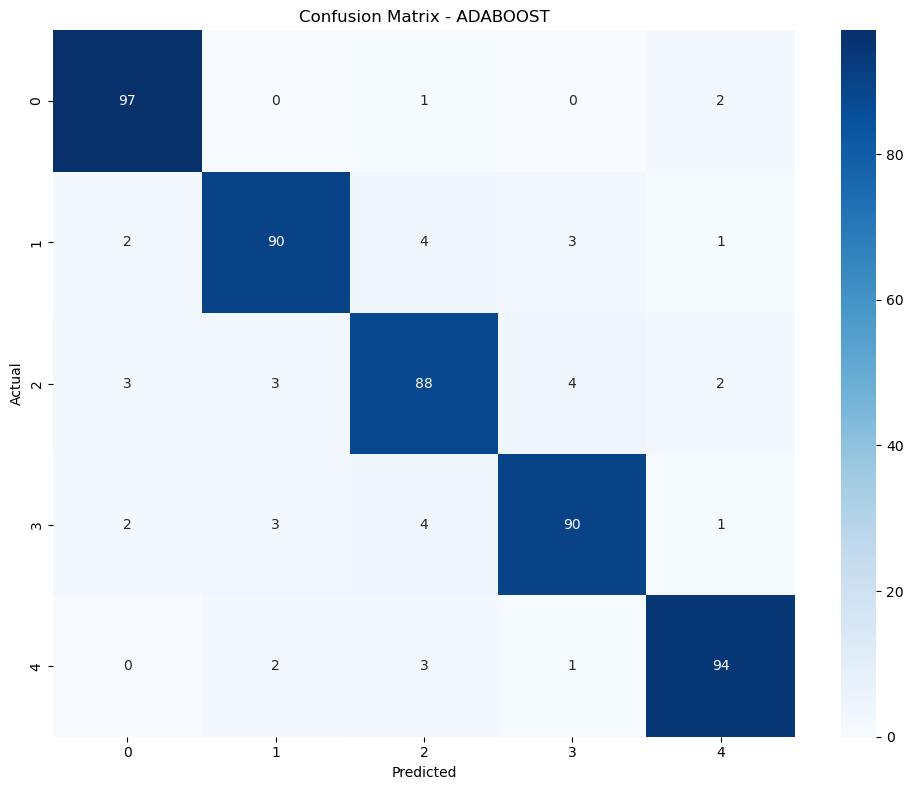


MODEL: GRADIENTBOOST
Best Parameters: {'learning_rate': 0.14211357476077255, 'n_estimators': 115, 'subsample': 0.7714572353226563, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'warm_start': True}

CROSS-VALIDATION RESULTS
Cross-validation scores (5-fold): [0.873, 0.9789999999999999, 0.877, 0.9789999999999999, 0.9560000000000001]
Mean CV accuracy: 0.9805
CV Accuracy Standard Deviation: 0.0492

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9314    0.9500    0.9406       100
           1     0.9010    0.9100    0.9055       100
           2     0.8911    0.9000    0.8955       100
           3     0.9375    0.9000    0.9184       100
           4     0.9400    0.9400    0.9400       100

    accuracy                         0.9200       500
   macro avg     0.9202    0.9200    0.9200       500
weighted avg     0.9202    0.9200    0.9200       500


CONFUSION MATRIX
[[95  1  2  0  2]
 [ 2 91  3  

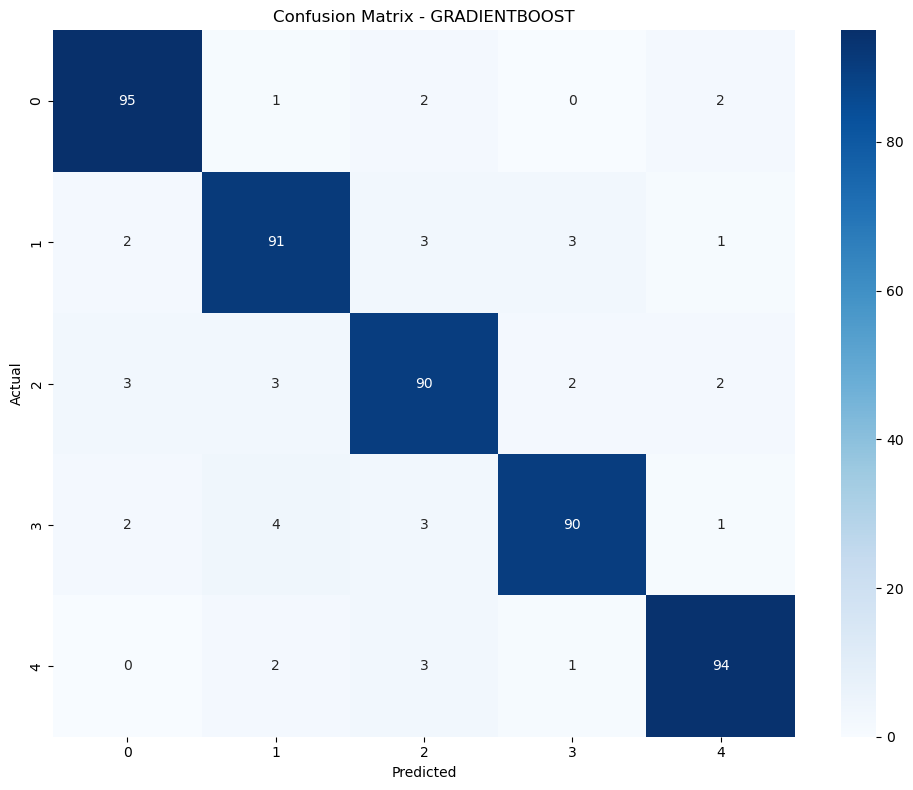


MODEL: XGBOOST
Best Parameters: {'max_depth': 6, 'n_estimators': 281, 'learning_rate': 0.14360251579907204, 'min_child_weight': 2, 'gamma': 0.05865662053184306, 'subsample': 0.6347026876667314, 'colsample_bytree': 0.6071504701868006, 'colsample_bylevel': 0.7528427666433415, 'reg_alpha': 0.024535346939853542, 'reg_lambda': 0.00014236143826715228}

CROSS-VALIDATION RESULTS
Cross-validation scores (5-fold): [0.8554999999999999, 0.8474999999999999, 0.8744999999999999, 0.877, 0.8865000000000001]
Mean CV accuracy: 0.8865
CV Accuracy Standard Deviation: 0.0125

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9495    0.9400    0.9447       100
           1     0.9286    0.9100    0.9192       100
           2     0.8911    0.9000    0.8955       100
           3     0.9200    0.9200    0.9200       100
           4     0.9314    0.9500    0.9406       100

    accuracy                         0.9240       500
   macro avg     0.9241    0.9240   

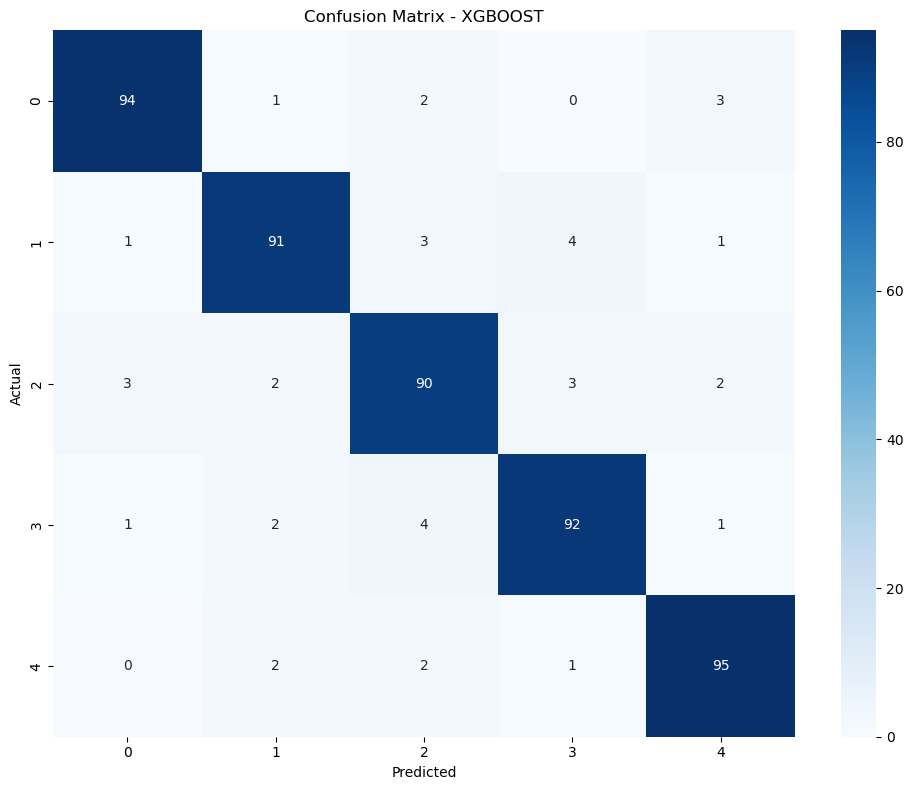


MODEL: CATBOOST
Best Parameters: {'learning_rate': 0.12357698704386501, 'depth': 8, 'l2_leaf_reg': 5.313303689999489, 'random_strength': 0.17952733955748243, 'bootstrap_type': 'Bernoulli', 'subsample': 0.644962225290412, 'grow_policy': 'Depthwise', 'leaf_estimation_method': 'Gradient', 'auto_class_weights': None}

CROSS-VALIDATION RESULTS
Cross-validation scores (5-fold): [0.8744999999999999, 0.8510000000000002, 0.876, 0.8800000000000001, 0.8800000000000001]
Mean CV accuracy: 0.8800
CV Accuracy Standard Deviation: 0.0152

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9495    0.9400    0.9447       100
           1     0.9000    0.9000    0.9000       100
           2     0.8654    0.9000    0.8824       100
           3     0.8958    0.8600    0.8776       100
           4     0.9307    0.9400    0.9353       100

    accuracy                         0.9080       500
   macro avg     0.9083    0.9080    0.9080       500
weighted avg   

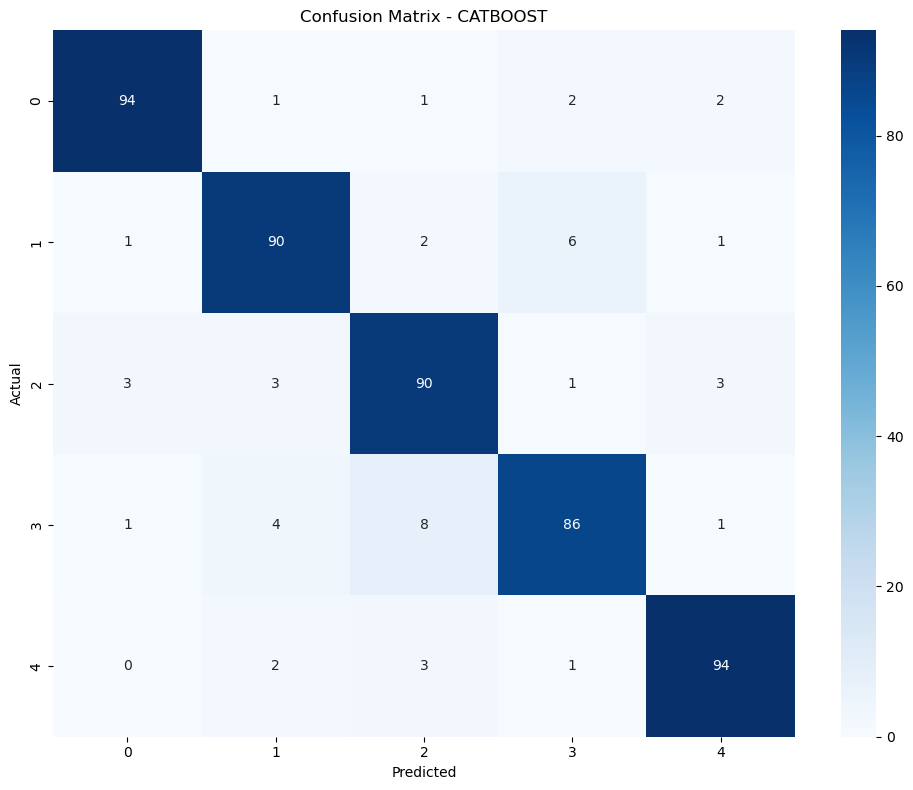


MODEL: LIGHTGBM
Best Parameters: {'max_depth': 8, 'feature_fraction_bynode': 0.8070745161441896, 'bagging_freq': 10, 'n_estimators': 373, 'learning_rate': 0.1661512741292231, 'num_leaves': 46, 'min_data_in_leaf': 19, 'subsample': 0.93517246097614, 'colsample_bytree': 0.7584547526611314, 'feature_fraction': 0.7543947741987914, 'path_smooth': 4.913879503319341, 'reg_alpha': 2.547999457165707e-08, 'reg_lambda': 6.694919448008486e-06, 'min_split_gain': 4.665297981002689, 'min_gain_to_split': 0.09657347735617478, 'max_bin': 161, 'min_data_per_group': 183, 'cat_smooth': 86.27008790383229, 'cat_l2': 9.370156491524925, 'boost_from_average': True, 'extra_trees': True, 'class_weight': 'balanced'}

CROSS-VALIDATION RESULTS
Cross-validation scores (5-fold): [0.829, 0.842, 0.8835000000000001, 0.8780000000000001, 0.8685]
Mean CV accuracy: 0.8935
CV Accuracy Standard Deviation: 0.0229

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9596    0.9500    0

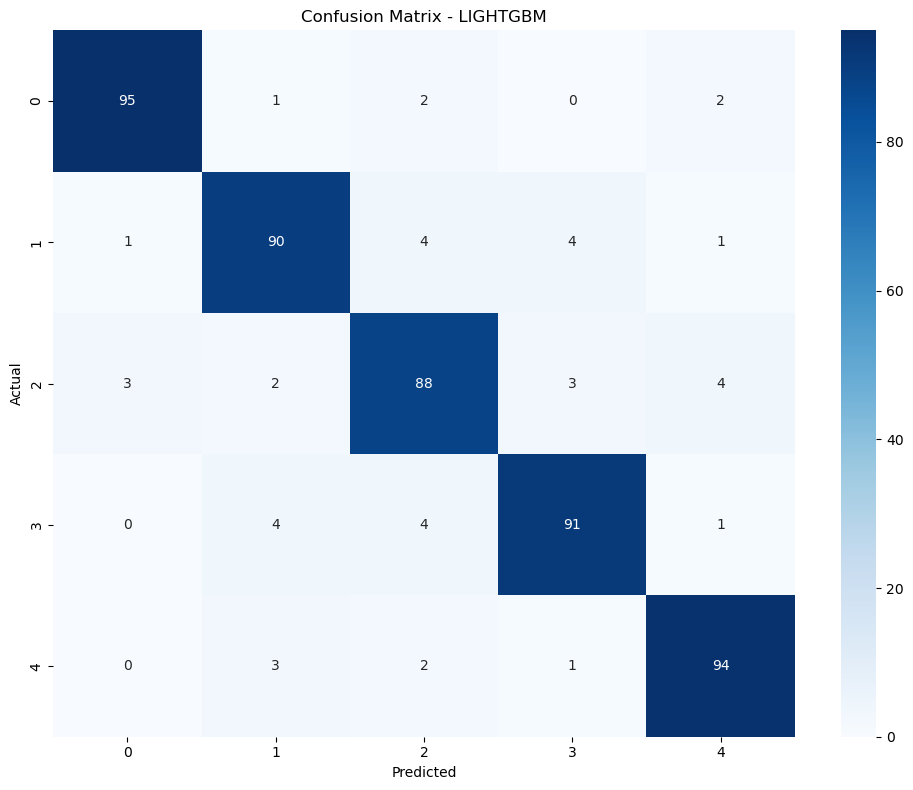


SUMMARY OF ALL MODELS

Model Comparison:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model Type           CV Mean Acc     CV Std Dev      Valid Acc       CM Acc          F1 Score        ROC AUC         Avg Test Time (s) Std Test Time (s)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
adaboost             0.8910        0.0287        0.9180        0.9180        0.9178        0.9881        0.0457        0.0123
gradientboost        0.9805        0.0492        0.9200        0.9200        0.9200        0.9888        0.0076        0.0066
xgboost              0.8865        0.0125        0.9240        0.9240        0.9240        0.9894        0.0095        0.0071
catboost             0.8800        0.0152        0.9080        0.9080        0.9080  

In [53]:
def run_optimization_for_all_models(X_train, y_train, X_valid, y_valid, n_trials=10, seed=42):
    """
    Run parameter optimization for all models and compare results.
    """
    # List of model types to optimize
    model_types = ['adaboost', 'gradientboost', 'xgboost', 'catboost', 'lightgbm']

    # Run optimization for each model
    results = {}
    for model_type in model_types:
        print(f"\n{'='*50}")
        print(f"Running Optuna Optimization for {model_type}")
        print(f"{'='*50}")

        start_time = time.time()
        result = optuna_optimization(X_train, y_train, X_valid, y_valid,
                                    model_type, n_trials=n_trials, seed=seed)
        elapsed_time = time.time() - start_time

        result['elapsed_time'] = elapsed_time
        results[model_type] = result

        print(f"Execution time: {elapsed_time:.2f} seconds")

    # Show results summary
    print("\n" + "="*50)
    print("SUMMARY OF RESULTS")
    print("="*50)

    for model_type, result in results.items():
        print(f"\n{model_type.upper()}:")
        for metric, value in result['validation_metrics'].items():
            print(f"{metric}: {value:.4f}")
        print(f"Execution time: {result['elapsed_time']:.2f} seconds")

    # Find best model based on accuracy
    best_model_type = max(results, key=lambda x: results[x]['validation_metrics']['accuracy'])
    best_result = results[best_model_type]

    print("\n" + "="*50)
    print(f"BEST MODEL: {best_model_type.upper()}")
    print("="*50)
    print(f"Validation Accuracy: {best_result['validation_metrics']['accuracy']:.4f}")
    print(f"Validation F1-Score: {best_result['validation_metrics']['f1_score']:.4f}")
    print(f"Validation ROC AUC: {best_result['validation_metrics']['roc_auc']:.4f}")
    print(f"Best Parameters:")
    for param, value in best_result['best_params'].items():
        print(f"  {param}: {value}")

    return results, best_model_type, best_result

# Function to evaluate all optimized models
def evaluate_all_models(results, best_model_type, X_valid, y_valid, seed=42):
    """
    Evaluates all optimized models with detailed metrics.
    Added average testing time from 5 runs for more reliable performance measurement.
    """
    import numpy as np
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
    import time

    print("\n" + "="*80)
    print("COMPREHENSIVE EVALUATION FOR ALL OPTIMIZED MODELS")
    print("="*80)

    # Initialize summary table data
    summary_data = []

    # Convert y_valid to numpy array if it's a pandas Series/DataFrame
    if hasattr(y_valid, 'values'):
        y_valid_np = y_valid.values
    else:
        y_valid_np = np.array(y_valid)
    
    # Count number of classes for multiclass setting
    n_classes = len(np.unique(y_valid_np))

    # For each model type in results
    for model_type, result in results.items():
        best_model = result['best_model']
        best_params = result['best_params']

        print("\n" + "="*50)
        print(f"MODEL: {model_type.upper()}")
        print("="*50)
        print(f"Best Parameters: {best_params}")

        # Cross-validation results from optimization phase
        cv_scores = {}
        # Extract CV scores from the study if available
        if 'study' in result:
            cv_scores = {
                'mean': result['study'].best_value,
                'std': np.std([t.value for t in result['study'].trials if t.value is not None]),
                'scores': [t.value for t in result['study'].trials if t.value is not None][:5]  # Use top 5 scores if available
            }

        # Create a temporary model with best parameters for additional CV if needed
        if not cv_scores:
            # If we don't have CV scores from trials, calculate them now
            temp_model = create_model_with_params(model_type, best_params, seed)
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
            cv_scores_array = cross_val_score(temp_model, X_valid, y_valid_np, cv=skf)
            cv_scores = {
                'mean': np.mean(cv_scores_array),
                'std': np.std(cv_scores_array),
                'scores': cv_scores_array
            }

        # Generate predictions using the best model
        # Run 5 times to get average prediction time
        test_times = []
        for i in range(5):
            start_time = time.time()
            y_pred = best_model.predict(X_valid)
            test_time = time.time() - start_time
            test_times.append(test_time)
        
        # Calculate average and standard deviation of test times
        avg_test_time = np.mean(test_times)
        std_test_time = np.std(test_times)

        # Get probabilistic predictions if model supports it
        if hasattr(best_model, 'predict_proba'):
            y_pred_proba = best_model.predict_proba(X_valid)
        else:
            # Handle if model doesn't have predict_proba
            y_pred_proba = np.zeros((len(y_valid_np), n_classes))
            for i, pred in enumerate(y_pred):
                y_pred_proba[i, int(pred)] = 1.0

        # Calculate accuracy using sklearn's accuracy_score
        accuracy = accuracy_score(y_valid_np, y_pred)
        
        # Also calculate accuracy directly from confusion matrix for verification
        cm = confusion_matrix(y_valid_np, y_pred)
        cm_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
        
        # Calculate F1 score
        f1 = f1_score(y_valid_np, y_pred, average='macro')
        
        # Calculate ROC AUC for multiclass
        try:
            roc_auc = roc_auc_score(y_valid_np, y_pred_proba, multi_class='ovo')
        except:
            roc_auc = 0

        # Add basic metrics to summary
        summary_data.append({
            'Model Type': model_type,
            'CV Mean Accuracy': cv_scores['mean'],
            'CV Std Dev': cv_scores['std'],
            'Validation Accuracy': accuracy,
            'CM Accuracy': cm_accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'Avg Test Time (s)': avg_test_time,
            'Std Test Time (s)': std_test_time,
            'Best Parameters': best_params
        })

        # 1. CROSS-VALIDATION RESULTS
        print("\n" + "="*50)
        print("CROSS-VALIDATION RESULTS")
        print("="*50)
        print(f"Cross-validation scores (5-fold): {cv_scores['scores']}")
        print(f"Mean CV accuracy: {cv_scores['mean']:.4f}")
        print(f"CV Accuracy Standard Deviation: {cv_scores['std']:.4f}")

        # 2. CLASSIFICATION REPORT
        print("\n" + "="*50)
        print("CLASSIFICATION REPORT")
        print("="*50)

        # Get class names
        class_names = np.unique(y_valid_np)

        report = classification_report(y_valid_np, y_pred,
                                      target_names=[str(name) for name in class_names],
                                      digits=4)
        print(report)

        # 3. CONFUSION MATRIX
        print("\n" + "="*50)
        print("CONFUSION MATRIX")
        print("="*50)

        cm = confusion_matrix(y_valid_np, y_pred)
        print(cm)
        print(f"Accuracy calculated from confusion matrix: {cm_accuracy:.4f}")

        # 4. TEST TIME
        print("\n" + "="*50)
        print("PERFORMANCE METRICS")
        print("="*50)
        print(f"Average Testing Time (5 runs): {avg_test_time:.4f} seconds ± {std_test_time:.4f}")
        print(f"Individual test times: {[f'{t:.4f}s' for t in test_times]}")
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation F1-Score: {f1:.4f}")
        print(f"Validation ROC AUC: {roc_auc:.4f}")

        # 5. VISUALIZE CONFUSION MATRIX
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[str(name) for name in class_names],
                   yticklabels=[str(name) for name in class_names])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {model_type.upper()}')
        plt.tight_layout()
        plt.show()

    # Create comparison table of all models
    print("\n" + "="*80)
    print("SUMMARY OF ALL MODELS")
    print("="*80)

    # Print summary table
    print("\nModel Comparison:")
    print("-" * 170)
    print(f"{'Model Type':<20} {'CV Mean Acc':<15} {'CV Std Dev':<15} {'Valid Acc':<15} {'CM Acc':<15} {'F1 Score':<15} {'ROC AUC':<15} {'Avg Test Time (s)':<15} {'Std Test Time (s)':<15}")
    print("-" * 170)

    for data in summary_data:
        print(f"{data['Model Type']:<20} {data['CV Mean Accuracy']:.4f}{'':<7} {data['CV Std Dev']:.4f}{'':<7} "
              f"{data['Validation Accuracy']:.4f}{'':<7} {data['CM Accuracy']:.4f}{'':<7} "
              f"{data['F1 Score']:.4f}{'':<7} {data['ROC AUC']:.4f}{'':<7} "
              f"{data['Avg Test Time (s)']:.4f}{'':<7} {data['Std Test Time (s)']:.4f}")

    print("-" * 170)

    # Find and announce the best model based on validation accuracy
    best_idx = np.argmax([data['Validation Accuracy'] for data in summary_data])
    best_model_name = summary_data[best_idx]['Model Type']
    best_model_acc = summary_data[best_idx]['Validation Accuracy']
    print(f"\nBest performing model based on validation accuracy: {best_model_name} with {best_model_acc:.4f}")

    # Find fastest model
    fastest_idx = np.argmin([data['Avg Test Time (s)'] for data in summary_data])
    fastest_model_name = summary_data[fastest_idx]['Model Type']
    fastest_model_time = summary_data[fastest_idx]['Avg Test Time (s)']
    print(f"Fastest model for inference: {fastest_model_name} with avg test time of {fastest_model_time:.4f} seconds")

    # Highlight if this differs from the chosen best model
    if best_model_name != best_model_type:
        print(f"Note: The accuracy-based best model differs from the composite-score best model: {best_model_type}")

# Function to create a single model with given parameters (for additional CV if needed)
def create_model_with_params(model_type, params, seed):
    """Create a model of the specified type with given parameters"""
    from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
    import xgboost as xgb
    import lightgbm as lgb
    import catboost as cb
    from sklearn.tree import DecisionTreeClassifier

    # Make a clean copy of params to avoid modifying the original
    params_copy = params.copy()
    
    # Create the model based on type
    if model_type == 'adaboost':
        # Special handling for AdaBoost estimator
        if 'estimator' not in params_copy:
            # Create the decision tree estimator using params if available
            estimator_params = {}
            estimator_keys = ['estimator_max_depth', 'estimator_min_samples_split', 
                              'estimator_min_samples_leaf', 'estimator_class_weight']
            
            for key in estimator_keys:
                if key in params_copy:
                    # Extract the param and remove 'estimator_' prefix
                    pure_key = key.replace('estimator_', '')
                    estimator_params[pure_key] = params_copy.pop(key)
            
            params_copy['estimator'] = DecisionTreeClassifier(**estimator_params)
        
        # Ensure algorithm is set for multiclass
        if 'algorithm' not in params_copy:
            params_copy['algorithm'] = 'SAMME'
            
        model = AdaBoostClassifier(**params_copy, random_state=seed)
        
    elif model_type == 'gradientboost':
        # Set loss to log_loss if not specified
        if 'loss' not in params_copy:
            params_copy['loss'] = 'log_loss'
        model = GradientBoostingClassifier(**params_copy, random_state=seed)
        
    elif model_type == 'xgboost':
        # Remove early stopping if present
        if 'early_stopping_rounds' in params_copy:
            params_copy.pop('early_stopping_rounds')
        
        # Remove use_sample_weight if present
        if 'use_sample_weight' in params_copy:
            params_copy.pop('use_sample_weight')
            
        # Set objective and num_class if not present
        if 'objective' not in params_copy:
            params_copy['objective'] = 'multi:softmax'
            
        # Get number of classes
        n_classes = None
        if 'num_class' in params_copy:
            n_classes = params_copy['num_class']
        
        model = xgb.XGBClassifier(**params_copy, random_state=seed, verbosity=0, eval_metric='mlogloss')
        
    elif model_type == 'catboost':
        # Handle iterations parameter separately for CatBoost
        iterations = params_copy.pop('iterations', 100) if 'iterations' in params_copy else 100
        
        # Remove early stopping if present
        if 'early_stopping_rounds' in params_copy:
            params_copy.pop('early_stopping_rounds')
            
        # Set loss function if not present
        if 'loss_function' not in params_copy:
            params_copy['loss_function'] = 'MultiClass'
            
        model = cb.CatBoostClassifier(**params_copy, iterations=iterations, random_state=seed, verbose=0)
    elif model_type == 'lightgbm':
    # Remove early stopping if present
        if 'early_stopping_rounds' in params_copy:
            params_copy.pop('early_stopping_rounds')
            
        # Set objective if not present
        if 'objective' not in params_copy:
            params_copy['objective'] = 'multiclass'
        
        # Handle additional LightGBM parameters that might be in the best params
        # Make sure path_smooth is present
        if 'path_smooth' not in params_copy:
            params_copy['path_smooth'] = 0.0
        
        # Ensure these parameters are present with proper defaults
        if 'feature_fraction_bynode' not in params_copy:
            params_copy['feature_fraction_bynode'] = 1.0
            
        if 'bagging_freq' not in params_copy:
            params_copy['bagging_freq'] = 0
            
        if 'extra_trees' not in params_copy:
            params_copy['extra_trees'] = False
            
        if 'min_gain_to_split' not in params_copy:
            params_copy['min_gain_to_split'] = 0.0
            
        if 'max_bin' not in params_copy:
            params_copy['max_bin'] = 255
            
        if 'min_data_per_group' not in params_copy:
            params_copy['min_data_per_group'] = 100
            
        if 'cat_smooth' not in params_copy:
            params_copy['cat_smooth'] = 10.0
            
        if 'cat_l2' not in params_copy:
            params_copy['cat_l2'] = 10.0
            
        model = lgb.LGBMClassifier(**params_copy, random_state=seed, verbose=-1)
    else:
        raise ValueError(f"Model type {model_type} not supported")

    return model

# Function to set all random seeds for reproducibility
def set_seeds(seed):
    """
    Set seeds for all random number generators to ensure reproducibility.
    """
    import numpy as np
    import random
    import os

    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Try to set tensorflow seed if available
    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
    except:
        pass

    # Try to set torch seed if available
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except:
        pass

# Main code to execute after optimization
if __name__ == "__main__":
    # Define global seed
    GLOBAL_SEED = 42

    # Set global random seed
    set_seeds(GLOBAL_SEED)

    # Assume: X_train, y_train, X_valid, y_valid have been defined previously

    # Run optimization for all models
    print("Starting model optimization...")
    results, best_model_type, best_result = run_optimization_for_all_models(
        X_train, y_train, X_valid, y_valid, n_trials=10, seed=GLOBAL_SEED)

    # Evaluate all models
    evaluate_all_models(results, best_model_type, X_valid, y_valid, seed=GLOBAL_SEED)

    # Use best model for predictions
    best_model = best_result['best_model']

    # Calculate number of classes
    n_classes = len(np.unique(y_valid))

    # Evaluate on validation set (best model)
    print("\nEvaluating best model on validation set...")
    
    # Generate predictions
    y_pred = best_model.predict(X_valid)

    # Calculate metrics
    validation_accuracy = accuracy_score(y_valid, y_pred)
    validation_f1 = f1_score(y_valid, y_pred, average='macro')

    if hasattr(best_model, 'predict_proba'):
        y_pred_proba = best_model.predict_proba(X_valid)
        try:
            validation_roc_auc = roc_auc_score(y_valid, y_pred_proba, multi_class='ovo')
        except:
            validation_roc_auc = 0
    else:
        # Handle if model doesn't have predict_proba
        y_pred_proba = np.zeros((len(y_valid), n_classes))
        for i, pred in enumerate(y_pred):
            y_pred_proba[i, int(pred)] = 1.0
        
        try:
            validation_roc_auc = roc_auc_score(y_valid, y_pred_proba, multi_class='ovo')
        except:
            validation_roc_auc = 0

    print("\n" + "="*50)
    print(f"FINAL VALIDATION RESULTS FOR {best_model_type.upper()}")
    print("="*50)
    print(f"Validation Accuracy: {validation_accuracy:.4f}")
    print(f"Validation F1-Score: {validation_f1:.4f}")
    print(f"Validation ROC AUC: {validation_roc_auc:.4f}")
    print("\nBest Parameters:")
    for param, value in best_result['best_params'].items():
        print(f"  {param}: {value}")
        
    # Print confusion matrix and classification report
    cm = confusion_matrix(y_valid, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification report
    class_report = classification_report(y_valid, y_pred)
    print("\nClassification Report:")
    print(class_report)

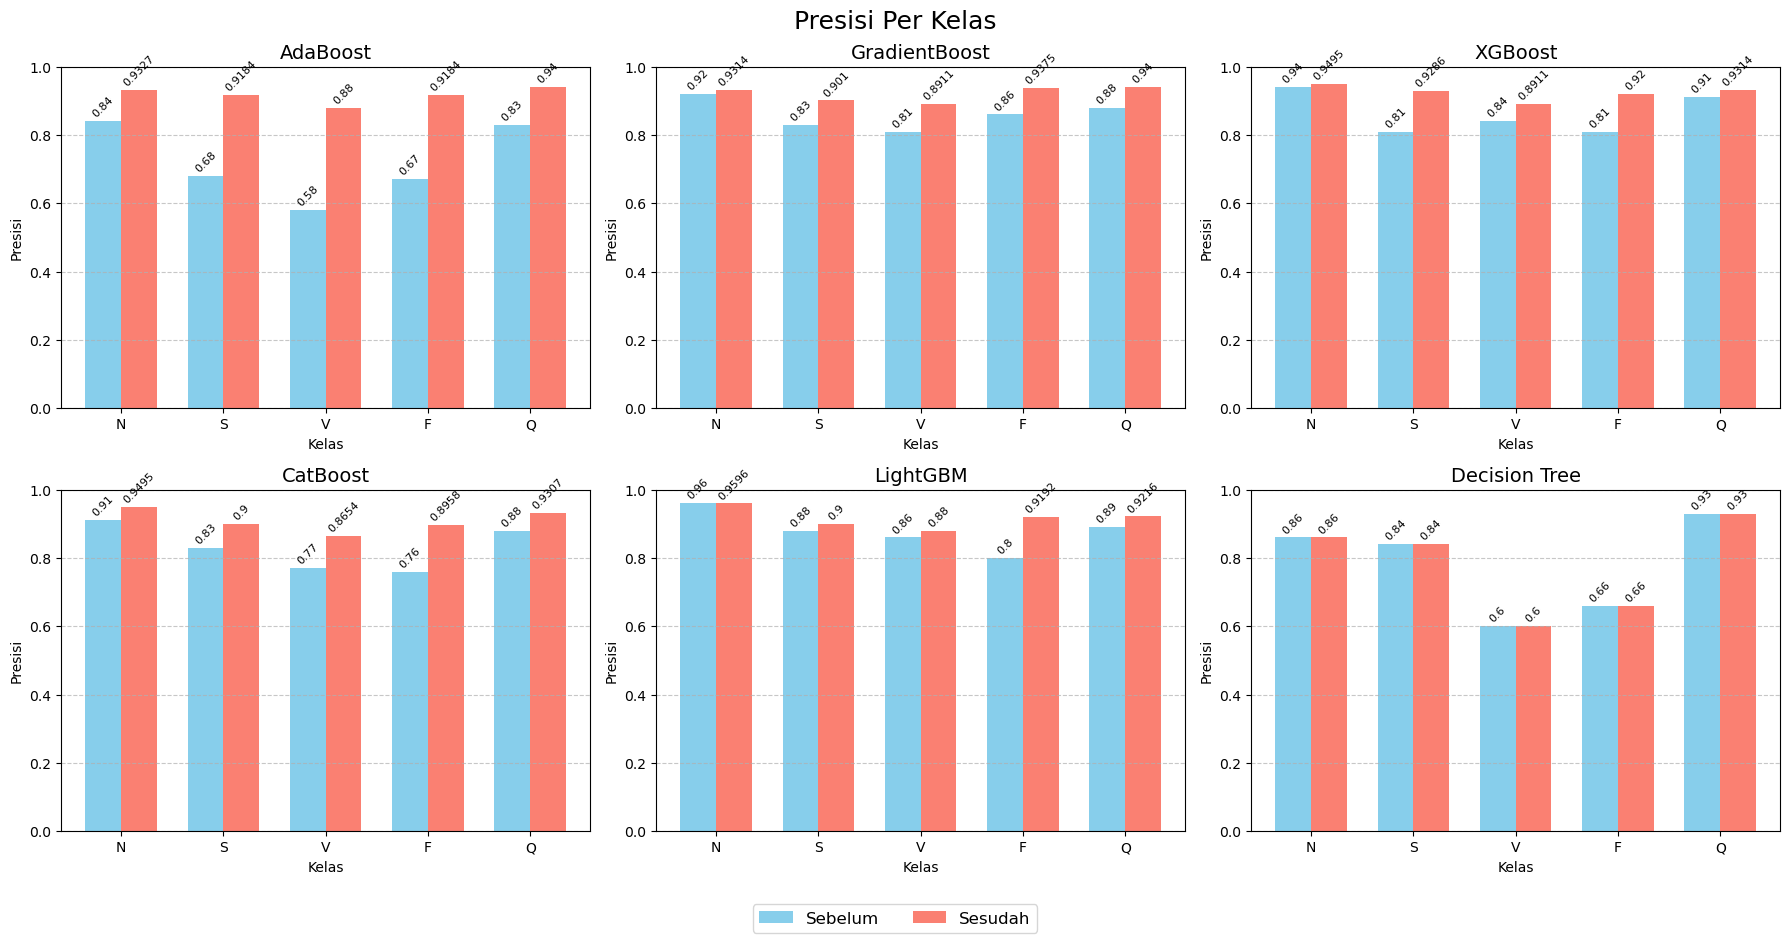

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Nama algoritma dan kelas
algorithms = ['AdaBoost', 'GradientBoost', 'XGBoost', 'CatBoost', 'LightGBM', 'Decision Tree']
classes = ['N', 'S', 'V', 'F', 'Q']

# Data presisi sebelum optimasi
precision_before = {
    'AdaBoost': [0.84, 0.68, 0.58, 0.67, 0.83],
    'GradientBoost': [0.92, 0.83, 0.81, 0.86, 0.88],
    'XGBoost': [0.94, 0.81, 0.84, 0.81, 0.91],
    'CatBoost': [0.91, 0.83, 0.77, 0.76, 0.88],
    'LightGBM': [0.96, 0.88, 0.86, 0.80, 0.89],
    'Decision Tree': [0.86, 0.84, 0.60, 0.66, 0.93]
}

# Data presisi setelah optimasi
precision_after = {
    'AdaBoost': [0.9327, 0.9184, 0.8800, 0.9184, 0.9400],
    'GradientBoost': [0.9314, 0.9010, 0.8911, 0.9375, 0.9400],
    'XGBoost': [0.9495, 0.9286, 0.8911, 0.9200, 0.9314],
    'CatBoost': [0.9495, 0.9000, 0.8654, 0.8958, 0.9307],
    'LightGBM': [0.9596, 0.9000, 0.8800, 0.9192, 0.9216],
    'Decision Tree': [0.86, 0.84, 0.60, 0.66, 0.93]
}

x = np.arange(len(classes))  # posisi kelas
width = 0.35  # lebar bar

# Buat plot untuk masing-masing algoritma
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, algo in enumerate(algorithms):
    bars_before = axs[i].bar(x - width/2, precision_before[algo], width, label='Sebelum', color='skyblue')
    bars_after = axs[i].bar(x + width/2, precision_after[algo], width, label='Sesudah', color='salmon')
    
    axs[i].set_title(f'{algo}', fontsize=14)
    axs[i].set_xlabel('Kelas')
    axs[i].set_ylabel('Presisi')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(classes)
    axs[i].set_ylim(0, 1)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Tambahkan nilai di atas batang dengan format yang sesuai (tanpa pembulatan)
    for bar in bars_before:
        height = bar.get_height()
        # Gunakan format asli tanpa pembulatan
        axs[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # jarak ke atas
                        textcoords="offset points",
                        ha='center', fontsize=8, rotation=45)
    
    for bar in bars_after:
        height = bar.get_height()
        # Gunakan format asli tanpa pembulatan
        axs[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # jarak ke atas
                        textcoords="offset points",
                        ha='center', fontsize=8, rotation=45)

# Hapus subplot kosong kalau ada
if len(algorithms) < len(axs):
    for i in range(len(algorithms), len(axs)):
        fig.delaxes(axs[i])

# Tambahkan judul utama
fig.suptitle('Presisi Per Kelas', fontsize=18, y=0.93)

# Tambahkan legenda di luar subplot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

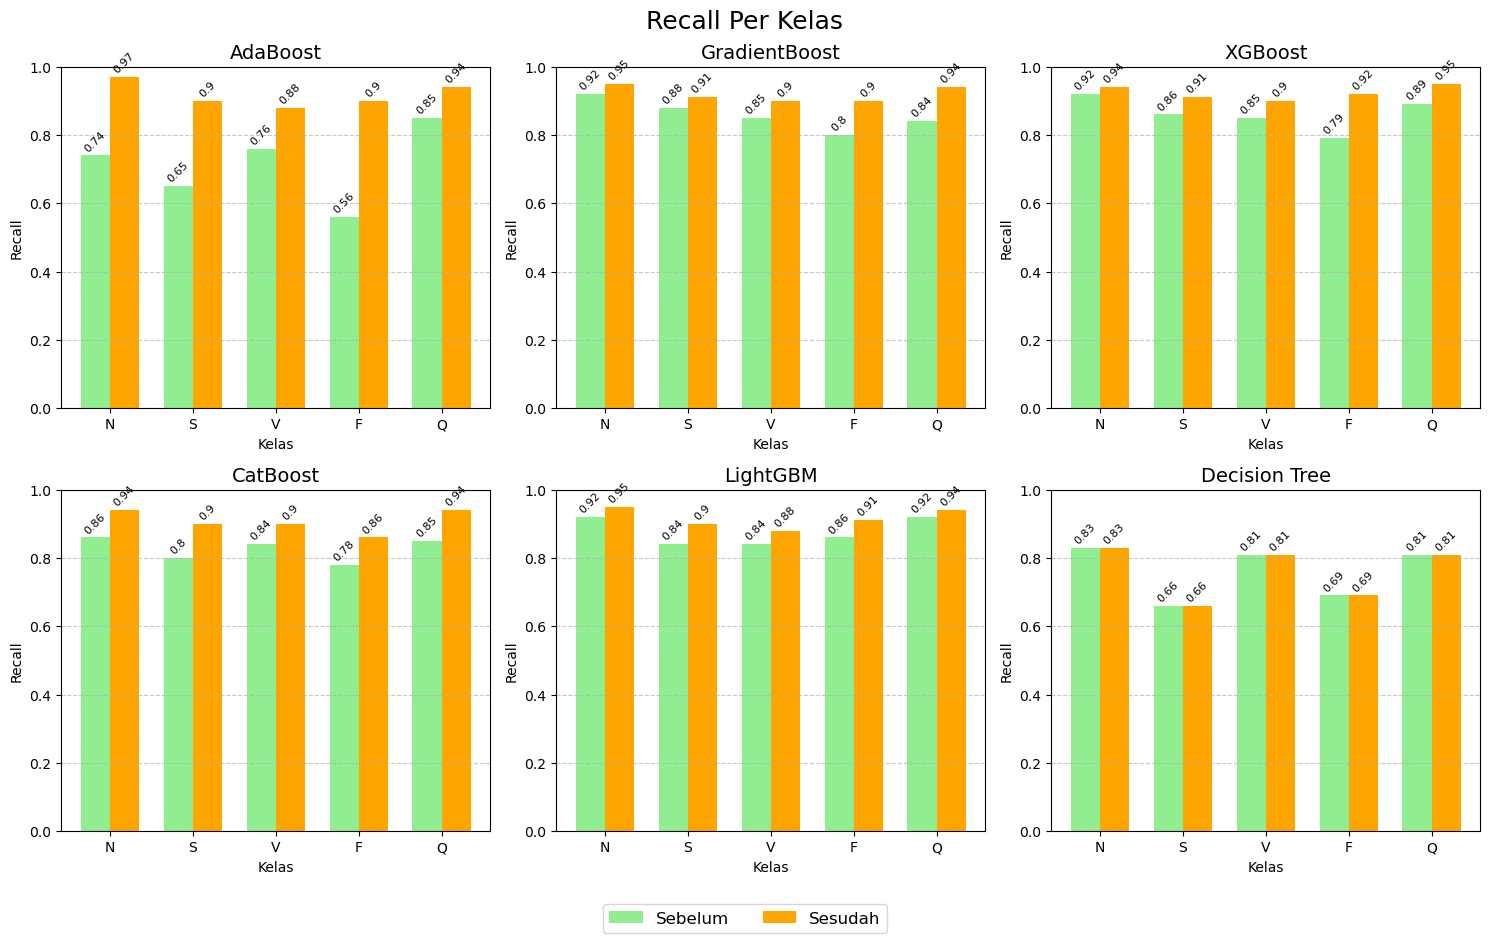

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Nama algoritma dan kelas
algorithms = ['AdaBoost', 'GradientBoost', 'XGBoost', 'CatBoost', 'LightGBM', 'Decision Tree']
classes = ['N', 'S', 'V', 'F', 'Q']

# Data recall sebelum optimasi
recall_before = {
    'AdaBoost': [0.74, 0.65, 0.76, 0.56, 0.85],
    'GradientBoost': [0.92, 0.88, 0.85, 0.80, 0.84],
    'XGBoost': [0.92, 0.86, 0.85, 0.79, 0.89],
    'CatBoost': [0.86, 0.80, 0.84, 0.78, 0.85],
    'LightGBM': [0.92, 0.84, 0.84, 0.86, 0.92],
    'Decision Tree': [0.83,0.66,0.81,0.69,0.81]
}

# Data recall setelah optimasi
recall_after = {
    'AdaBoost': [0.9700, 0.9000, 0.8800, 0.9000, 0.9400],
    'GradientBoost': [0.9500, 0.9100, 0.9000, 0.9000, 0.9400],
    'XGBoost': [0.9400, 0.9100, 0.9000, 0.9200, 0.9500],
    'CatBoost': [0.9400, 0.9000, 0.9000, 0.8600, 0.9400],
    'LightGBM': [0.9500, 0.9000, 0.8800, 0.9100, 0.9400],
    'Decision Tree': [0.83,0.66,0.81,0.69,0.81]
}

x = np.arange(len(classes))
width = 0.35

fig, axs = plt.subplots(2, 3, figsize=(15,10))
axs = axs.flatten()

for i, algo in enumerate(algorithms):
    bars_before = axs[i].bar(x - width/2, recall_before[algo], width, label='Sebelum', color='lightgreen')
    bars_after = axs[i].bar(x + width/2, recall_after[algo], width, label='Sesudah', color='orange')

    axs[i].set_title(f'{algo}', fontsize=14)
    axs[i].set_xlabel('Kelas')
    axs[i].set_ylabel('Recall')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(classes)
    axs[i].set_ylim(0, 1)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars_before + bars_after:
        height = bar.get_height()
        axs[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', fontsize=8, rotation=45)

if len(algorithms) % 2 != 0:
    fig.delaxes(axs[-1])

fig.suptitle('Recall Per Kelas', fontsize=18, y=0.93)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


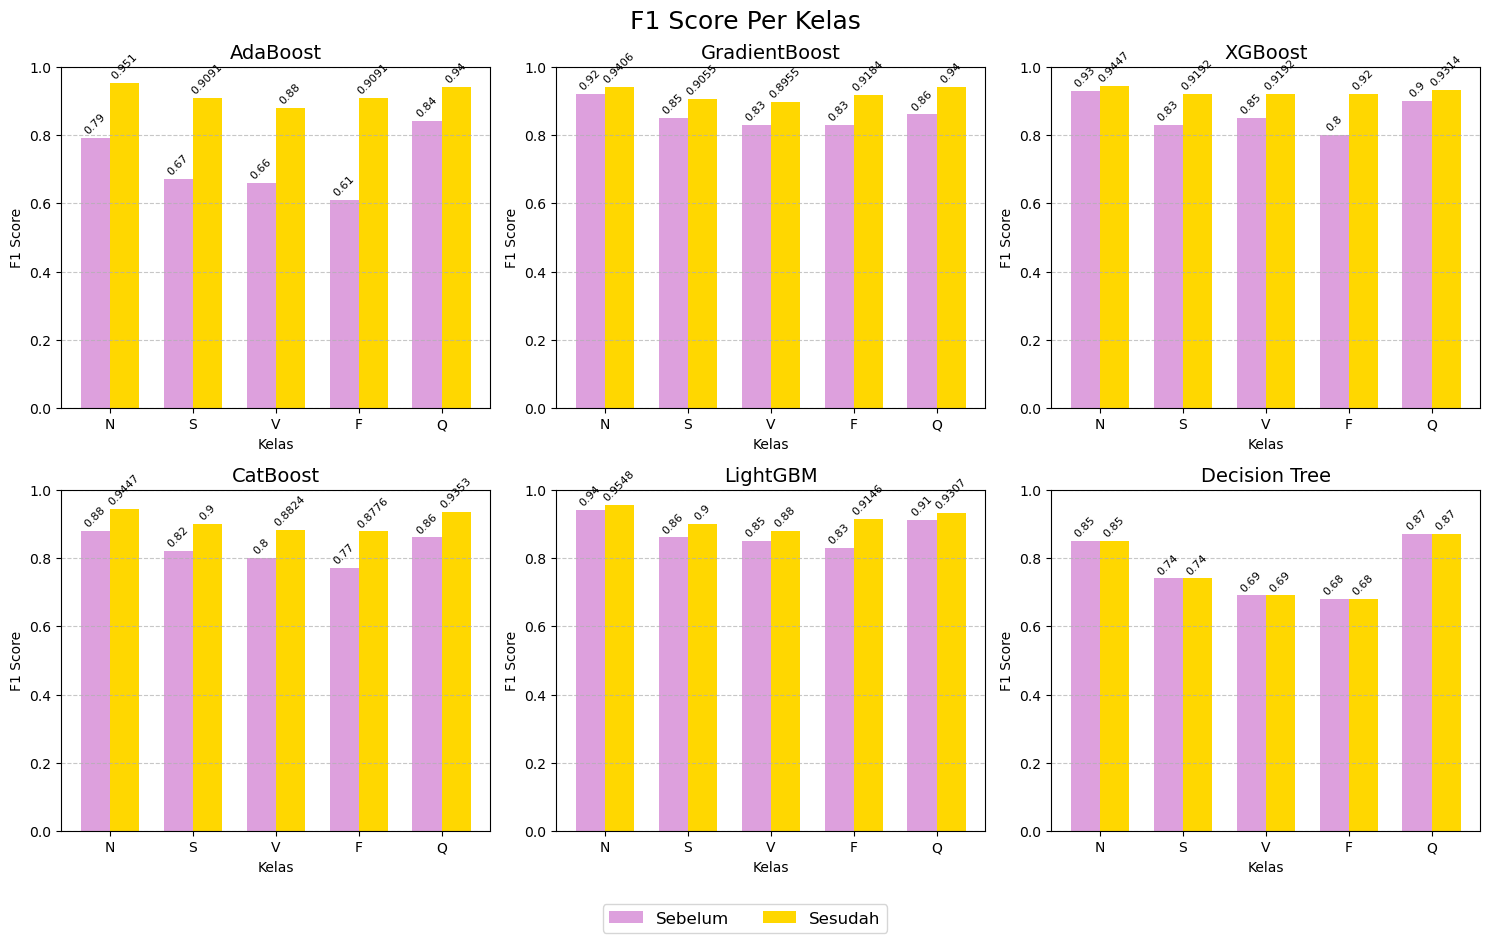

In [49]:
# Data F1 score sebelum optimasi
f1_before = {
    'AdaBoost': [0.79, 0.67, 0.66, 0.61, 0.84],
    'GradientBoost': [0.92, 0.85, 0.83, 0.83, 0.86],
    'XGBoost': [0.93, 0.83, 0.85, 0.80, 0.90],
    'CatBoost': [0.88, 0.82, 0.80, 0.77, 0.86],
    'LightGBM': [0.94, 0.86, 0.85, 0.83, 0.91],
    'Decision Tree': [0.85,0.74,0.69,0.68,0.87]
}

# Data F1 score setelah optimasi
f1_after = {
    'AdaBoost': [0.9510, 0.9091, 0.8800, 0.9091, 0.9400],
    'GradientBoost': [0.9406, 0.9055, 0.8955, 0.9184, 0.9400],
    'XGBoost': [0.9447, 0.9192, 0.9192, 0.9200, 0.9314],
    'CatBoost': [0.9447, 0.9000, 0.8824, 0.8776, 0.9353],
    'LightGBM': [0.9548, 0.9000, 0.8800, 0.9146, 0.9307],
    'Decision Tree': [0.85,0.74,0.69,0.68,0.87] }

fig, axs = plt.subplots(2, 3, figsize=(15,10))
axs = axs.flatten()

for i, algo in enumerate(algorithms):
    bars_before = axs[i].bar(x - width/2, f1_before[algo], width, label='Sebelum', color='plum')
    bars_after = axs[i].bar(x + width/2, f1_after[algo], width, label='Sesudah', color='gold')

    axs[i].set_title(f'{algo}', fontsize=14)
    axs[i].set_xlabel('Kelas')
    axs[i].set_ylabel('F1 Score')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(classes)
    axs[i].set_ylim(0, 1)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars_before + bars_after:
        height = bar.get_height()
        axs[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', fontsize=8, rotation=45)

if len(algorithms) % 2 != 0:
    fig.delaxes(axs[-1])

fig.suptitle('F1 Score Per Kelas', fontsize=18, y=0.93)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


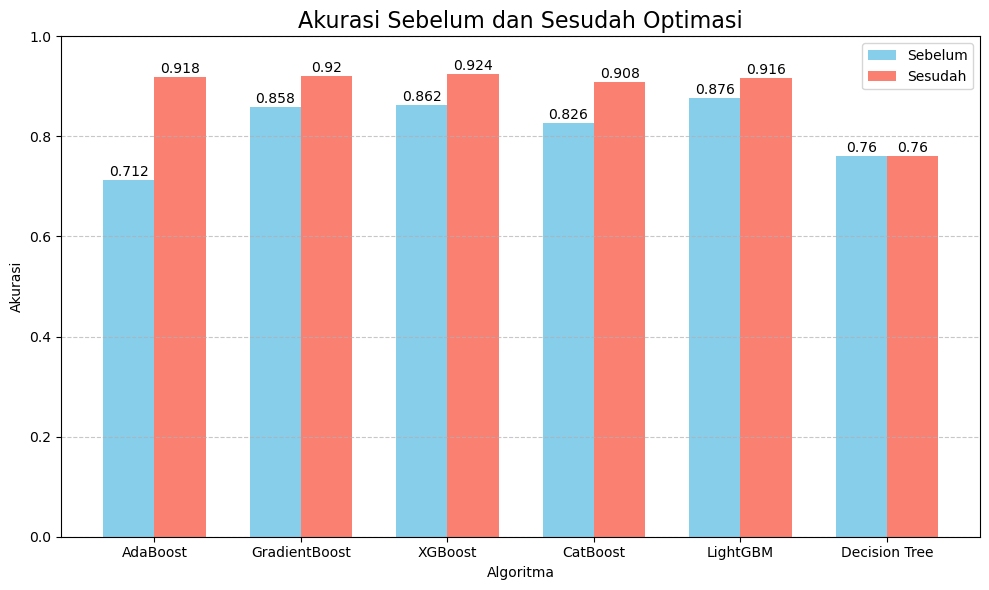

In [51]:
import matplotlib.pyplot as plt
import numpy as np

algorithms = ['AdaBoost', 'GradientBoost', 'XGBoost', 'CatBoost', 'LightGBM', 'Decision Tree']

# Data akurasi sebelum dan sesudah
accuracy_before = [0.712, 0.858, 0.862, 0.826, 0.876, 0.76]
accuracy_after = [0.9180, 0.9200, 0.9240, 0.9080, 0.9160, 0.76]

x = np.arange(len(algorithms))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars_before = ax.bar(x - width/2, accuracy_before, width, label='Sebelum', color='skyblue')
bars_after = ax.bar(x + width/2, accuracy_after, width, label='Sesudah', color='salmon')

ax.set_title('Akurasi Sebelum dan Sesudah Optimasi', fontsize=16)
ax.set_xlabel('Algoritma')
ax.set_ylabel('Akurasi')
ax.set_ylim(0, 1)
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars_before + bars_after:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', fontsize=10)

ax.legend()
plt.tight_layout()
plt.show()


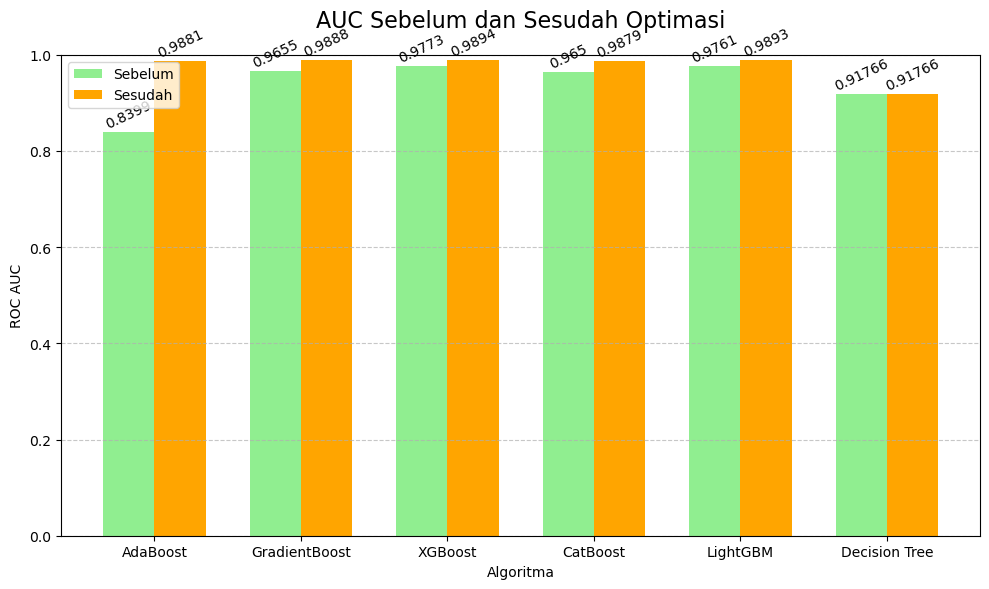

In [59]:
# Data ROC AUC sebelum dan sesudah
roc_auc_before = [0.8399, 0.9655, 0.9773,  0.9650, 0.9761,  0.91766]
roc_auc_after = [0.9881, 0.9888, 0.9894, 0.9879,  0.9893, 0.91766]

x = np.arange(len(algorithms))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars_before = ax.bar(x - width/2, roc_auc_before, width, label='Sebelum', color='lightgreen')
bars_after = ax.bar(x + width/2, roc_auc_after, width, label='Sesudah', color='orange')

ax.set_title('AUC Sebelum dan Sesudah Optimasi', fontsize=16, pad=20)
ax.set_xlabel('Algoritma')
ax.set_ylabel('ROC AUC')
ax.set_ylim(0, 1)
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars_before + bars_after:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', fontsize=10, rotation=25)

ax.legend()
plt.tight_layout()
plt.show()


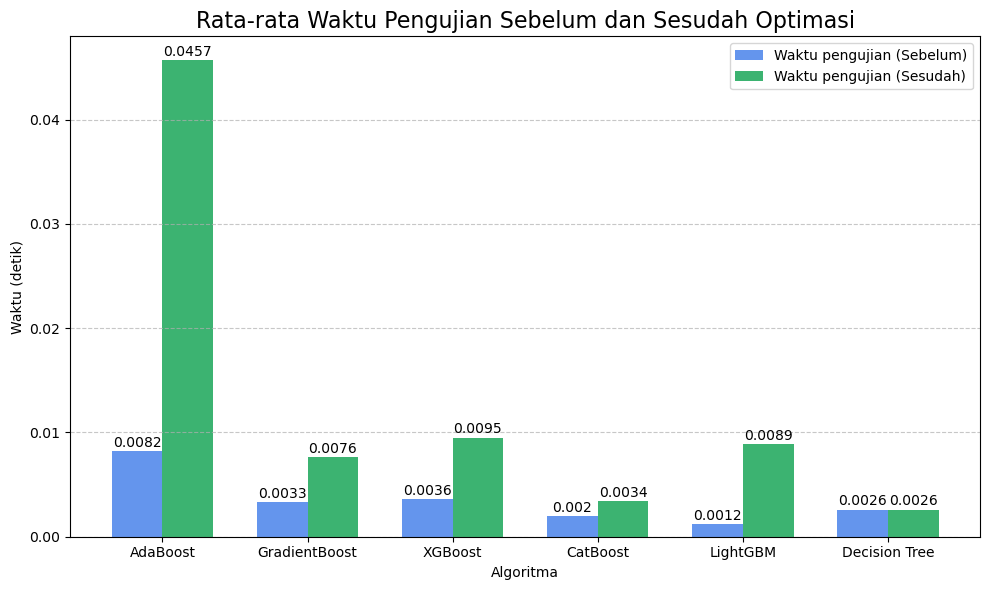

In [61]:
import matplotlib.pyplot as plt
import numpy as np

algorithms = ['AdaBoost', 'GradientBoost', 'XGBoost', 'CatBoost', 'LightGBM', 'Decision Tree']

# Data dalam detik (contoh aja, ganti sesuai datamu)
prediction_time_before = [0.0082 , 0.0033 , 0.0036, 0.0020, 0.0012, 0.0026]
testing_time_after = [0.0457, 0.0076, 0.0095, 0.0034, 0.0089, 0.0026]

x = np.arange(len(algorithms))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars_before = ax.bar(x - width/2, prediction_time_before, width, label='Waktu pengujian (Sebelum)', color='cornflowerblue')
bars_after = ax.bar(x + width/2, testing_time_after, width, label='Waktu pengujian (Sesudah)', color='mediumseagreen')

ax.set_title('Rata-rata Waktu Pengujian Sebelum dan Sesudah Optimasi', fontsize=16)
ax.set_xlabel('Algoritma')
ax.set_ylabel('Waktu (detik)')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars_before + bars_after:
    height = bar.get_height()
    ax.annotate(f'{height:}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', fontsize=10)

ax.legend()
plt.tight_layout()
plt.show()


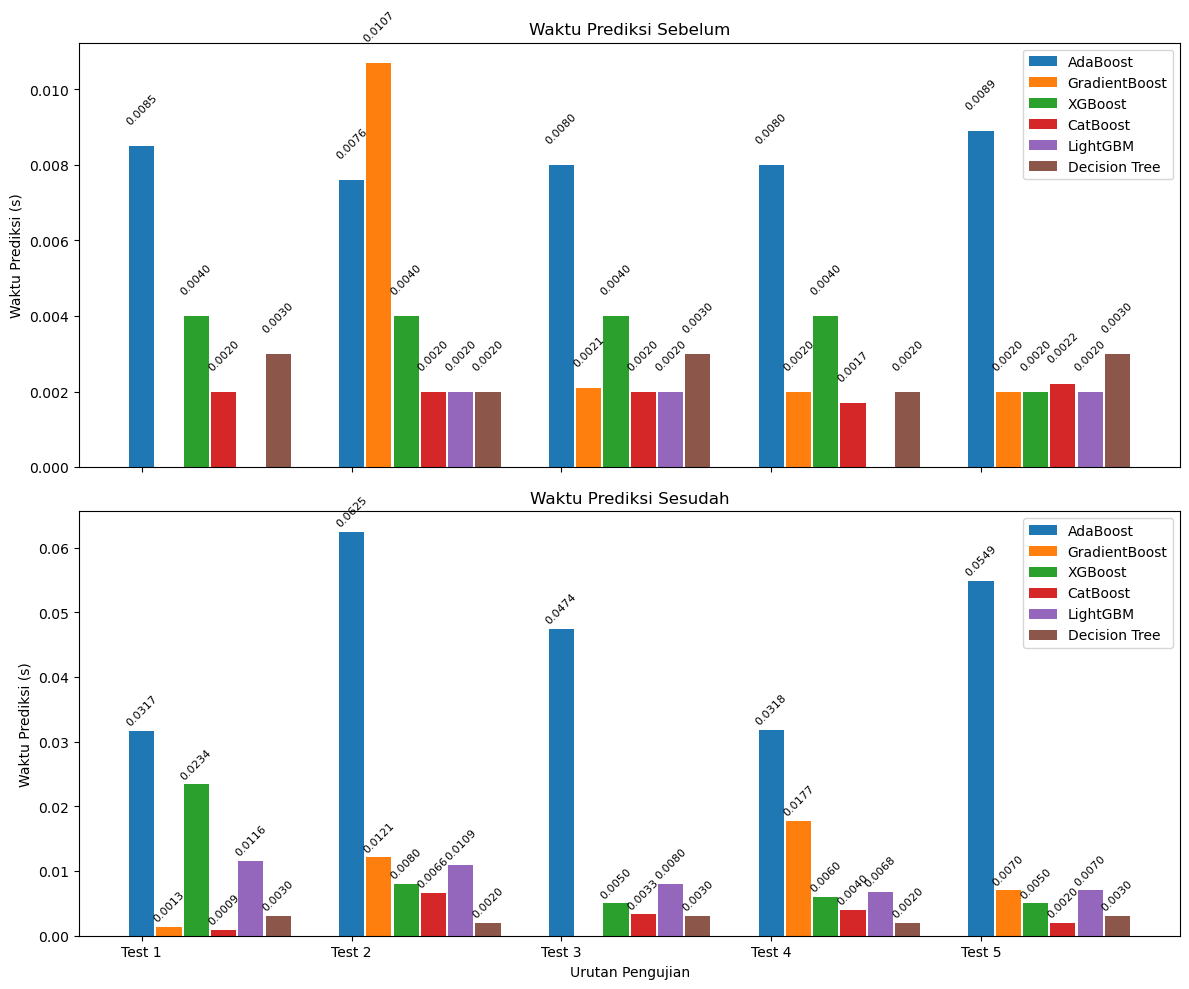

In [63]:
import matplotlib.pyplot as plt

# Data per waktu prediksi
models = ['AdaBoost', 'GradientBoost', 'XGBoost', 'CatBoost', 'LightGBM', 'Decision Tree']
before_times_all = [                        
    [0.0085, 0.0076, 0.008, 0.008, 0.0089],                    # AdaBoost
    [0.0, 0.0107, 0.0021, 0.002, 0.002],                      # GradientBoost
    [0.004, 0.004, 0.004, 0.004, 0.002],                      # XGBoost
    [0.002, 0.002, 0.002, 0.0017, 0.0022],                    # CatBoost
    [0.0, 0.002, 0.002, 0.0, 0.002], #LightGBM
    [0.003, 0.002, 0.003, 0.002, 0.003] #DT
]
after_times_all = [            
    [0.0317, 0.0625, 0.0474, 0.0318, 0.0549],                 # AdaBoost
    [0.0013, 0.0121, 0.0, 0.0177, 0.0070],                   # GradientBoost
    [0.0234, 0.0080, 0.0050, 0.0060, 0.0050],                # XGBoost
    [0.0009, 0.0066, 0.0033, 0.0040, 0.0020],                # CatBoost
    [0.0116, 0.0109, 0.0080, 0.0068, 0.0070], #LightGBM
    [0.003, 0.002, 0.003, 0.002, 0.003] #DT
]

# Plot semua waktu prediksi
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot Sebelum
for i, times in enumerate(before_times_all):
    bars = axes[0].bar([x + i*0.13 for x in range(len(times))], times, width=0.12, label=models[i])
    
    # Tambahkan label nilai di atas batang
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Hanya tampilkan label jika nilai > 0
            axes[0].text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.0005,  # Sedikit di atas batang
                f'{height:.4f}',
                ha='center', va='bottom', 
                fontsize=8, rotation=45
            )

axes[0].set_ylabel('Waktu Prediksi (s)')
axes[0].set_title('Waktu Prediksi Sebelum')
axes[0].legend()
axes[0].set_xticks(range(5))
axes[0].set_xticklabels([f'Test {i+1}' for i in range(5)])

# Plot Sesudah
for i, times in enumerate(after_times_all):
    bars = axes[1].bar([x + i*0.13 for x in range(len(times))], times, width=0.12, label=models[i])
    
    # Tambahkan label nilai di atas batang
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Hanya tampilkan label jika nilai > 0
            axes[1].text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.0005,  # Sedikit di atas batang
                f'{height:.4f}',
                ha='center', va='bottom', 
                fontsize=8, rotation=45
            )

axes[1].set_xlabel('Urutan Pengujian')
axes[1].set_ylabel('Waktu Prediksi (s)')
axes[1].set_title('Waktu Prediksi Sesudah')
axes[1].legend()
axes[1].set_xticks(range(5))
axes[1].set_xticklabels([f'Test {i+1}' for i in range(5)])

# Pastikan tata letak yang rapi
plt.tight_layout()
plt.show()

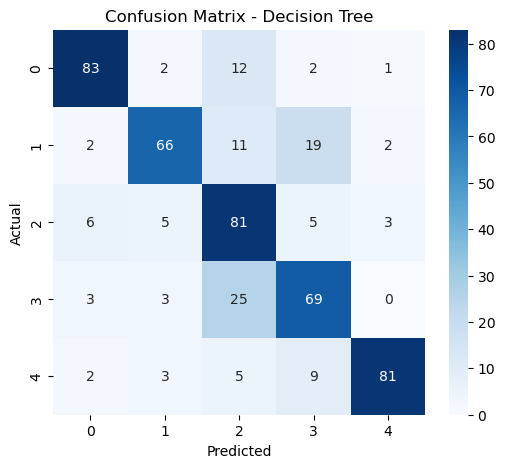

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Contoh confusion matrix untuk Decision Tree
cm = np.array([[83, 2, 12, 2,1],
                [2, 66, 11, 19, 2],
                [6, 5, 81, 5, 3],
                [3, 3, 25, 69, 0],
                [2, 3, 5, 9, 81]])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


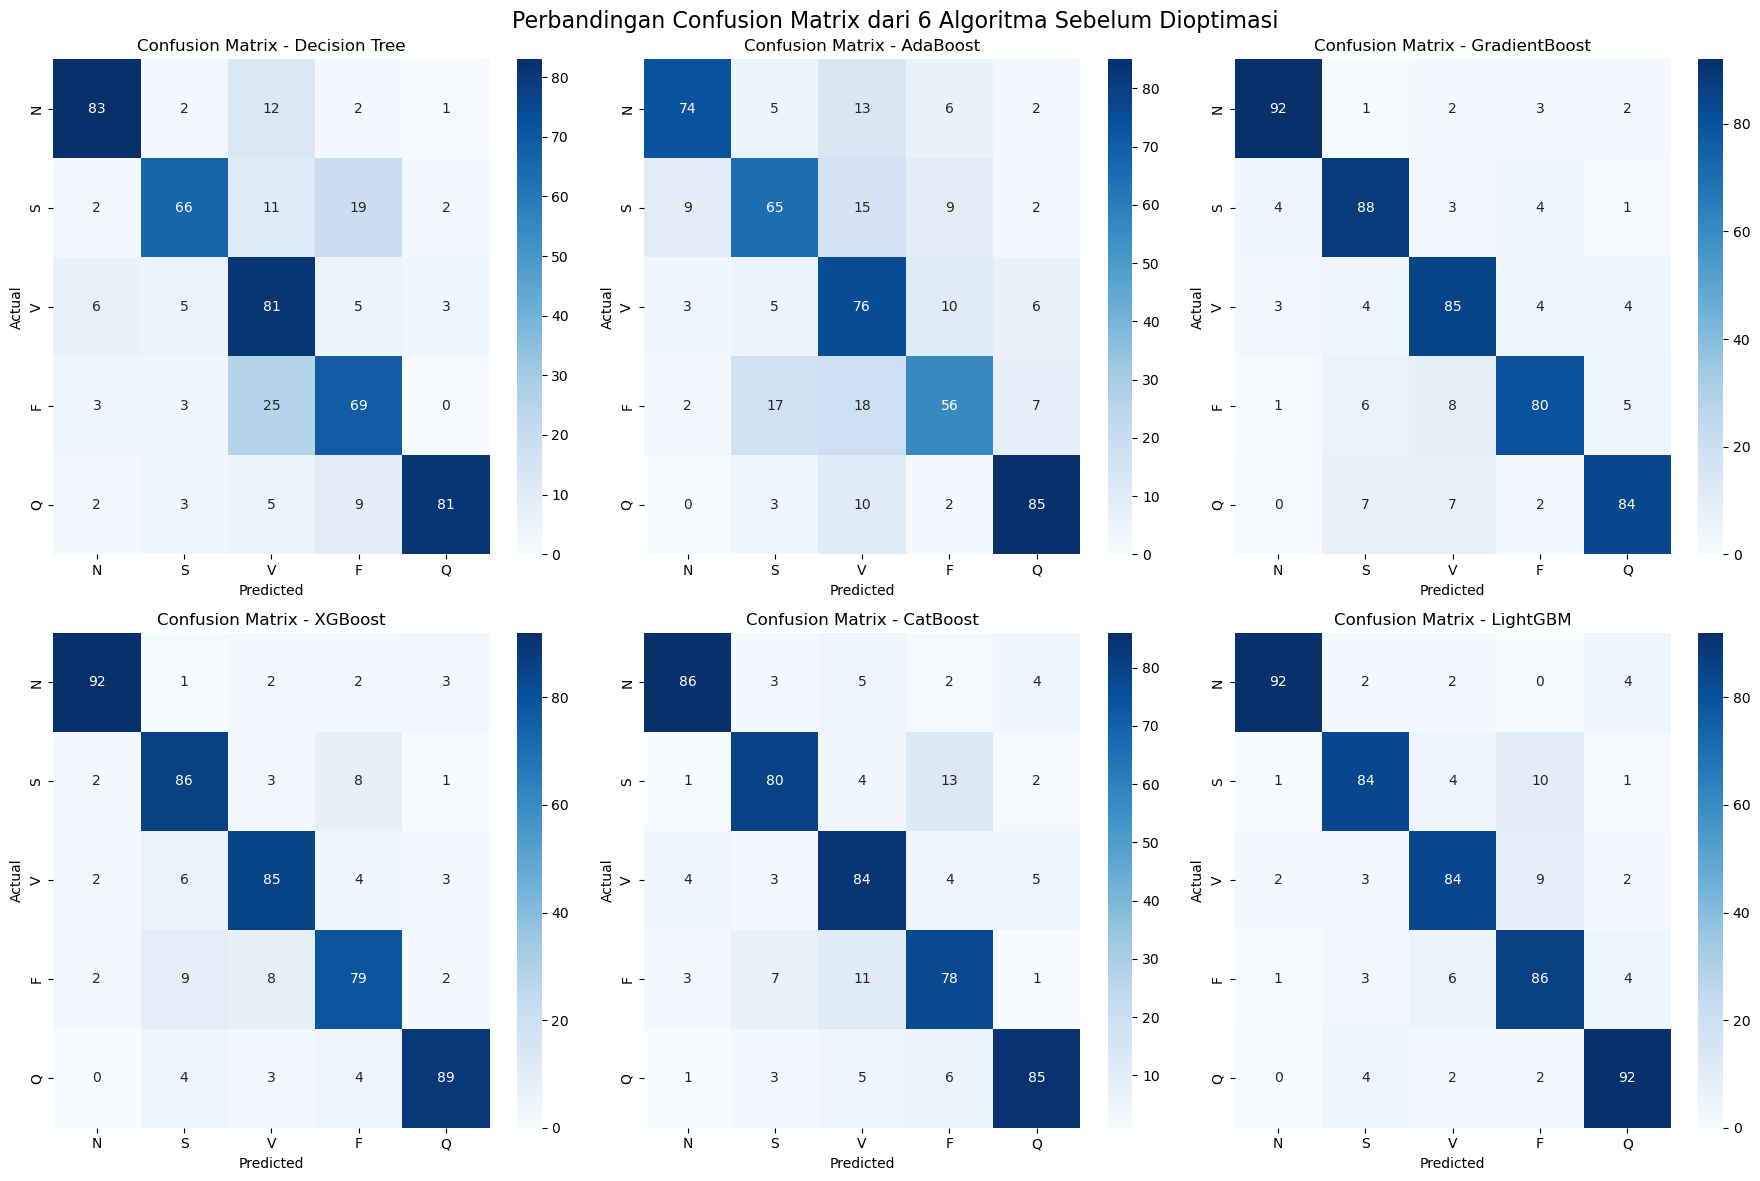

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix untuk 6 algoritma
decision_tree_cm = np.array([
    [83, 2, 12, 2,1],
    [2, 66, 11, 19, 2],
    [6, 5, 81, 5, 3],
    [3, 3, 25, 69, 0],
    [2, 3, 5, 9, 81]
])

adaboost_cm = np.array([
    [74, 5, 13, 6, 2],
    [9, 65, 15, 9, 2],
    [3, 5, 76, 10, 6],
    [2, 17, 18, 56, 7],
    [0, 3, 10, 2, 85]
])

gradientboost_cm = np.array([
    [92, 1, 2, 3, 2],
    [4, 88, 3, 4, 1],
    [3, 4, 85, 4, 4],
    [1, 6, 8, 80, 5],
    [0, 7, 7, 2, 84]
])

xgboost_cm = np.array([
    [92, 1, 2, 2, 3],
    [2, 86, 3, 8, 1],
    [2, 6, 85, 4, 3],
    [2, 9, 8, 79, 2],
    [0, 4, 3, 4, 89]
])

catboost_cm = np.array([
    [86, 3, 5, 2, 4],
    [1, 80, 4, 13, 2],
    [4, 3, 84, 4, 5],
    [3, 7, 11, 78, 1],
    [1, 3, 5, 6, 85]
])

lightgbm_cm = np.array([
    [92, 2, 2, 0, 4],
    [1, 84, 4, 10, 1],
    [2, 3, 84, 9, 2],
    [1, 3, 6, 86, 4],
    [0, 4, 2, 2, 92]
])

# Membuat figur dengan 6 subplots (2 baris, 3 kolom)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Label kelas (bisa disesuaikan jika ada label sebenarnya)
class_labels = ['N', 'S', 'V', 'F', 'Q']

# Buat heatmap untuk Decision Tree
sns.heatmap(decision_tree_cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix - Decision Tree')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# Buat heatmap untuk AdaBoost
sns.heatmap(adaboost_cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - AdaBoost')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Buat heatmap untuk GradientBoost
sns.heatmap(gradientboost_cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0, 2])
axes[0, 2].set_title('Confusion Matrix - GradientBoost')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# Buat heatmap untuk XGBoost
sns.heatmap(xgboost_cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - XGBoost')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Buat heatmap untuk CatBoost
sns.heatmap(catboost_cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - CatBoost')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# Buat heatmap untuk LightGBM
sns.heatmap(lightgbm_cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[1, 2])
axes[1, 2].set_title('Confusion Matrix - LightGBM')
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')

fig.suptitle('Perbandingan Confusion Matrix dari 6 Algoritma Sebelum Dioptimasi', fontsize=16, y=0.98)

# Pastikan tata letak yang rapi
plt.tight_layout()
plt.show()

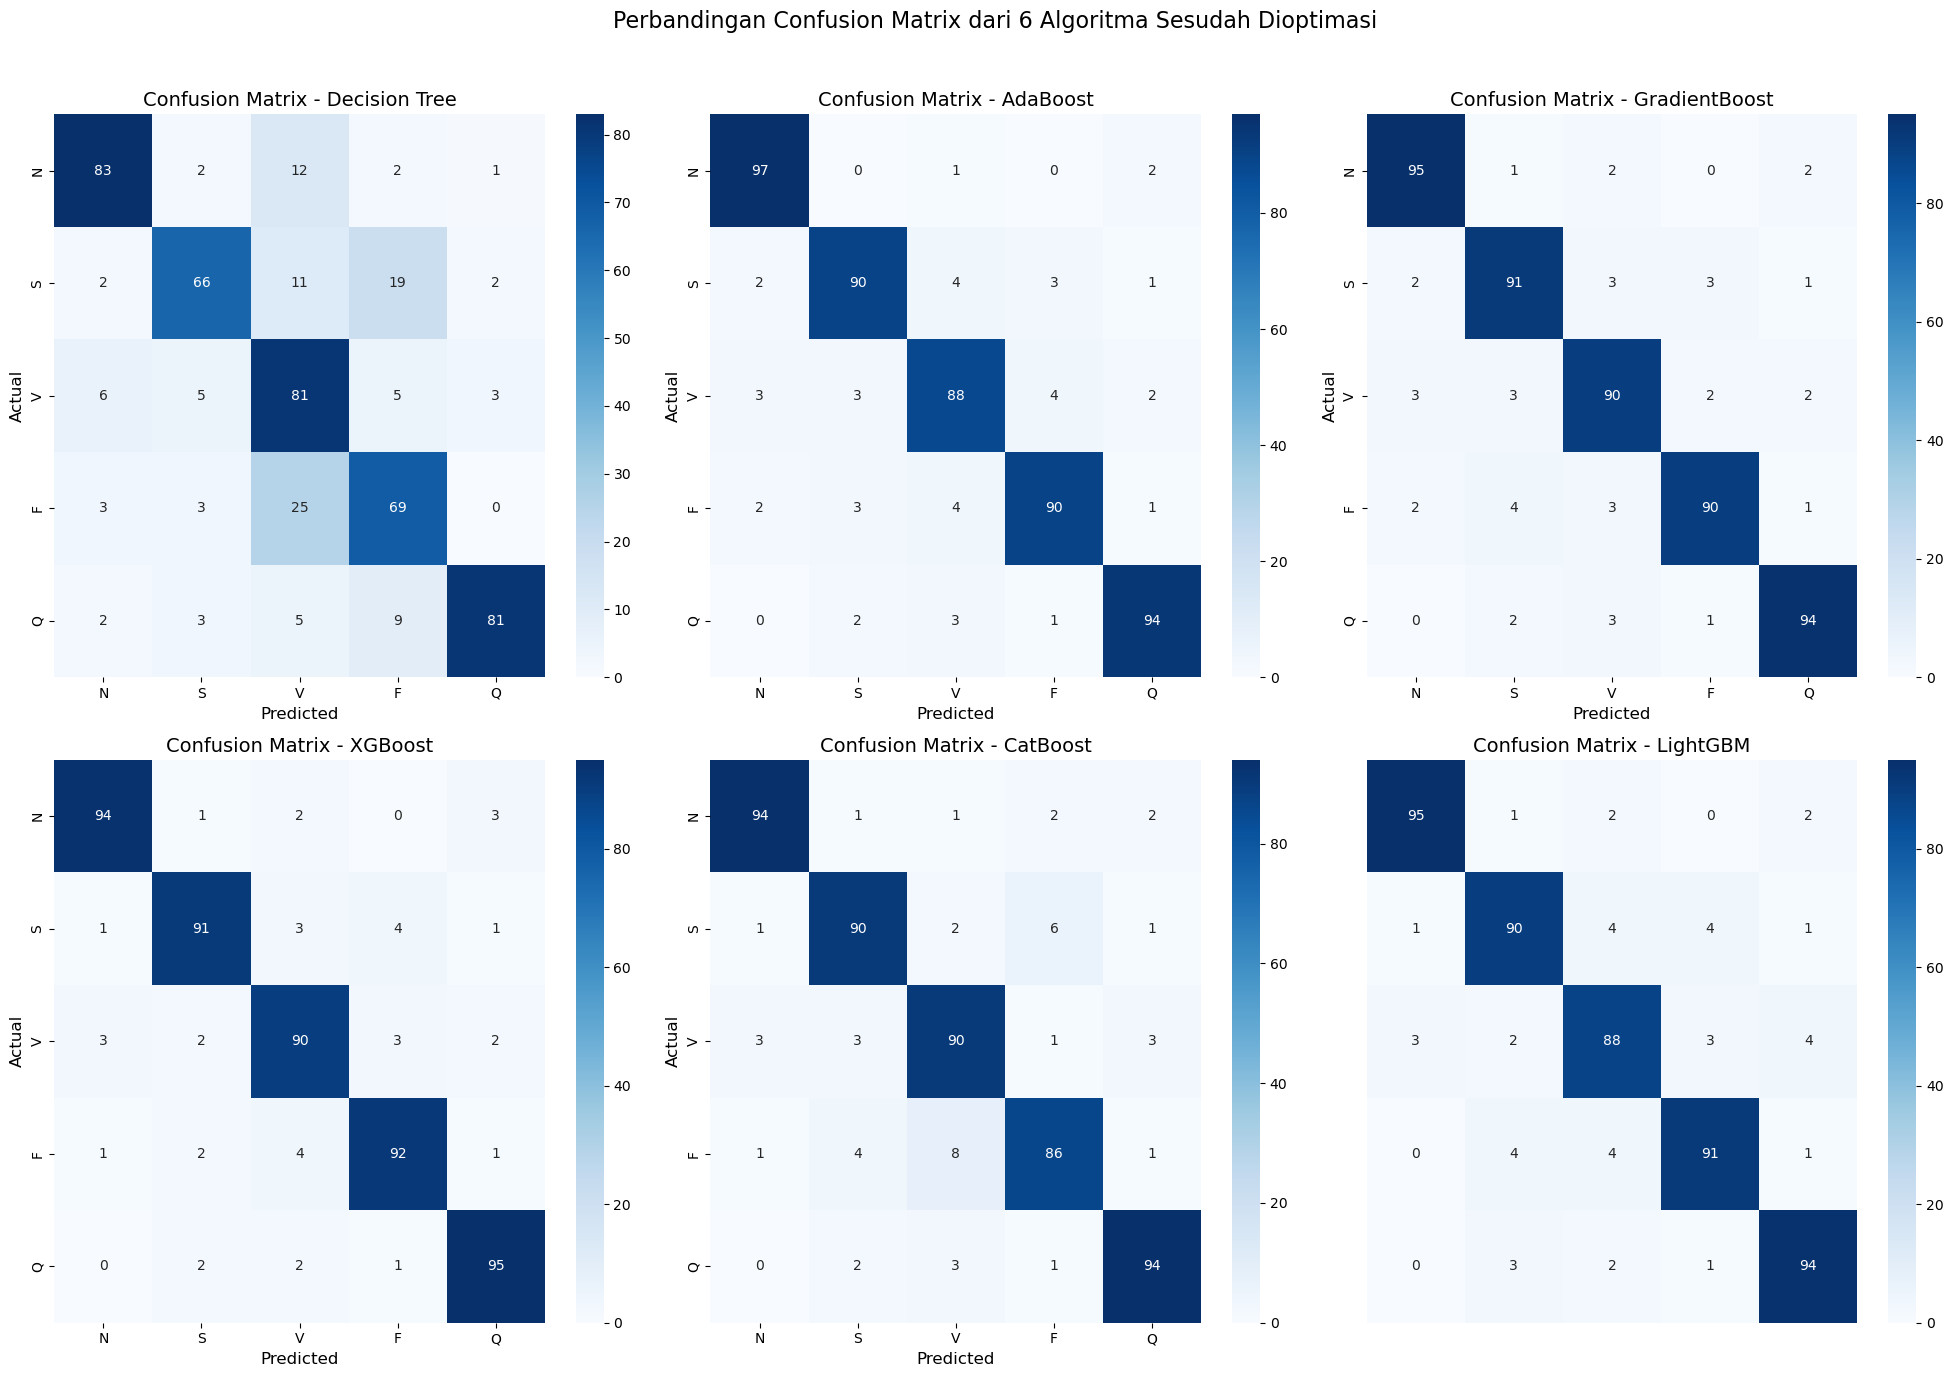

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix untuk 5 algoritma berdasarkan gambar yang diberikan
decision_tree_cm = np.array([
    [83, 2, 12, 2,1],
    [2, 66, 11, 19, 2],
    [6, 5, 81, 5, 3],
    [3, 3, 25, 69, 0],
    [2, 3, 5, 9, 81]
])
adaboost_cm = np.array([
    [97, 0, 1, 0, 2],
    [2, 90, 4, 3, 1],
    [3, 3, 88, 4, 2],
    [2, 3, 4, 90, 1],
    [0, 2, 3, 1, 94]
])

gradientboost_cm = np.array([
    [95, 1, 2, 0, 2],
    [2, 91, 3, 3, 1],
    [3, 3, 90, 2, 2],
    [2, 4, 3, 90, 1],
    [0, 2, 3, 1, 94]
])

xgboost_cm = np.array([
    [94, 1, 2, 0, 3],
    [1, 91, 3, 4, 1],
    [3, 2, 90, 3, 2],
    [1, 2, 4, 92, 1],
    [0, 2, 2, 1, 95]
])

catboost_cm = np.array([
    [94, 1, 1, 2, 2],
    [1, 90, 2, 6, 1],
    [3, 3, 90, 1, 3],
    [1, 4, 8, 86, 1],
    [0, 2, 3, 1, 94]
])

lightgbm_cm = np.array([
    [95, 1, 2, 0, 2],
    [1, 90, 4, 4, 1],
    [3, 2, 88, 3, 4],
    [0, 4, 4, 91, 1],
    [0, 3, 2, 1, 94]
])

# Judul untuk setiap algoritma
titles = ['Confusion Matrix - Decision Tree', 'Confusion Matrix - AdaBoost', 'Confusion Matrix - GradientBoost', 
          'Confusion Matrix - XGBoost', 'Confusion Matrix - CatBoost',
          'Confusion Matrix - LightGBM']

# Membuat figur yang menggabungkan semua confusion matrix dalam satu gambar
fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# Menyesuaikan data confusion matrix dan judul untuk setiap subplot
cm_data = [decision_tree_cm, adaboost_cm, gradientboost_cm, xgboost_cm, catboost_cm, lightgbm_cm]

# Memetakan subplot
subplot_indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

# Label kelas
class_labels = ['N', 'S', 'V', 'F', 'Q']

# Membuat heatmap untuk setiap confusion matrix
for i, (cm, title, (row, col)) in enumerate(zip(cm_data, titles, subplot_indices)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[row, col])
    axes[row, col].set_title(title, fontsize=14)
    axes[row, col].set_xlabel('Predicted', fontsize=12)
    axes[row, col].set_ylabel('Actual', fontsize=12)

# Menyembunyikan subplot yang tidak digunakan
axes[1, 2].axis('off')

# Membuat judul utama
fig.suptitle('Perbandingan Confusion Matrix dari 6 Algoritma Sesudah Dioptimasi', fontsize=16, y=0.98)

# Memberikan ruang lebih banyak di antara subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()